In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn

import os.path
import random
from random import uniform
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import argparse
import math
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Augmentation

In [ ]:
class Compose(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for function_ in self.transforms:
            data = function_(data)
        return data


class Crop(object):

    def __init__(self, max_crop=0.1):
        super().__init__()
        self.max_crop = max_crop

    def __call__(self, data):
        image, label = data
        height, width = image.shape[:2]
        xmin = width
        ymin = height
        xmax = 0
        ymax = 0
        for lb in label:
            xmin = min(xmin, lb[0])
            ymin = min(ymin, lb[1])
            xmax = max(xmax, lb[2])
            ymax = max(ymax, lb[2])
        cropped_left = uniform(0, self.max_crop)
        cropped_right = uniform(0, self.max_crop)
        cropped_top = uniform(0, self.max_crop)
        cropped_bottom = uniform(0, self.max_crop)
        new_xmin = int(min(cropped_left * width, xmin))
        new_ymin = int(min(cropped_top * height, ymin))
        new_xmax = int(max(width - 1 - cropped_right * width, xmax))
        new_ymax = int(max(height - 1 - cropped_bottom * height, ymax))

        image = image[new_ymin:new_ymax, new_xmin:new_xmax, :]
        label = [[lb[0] - new_xmin, lb[1] - new_ymin, lb[2] - new_xmin, lb[3] - new_ymin, lb[4]] for lb in label]

        return image, label


class VerticalFlip(object):

    def __init__(self, prob=0.5):
        super().__init__()
        self.prob = prob

    def __call__(self, data):
        image, label = data
        if uniform(0, 1) >= self.prob:
            image = cv2.flip(image, 1)
            width = image.shape[1]
            label = [[width - lb[2], lb[1], width - lb[0], lb[3], lb[4]] for lb in label]
        return image, label


class HSVAdjust(object):

    def __init__(self, hue=30, saturation=1.5, value=1.5, prob=0.5):
        super().__init__()
        self.hue = hue
        self.saturation = saturation
        self.value = value
        self.prob = prob

    def __call__(self, data):

        def clip_hue(hue_channel):
            hue_channel[hue_channel >= 360] -= 360
            hue_channel[hue_channel < 0] += 360
            return hue_channel

        image, label = data
        adjust_hue = uniform(-self.hue, self.hue)
        adjust_saturation = uniform(1, self.saturation)
        if uniform(0, 1) >= self.prob:
            adjust_saturation = 1 / adjust_saturation
        adjust_value = uniform(1, self.value)
        if uniform(0, 1) >= self.prob:
            adjust_value = 1 / adjust_value
        image = image.astype(np.float32) / 255
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image[:, :, 0] += adjust_hue
        image[:, :, 0] = clip_hue(image[:, :, 0])
        image[:, :, 1] = np.clip(adjust_saturation * image[:, :, 1], 0.0, 1.0)
        image[:, :, 2] = np.clip(adjust_value * image[:, :, 2], 0.0, 1.0)

        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        image = (image * 255).astype(np.float32)

        return image, label


class Resize(object):

    def __init__(self, image_size):
        super().__init__()
        self.image_size = image_size

    def __call__(self, data):
        image, label = data
        height, width = image.shape[:2]
        image = cv2.resize(image, (self.image_size, self.image_size))
        width_ratio = float(self.image_size) / width
        height_ratio = float(self.image_size) / height
        new_label = []
        for lb in label:
            resized_xmin = lb[0] * width_ratio
            resized_ymin = lb[1] * height_ratio
            resized_xmax = lb[2] * width_ratio
            resized_ymax = lb[3] * height_ratio
            resize_width = resized_xmax - resized_xmin
            resize_height = resized_ymax - resized_ymin
            new_label.append([resized_xmin, resized_ymin, resize_width, resize_height, lb[4]])

        return image, new_label

## Yolo dataset

In [ ]:
class yoloDataset(data.Dataset):
    image_size = 416 # Size to be aligned

    # Parsing data list
    def __init__(self,root,list_file,train):
        self.root = root
        self.train = train
        self.fnames = []
        self.objects = [] # [x_min, y_min, x_max, y_max, class]
        self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                        'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                        'tvmonitor']
        self.num_classes = len(self.classes)

        with open(list_file) as f:
            lines  = f.readlines()

        # format of each line: filename (x_min, y_min, x_max, y_max, label) * object_num
        for line in lines:
            splited = line.strip().split() # .strip(): reomove space, tab from the end of each line
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            one_object = []
            for i in range(num_boxes):
                x_min = float(splited[1+5*i])
                y_min = float(splited[2+5*i])
                x_max = float(splited[3+5*i])
                y_max = float(splited[4+5*i])
                c = splited[5+5*i]
                # int(c)+1
                one_object.append([x_min,y_min,x_max,y_max, int(c)])
            self.objects.append(one_object)
        self.num_samples = len(self.objects)

    # Getting single transformed, preprocessed image and its bounding boxes
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        image_objects = self.objects[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.train:
            transformations = Compose([HSVAdjust(), VerticalFlip(), Crop(), Resize(self.image_size)])
        else:
            transformations = Compose([Resize(self.image_size)])

        # h,w,_ = img.shape
        # boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes)    -> replaced by batch-norm(?)
        # img = self.subMean(img,self.mean)
        # to see the whih grid is the box is located at
        # .expand_as(other): expand this tensor as other
        # [w, h, w, h] (1, 4) will be expanded to (#box, 4)
        img, image_objects = transformations((img, image_objects))
#         print(len(image_objects))

        # img.shape (416,416,3) -> (3,416,416)
        return np.transpose(np.array(img, dtype=np.float32), (2, 0, 1)), np.array(image_objects, dtype=np.float32)

    def __len__(self):
        return self.num_samples

## Yolo structure

In [ ]:
def build_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, isMaxpool=False):
    if(isMaxpool):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,bias=bias),
                             nn.BatchNorm2d(out_channels),
                             nn.LeakyReLU(0.1, inplace=True),
                             nn.MaxPool2d(2,2))
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,bias=bias),
                             nn.BatchNorm2d(out_channels),
                             nn.LeakyReLU(0.1, inplace=True))

In [ ]:
class Yolov2(nn.Module):
    def __init__(self, num_classes, 
                 anchors = [(1.3221, 1.73145), (3.19275, 4.00944), (5.05587, 8.09892), (9.47112, 4.84053),(11.2364, 10.0071)]):
        super(Yolov2,self).__init__()
        self.num_classes = num_classes
        self.anchors = anchors
        # darnet19
        self.stage1_c1 = build_layer(3, 32, 3, 1, 1, bias=False, isMaxpool=True)        
        self.stage1_c2 = build_layer(32, 64, 3, 1, 1, bias=False, isMaxpool=True)
        
        self.stage1_c3 = build_layer(64, 128, 3, 1, 1, bias=False, isMaxpool=False)        
        self.stage1_c4 = build_layer(128, 64, 1, 1, 0, bias=False, isMaxpool=False)        
        self.stage1_c5 = build_layer(64, 128, 3, 1, 1, bias=False, isMaxpool=True)  
        
        self.stage1_c6 = build_layer(128, 256, 3, 1, 1, bias=False, isMaxpool=False)        
        self.stage1_c7 = build_layer(256, 128, 1, 1, 0, bias=False, isMaxpool=False)        
        self.stage1_c8 = build_layer(128, 256, 3, 1, 1, bias=False, isMaxpool=True) 
        
        self.stage1_c9 = build_layer(256, 512, 3, 1, 1, bias=False, isMaxpool=False)        
        self.stage1_c10 = build_layer(512, 256, 1, 1, 0, bias=False, isMaxpool=False)        
        self.stage1_c11 = build_layer(256, 512, 3, 1, 1, bias=False, isMaxpool=False)        
        self.stage1_c12 = build_layer(512, 256, 1, 1, 0, bias=False, isMaxpool=False)        
        self.stage1_c13 = build_layer(256, 512, 3, 1, 1, bias=False, isMaxpool=False)
        
        self.stage2_maxpool = nn.MaxPool2d(2, 2)
        self.stage2_c1 = build_layer(512, 1024, 3, 1, 1, bias=False, isMaxpool=False)        
        self.stage2_c2 = build_layer(1024, 512, 1, 1, 0, bias=False, isMaxpool=False)        
        self.stage2_c3 = build_layer(512, 1024, 3, 1, 1, bias=False, isMaxpool=False)        
        self.stage2_c4 = build_layer(1024, 512, 1, 1, 0, bias=False, isMaxpool=False)        
        self.stage2_c5 = build_layer(512, 1024, 3, 1, 1, bias=False, isMaxpool=False)
        
        self.stage2_c6 = build_layer(1024, 1024, 3, 1, 1, bias=False, isMaxpool=False)
        self.stage2_c7 = build_layer(1024, 1024, 3, 1, 1, bias=False, isMaxpool=False)
        
        self.stage2_residual_c1 = build_layer(512, 64, 1, 1, 0, bias=False, isMaxpool=False)
        
        # classify head
        self.stage3_c1 = build_layer(256+1024, 1024, 1, 1, 0, bias=False, isMaxpool=False)
        self.stage3_c2 = nn.Conv2d(1024, len(self.anchors)*(5+self.num_classes), 1, 1, 0, bias=False)
#         self.avgpool = nn.AvgPool2d((1, 1))
#         self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input):
        output_1 = self.stage1_c1(input)
        output_1 = self.stage1_c2(output_1)
        output_1 = self.stage1_c3(output_1)
        output_1 = self.stage1_c4(output_1)
        output_1 = self.stage1_c5(output_1)
        output_1 = self.stage1_c6(output_1)
        output_1 = self.stage1_c7(output_1)
        output_1 = self.stage1_c8(output_1)
        output_1 = self.stage1_c9(output_1)
        output_1 = self.stage1_c10(output_1)
        output_1 = self.stage1_c11(output_1)
        output_1 = self.stage1_c12(output_1)
        output_1 = self.stage1_c13(output_1)

        residual = output_1

        output_2 = self.stage2_maxpool(output_1)
        output_2 = self.stage2_c1(output_2)
        output_2 = self.stage2_c2(output_2)
        output_2 = self.stage2_c3(output_2)
        output_2 = self.stage2_c4(output_2)
        output_2 = self.stage2_c5(output_2)
        output_2 = self.stage2_c6(output_2)
        output_2 = self.stage2_c7(output_2)
        
        # rearrange
        output_residual = self.stage2_residual_c1(residual)
        batch_size, num_channel, height, width = output_residual.data.size()
        output_residual = output_residual.view(batch_size, int(num_channel / 4), height, 2, width, 2).contiguous()
        output_residual = output_residual.permute(0, 3, 5, 1, 2, 4).contiguous()
        output_residual = output_residual.view(batch_size, -1, int(height / 2), int(width / 2))
        
        # concate residual block
        output = torch.cat((output_2, output_residual), 1)
        output = self.stage3_c1(output)
        output = self.stage3_c2(output)
#         output = self.avgpool(output)
#         output = self.softmax(output)
        
        return output

In [ ]:
from torchsummary import summary
model = Yolov2(20).cuda()
summary(model, (3,416,416))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
         MaxPool2d-4         [-1, 32, 208, 208]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
         MaxPool2d-8         [-1, 64, 104, 104]               0
            Conv2d-9        [-1, 128, 104, 104]          73,728
      BatchNorm2d-10        [-1, 128, 104, 104]             256
        LeakyReLU-11        [-1, 128, 104, 104]               0
           Conv2d-12         [-1, 64, 104, 104]           8,192
      BatchNorm2d-13         [-1, 64, 104, 104]             128
        LeakyReLU-14         [-1, 64, 1

## Loss function

In [ ]:
class YoloLoss(nn.modules.loss._Loss):
    # The loss I borrow from LightNet repo.
    def __init__(self, num_classes, anchors, reduction=32, coord_scale=1.0, noobject_scale=1.0,
                 object_scale=5.0, class_scale=1.0, thresh=0.6):
        super(YoloLoss, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = len(anchors)
        self.anchor_step = len(anchors[0])
        self.anchors = torch.Tensor(anchors)
        self.reduction = reduction

        self.coord_scale = coord_scale
        self.noobject_scale = noobject_scale
        self.object_scale = object_scale
        self.class_scale = class_scale
        self.thresh = thresh

    def forward(self, output, target):

        batch_size = output.data.size(0)
        height = output.data.size(2)
        width = output.data.size(3)

        # Get x,y,w,h,conf,cls
        output = output.view(batch_size, self.num_anchors, -1, height * width)
        coord = torch.zeros_like(output[:, :, :4, :])
        coord[:, :, :2, :] = output[:, :, :2, :].sigmoid()  
        coord[:, :, 2:4, :] = output[:, :, 2:4, :]
        conf = output[:, :, 4, :].sigmoid()
        cls = output[:, :, 5:, :].contiguous().view(batch_size * self.num_anchors, self.num_classes,
                                                    height * width).transpose(1, 2).contiguous().view(-1,
                                                                                                      self.num_classes)

        # Create prediction boxes
        pred_boxes = torch.FloatTensor(batch_size * self.num_anchors * height * width, 4)
        lin_x = torch.range(0, width - 1).repeat(height, 1).view(height * width)
        lin_y = torch.range(0, height - 1).repeat(width, 1).t().contiguous().view(height * width)
        anchor_w = self.anchors[:, 0].contiguous().view(self.num_anchors, 1)
        anchor_h = self.anchors[:, 1].contiguous().view(self.num_anchors, 1)

        if torch.cuda.is_available():
            pred_boxes = pred_boxes.cuda()
            lin_x = lin_x.cuda()
            lin_y = lin_y.cuda()
            anchor_w = anchor_w.cuda()
            anchor_h = anchor_h.cuda()

        pred_boxes[:, 0] = (coord[:, :, 0].detach() + lin_x).view(-1)
        pred_boxes[:, 1] = (coord[:, :, 1].detach() + lin_y).view(-1)
        pred_boxes[:, 2] = (coord[:, :, 2].detach().exp() * anchor_w).view(-1)
        pred_boxes[:, 3] = (coord[:, :, 3].detach().exp() * anchor_h).view(-1)
        pred_boxes = pred_boxes.cpu()

        # Get target values
        coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls = self.build_targets(pred_boxes, target, height, width)
        coord_mask = coord_mask.expand_as(tcoord)
        tcls = tcls[cls_mask].view(-1).long()
        cls_mask = cls_mask.view(-1, 1).repeat(1, self.num_classes)

        if torch.cuda.is_available():
            tcoord = tcoord.cuda()
            tconf = tconf.cuda()
            coord_mask = coord_mask.cuda()
            conf_mask = conf_mask.cuda()
            tcls = tcls.cuda()
            cls_mask = cls_mask.cuda()

        conf_mask = conf_mask.sqrt()
        cls = cls[cls_mask].view(-1, self.num_classes)

        # Compute losses
        mse = nn.MSELoss(size_average=False)
        ce = nn.CrossEntropyLoss(size_average=False)
        self.loss_coord = self.coord_scale * mse(coord * coord_mask, tcoord * coord_mask) / batch_size
        self.loss_conf = mse(conf * conf_mask, tconf * conf_mask) / batch_size
        self.loss_cls = self.class_scale * 2 * ce(cls, tcls) / batch_size
        self.loss_tot = self.loss_coord + self.loss_conf + self.loss_cls

        return self.loss_tot, self.loss_coord, self.loss_conf, self.loss_cls

    def build_targets(self, pred_boxes, ground_truth, height, width):
        batch_size = len(ground_truth)

        conf_mask = torch.ones(batch_size, self.num_anchors, height * width, requires_grad=False) * self.noobject_scale
        coord_mask = torch.zeros(batch_size, self.num_anchors, 1, height * width, requires_grad=False)
        cls_mask = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False).bool()
        tcoord = torch.zeros(batch_size, self.num_anchors, 4, height * width, requires_grad=False)
        tconf = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)
        tcls = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)

        for b in range(batch_size):
            if len(ground_truth[b]) == 0:
                continue

            # Build up tensors
            cur_pred_boxes = pred_boxes[
                             b * (self.num_anchors * height * width):(b + 1) * (self.num_anchors * height * width)]
            if self.anchor_step == 4:
                anchors = self.anchors.clone()
                anchors[:, :2] = 0
            else:
                anchors = torch.cat([torch.zeros_like(self.anchors), self.anchors], 1)
            gt = torch.zeros(len(ground_truth[b]), 4)
            for i, anno in enumerate(ground_truth[b]):
                gt[i, 0] = (anno[0] + anno[2] / 2) / self.reduction
                gt[i, 1] = (anno[1] + anno[3] / 2) / self.reduction
                gt[i, 2] = anno[2] / self.reduction
                gt[i, 3] = anno[3] / self.reduction

            # Set confidence mask of matching detections to 0
            iou_gt_pred = bbox_ious(gt, cur_pred_boxes)
            mask = (iou_gt_pred > self.thresh).sum(0) >= 1
            conf_mask[b][mask.view_as(conf_mask[b])] = 0

            # Find best anchor for each ground truth
            gt_wh = gt.clone()
            gt_wh[:, :2] = 0
            iou_gt_anchors = bbox_ious(gt_wh, anchors)
            _, best_anchors = iou_gt_anchors.max(1)

            # Set masks and target values for each ground truth
            for i, anno in enumerate(ground_truth[b]):
                gi = min(width - 1, max(0, int(gt[i, 0])))
                gj = min(height - 1, max(0, int(gt[i, 1])))
                best_n = best_anchors[i]
                iou = iou_gt_pred[i][best_n * height * width + gj * width + gi]
                coord_mask[b][best_n][0][gj * width + gi] = 1
                cls_mask[b][best_n][gj * width + gi] = 1
                conf_mask[b][best_n][gj * width + gi] = self.object_scale
                tcoord[b][best_n][0][gj * width + gi] = gt[i, 0] - gi
                tcoord[b][best_n][1][gj * width + gi] = gt[i, 1] - gj
                tcoord[b][best_n][2][gj * width + gi] = math.log(max(gt[i, 2], 1.0) / self.anchors[best_n, 0])
                tcoord[b][best_n][3][gj * width + gi] = math.log(max(gt[i, 3], 1.0) / self.anchors[best_n, 1])
                tconf[b][best_n][gj * width + gi] = iou
                tcls[b][best_n][gj * width + gi] = int(anno[4])

        return coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls


def bbox_ious(boxes1, boxes2):
    b1x1, b1y1 = (boxes1[:, :2] - (boxes1[:, 2:4] / 2)).split(1, 1)
    b1x2, b1y2 = (boxes1[:, :2] + (boxes1[:, 2:4] / 2)).split(1, 1)
    b2x1, b2y1 = (boxes2[:, :2] - (boxes2[:, 2:4] / 2)).split(1, 1)
    b2x2, b2y2 = (boxes2[:, :2] + (boxes2[:, 2:4] / 2)).split(1, 1)

    dx = (b1x2.min(b2x2.t()) - b1x1.max(b2x1.t())).clamp(min=0)
    dy = (b1y2.min(b2y2.t()) - b1y1.max(b2y1.t())).clamp(min=0)
    intersections = dx * dy

    areas1 = (b1x2 - b1x1) * (b1y2 - b1y1)
    areas2 = (b2x2 - b2x1) * (b2y2 - b2y1)
    unions = (areas1 + areas2.t()) - intersections

    return intersections / unions

In [ ]:
def custom_collate_fn(batch):
    items = list(zip(*batch))
    items[0] = default_collate(items[0])
    items[1] = list(items[1])
    return items

## Train

In [ ]:
batch_size = 8
root = 'VOCdevkit/VOC2007/JPEGImages/'
reduction = 32
momentum = 0.9
decay = 0.001
valid_interval = 10
epoches = 100
epoch_patience = 20
pre_trained_model_path = 'yolov2.weights'
es_min_delta = 0.0

def train():
    # check cuda
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)
        
    # set scheduler
    learning_rate_schedule = {"0": 1e-5, "5": 1e-4, "80": 1e-5, "110": 1e-6}
#     learning_rate_schedule = {"0": 1e-5, "5": 1e-4, "30": 1e-5, "45": 1e-6}
    
    # read data
    train_params = {"batch_size": batch_size,
                       "shuffle": True,
                       "drop_last": True,
                   "collate_fn": custom_collate_fn}

    valid_params = {"batch_size": batch_size,
                   "shuffle": False,
                   "drop_last": False,
                   "collate_fn": custom_collate_fn}
    
    train_set = yoloDataset(root, root+'voc2007train.txt',train=True)
    train_generator = DataLoader(train_set, **train_params)

    valid_set = yoloDataset(root, root+'voc2007valid.txt',train=False)
    valid_generator = DataLoader(valid_set, **valid_params)
    
    # load pretrain weight
    if torch.cuda.is_available():
        model = Yolov2(train_set.num_classes)
#         model.load_state_dict(torch.load(pre_trained_model_path))
    else:
        model = Yolov2(train_set.num_classes)
#         model.load_state_dict(torch.load(pre_trained_model_path, map_location=lambda storage, loc: storage))
    # The following line will re-initialize weight for the last layer, which is useful
    # when you want to retrain the model based on my trained weights. if you uncomment it,
    # you will see the loss is already very small at the beginning.
#     nn.init.normal_(list(model.modules())[-1].weight, 0, 0.01)
    
    if torch.cuda.is_available():
        model.cuda()

    criterion = YoloLoss(train_set.num_classes, model.anchors, reduction)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=momentum, weight_decay=decay)
    best_loss = 1e10
    best_epoch = 0
    
    # start train and valid
    num_iter_per_epoch = len(train_generator)
    for epoch in range(epoches):
        # scheduler change learning rate
        if str(epoch) in learning_rate_schedule.keys():
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate_schedule[str(epoch)]
                
        # batch train
        model.train()
        for iter, batch in enumerate(train_generator):
            image, label = batch
            if torch.cuda.is_available():
                image = Variable(image.cuda(), requires_grad=True)
            else:
                image = Variable(image, requires_grad=True)
            optimizer.zero_grad()
            logits = model(image)
            loss, loss_coord, loss_conf, loss_cls = criterion(logits, label)
            loss.backward()
            optimizer.step()
            print("Train Epoch: {}/{}, Iteration: {}/{}, Lr: {}, Loss:{:.2f} (Coord:{:.2f} Conf:{:.2f} Cls:{:.2f})".format(
                epoch + 1,
                epoches,
                iter + 1,
                num_iter_per_epoch,
                optimizer.param_groups[0]['lr'],
                loss,
                loss_coord,
                loss_conf,
                loss_cls))
        
        # valid
        model.eval()
        loss_ls = []
        loss_coord_ls = []
        loss_conf_ls = []
        loss_cls_ls = []
        for valid_iter, valid_batch in enumerate(valid_generator):
            valid_image, valid_label = valid_batch
            num_sample = len(valid_label)

            if torch.cuda.is_available():
                valid_image = valid_image.cuda()

            with torch.no_grad():
                valid_logits = model(valid_image)
                batch_loss, batch_loss_coord, batch_loss_conf, batch_loss_cls = criterion(valid_logits, valid_label)
            # record loss
            loss_ls.append(batch_loss * num_sample)
            loss_coord_ls.append(batch_loss_coord * num_sample)
            loss_conf_ls.append(batch_loss_conf * num_sample)
            loss_cls_ls.append(batch_loss_cls * num_sample)

        valid_loss = sum(loss_ls) / valid_set.__len__()
        valid_coord_loss = sum(loss_coord_ls) / valid_set.__len__()
        valid_conf_loss = sum(loss_conf_ls) / valid_set.__len__()
        valid_cls_loss = sum(loss_cls_ls) / valid_set.__len__()
        print("\nTest Epoch: {}/{}, Lr: {}, Loss:{:.2f} (Coord:{:.2f} Conf:{:.2f} Cls:{:.2f})\n".format(
            epoch + 1,
            epoches,
            optimizer.param_groups[0]['lr'],
            valid_loss,
            valid_coord_loss,
            valid_conf_loss,
            valid_cls_loss))
            
        # save the best model weight
        if valid_loss + es_min_delta < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), os.path.join('model_best_v2.pth'))

        # Early stopping
        if epoch - best_epoch > epoch_patience > 0:
            print("Stop training at epoch {}. The lowest loss achieved is {}".format(epoch, valid_loss))
            break

In [ ]:
train()

/tmp/ipykernel_431703/3533180086.py:36: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  lin_x = torch.range(0, width - 1).repeat(height, 1).view(height * width)
/tmp/ipykernel_431703/3533180086.py:37: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  lin_y = torch.range(0, height - 1).repeat(width, 1).t().contiguous().view(height * width)
/home/andrea/anaconda3/envs/Lab_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1/100, Iteration: 1/438, Lr: 1e-05, Loss:256.85 (Coord:2.98 Conf:234.36 Cls:19.51)
Train Epoch: 1/100, Iteration: 2/438, Lr: 1e-05, Loss:242.96 (Coord:2.35 Conf:226.41 Cls:14.19)
Train Epoch: 1/100, Iteration: 3/438, Lr: 1e-05, Loss:218.44 (Coord:1.49 Conf:206.28 Cls:10.67)
Train Epoch: 1/100, Iteration: 4/438, Lr: 1e-05, Loss:196.61 (Coord:2.51 Conf:181.13 Cls:12.98)
Train Epoch: 1/100, Iteration: 5/438, Lr: 1e-05, Loss:167.74 (Coord:1.78 Conf:154.43 Cls:11.52)
Train Epoch: 1/100, Iteration: 6/438, Lr: 1e-05, Loss:143.15 (Coord:2.03 Conf:124.12 Cls:17.00)
Train Epoch: 1/100, Iteration: 7/438, Lr: 1e-05, Loss:115.87 (Coord:1.80 Conf:99.77 Cls:14.30)
Train Epoch: 1/100, Iteration: 8/438, Lr: 1e-05, Loss:103.82 (Coord:3.08 Conf:74.59 Cls:26.15)
Train Epoch: 1/100, Iteration: 9/438, Lr: 1e-05, Loss:70.24 (Coord:1.51 Conf:56.30 Cls:12.43)
Train Epoch: 1/100, Iteration: 10/438, Lr: 1e-05, Loss:64.59 (Coord:2.47 Conf:40.94 Cls:21.18)
Train Epoch: 1/100, Iteration: 11/438, Lr: 1e

Train Epoch: 1/100, Iteration: 91/438, Lr: 1e-05, Loss:13.05 (Coord:1.08 Conf:2.03 Cls:9.94)
Train Epoch: 1/100, Iteration: 92/438, Lr: 1e-05, Loss:20.57 (Coord:1.67 Conf:3.88 Cls:15.02)
Train Epoch: 1/100, Iteration: 93/438, Lr: 1e-05, Loss:12.43 (Coord:1.07 Conf:2.91 Cls:8.45)
Train Epoch: 1/100, Iteration: 94/438, Lr: 1e-05, Loss:15.68 (Coord:1.22 Conf:3.16 Cls:11.30)
Train Epoch: 1/100, Iteration: 95/438, Lr: 1e-05, Loss:20.39 (Coord:2.41 Conf:3.10 Cls:14.87)
Train Epoch: 1/100, Iteration: 96/438, Lr: 1e-05, Loss:22.46 (Coord:2.64 Conf:3.27 Cls:16.56)
Train Epoch: 1/100, Iteration: 97/438, Lr: 1e-05, Loss:22.02 (Coord:1.90 Conf:3.99 Cls:16.13)
Train Epoch: 1/100, Iteration: 98/438, Lr: 1e-05, Loss:13.03 (Coord:0.79 Conf:2.99 Cls:9.24)
Train Epoch: 1/100, Iteration: 99/438, Lr: 1e-05, Loss:12.77 (Coord:1.34 Conf:2.32 Cls:9.11)
Train Epoch: 1/100, Iteration: 100/438, Lr: 1e-05, Loss:28.78 (Coord:1.91 Conf:6.15 Cls:20.71)
Train Epoch: 1/100, Iteration: 101/438, Lr: 1e-05, Loss:17.63 (

Train Epoch: 1/100, Iteration: 180/438, Lr: 1e-05, Loss:17.34 (Coord:1.43 Conf:3.96 Cls:11.95)
Train Epoch: 1/100, Iteration: 181/438, Lr: 1e-05, Loss:24.15 (Coord:2.24 Conf:4.32 Cls:17.60)
Train Epoch: 1/100, Iteration: 182/438, Lr: 1e-05, Loss:16.06 (Coord:1.84 Conf:3.18 Cls:11.04)
Train Epoch: 1/100, Iteration: 183/438, Lr: 1e-05, Loss:14.84 (Coord:1.10 Conf:2.85 Cls:10.88)
Train Epoch: 1/100, Iteration: 184/438, Lr: 1e-05, Loss:25.82 (Coord:2.19 Conf:5.38 Cls:18.26)
Train Epoch: 1/100, Iteration: 185/438, Lr: 1e-05, Loss:14.13 (Coord:1.22 Conf:3.36 Cls:9.54)
Train Epoch: 1/100, Iteration: 186/438, Lr: 1e-05, Loss:16.21 (Coord:1.50 Conf:3.41 Cls:11.30)
Train Epoch: 1/100, Iteration: 187/438, Lr: 1e-05, Loss:14.74 (Coord:1.43 Conf:2.75 Cls:10.55)
Train Epoch: 1/100, Iteration: 188/438, Lr: 1e-05, Loss:17.89 (Coord:1.37 Conf:3.60 Cls:12.91)
Train Epoch: 1/100, Iteration: 189/438, Lr: 1e-05, Loss:15.59 (Coord:1.43 Conf:2.71 Cls:11.45)
Train Epoch: 1/100, Iteration: 190/438, Lr: 1e-05, 

Train Epoch: 1/100, Iteration: 267/438, Lr: 1e-05, Loss:13.23 (Coord:1.07 Conf:2.60 Cls:9.56)
Train Epoch: 1/100, Iteration: 268/438, Lr: 1e-05, Loss:19.13 (Coord:1.30 Conf:3.47 Cls:14.36)
Train Epoch: 1/100, Iteration: 269/438, Lr: 1e-05, Loss:10.92 (Coord:0.77 Conf:2.33 Cls:7.82)
Train Epoch: 1/100, Iteration: 270/438, Lr: 1e-05, Loss:12.14 (Coord:1.32 Conf:2.23 Cls:8.59)
Train Epoch: 1/100, Iteration: 271/438, Lr: 1e-05, Loss:16.68 (Coord:1.37 Conf:2.73 Cls:12.58)
Train Epoch: 1/100, Iteration: 272/438, Lr: 1e-05, Loss:18.25 (Coord:1.56 Conf:3.52 Cls:13.17)
Train Epoch: 1/100, Iteration: 273/438, Lr: 1e-05, Loss:13.99 (Coord:1.22 Conf:2.68 Cls:10.08)
Train Epoch: 1/100, Iteration: 274/438, Lr: 1e-05, Loss:16.58 (Coord:1.60 Conf:2.94 Cls:12.04)
Train Epoch: 1/100, Iteration: 275/438, Lr: 1e-05, Loss:12.79 (Coord:0.95 Conf:3.27 Cls:8.57)
Train Epoch: 1/100, Iteration: 276/438, Lr: 1e-05, Loss:12.12 (Coord:0.92 Conf:3.07 Cls:8.13)
Train Epoch: 1/100, Iteration: 277/438, Lr: 1e-05, Loss

Train Epoch: 1/100, Iteration: 354/438, Lr: 1e-05, Loss:17.20 (Coord:1.47 Conf:3.52 Cls:12.22)
Train Epoch: 1/100, Iteration: 355/438, Lr: 1e-05, Loss:13.19 (Coord:1.16 Conf:2.96 Cls:9.07)
Train Epoch: 1/100, Iteration: 356/438, Lr: 1e-05, Loss:23.25 (Coord:1.99 Conf:4.35 Cls:16.91)
Train Epoch: 1/100, Iteration: 357/438, Lr: 1e-05, Loss:15.64 (Coord:0.79 Conf:3.23 Cls:11.62)
Train Epoch: 1/100, Iteration: 358/438, Lr: 1e-05, Loss:16.25 (Coord:1.12 Conf:3.99 Cls:11.14)
Train Epoch: 1/100, Iteration: 359/438, Lr: 1e-05, Loss:11.83 (Coord:1.21 Conf:2.16 Cls:8.46)
Train Epoch: 1/100, Iteration: 360/438, Lr: 1e-05, Loss:15.23 (Coord:1.02 Conf:3.46 Cls:10.75)
Train Epoch: 1/100, Iteration: 361/438, Lr: 1e-05, Loss:13.76 (Coord:0.90 Conf:2.63 Cls:10.24)
Train Epoch: 1/100, Iteration: 362/438, Lr: 1e-05, Loss:11.79 (Coord:0.89 Conf:2.79 Cls:8.10)
Train Epoch: 1/100, Iteration: 363/438, Lr: 1e-05, Loss:14.37 (Coord:1.09 Conf:3.20 Cls:10.08)
Train Epoch: 1/100, Iteration: 364/438, Lr: 1e-05, Lo

Train Epoch: 2/100, Iteration: 3/438, Lr: 1e-05, Loss:11.59 (Coord:0.81 Conf:2.37 Cls:8.40)
Train Epoch: 2/100, Iteration: 4/438, Lr: 1e-05, Loss:14.56 (Coord:1.10 Conf:2.76 Cls:10.70)
Train Epoch: 2/100, Iteration: 5/438, Lr: 1e-05, Loss:21.48 (Coord:2.62 Conf:5.14 Cls:13.72)
Train Epoch: 2/100, Iteration: 6/438, Lr: 1e-05, Loss:12.37 (Coord:0.91 Conf:2.38 Cls:9.08)
Train Epoch: 2/100, Iteration: 7/438, Lr: 1e-05, Loss:12.04 (Coord:0.85 Conf:2.96 Cls:8.24)
Train Epoch: 2/100, Iteration: 8/438, Lr: 1e-05, Loss:16.92 (Coord:1.25 Conf:2.70 Cls:12.97)
Train Epoch: 2/100, Iteration: 9/438, Lr: 1e-05, Loss:16.73 (Coord:1.47 Conf:3.72 Cls:11.55)
Train Epoch: 2/100, Iteration: 10/438, Lr: 1e-05, Loss:16.95 (Coord:1.71 Conf:3.68 Cls:11.55)
Train Epoch: 2/100, Iteration: 11/438, Lr: 1e-05, Loss:13.33 (Coord:1.05 Conf:3.09 Cls:9.18)
Train Epoch: 2/100, Iteration: 12/438, Lr: 1e-05, Loss:15.60 (Coord:1.27 Conf:3.42 Cls:10.90)
Train Epoch: 2/100, Iteration: 13/438, Lr: 1e-05, Loss:21.51 (Coord:1.8

Train Epoch: 2/100, Iteration: 92/438, Lr: 1e-05, Loss:19.11 (Coord:1.31 Conf:4.80 Cls:13.00)
Train Epoch: 2/100, Iteration: 93/438, Lr: 1e-05, Loss:11.00 (Coord:0.55 Conf:3.24 Cls:7.21)
Train Epoch: 2/100, Iteration: 94/438, Lr: 1e-05, Loss:10.35 (Coord:0.86 Conf:1.49 Cls:8.00)
Train Epoch: 2/100, Iteration: 95/438, Lr: 1e-05, Loss:13.57 (Coord:0.89 Conf:2.61 Cls:10.06)
Train Epoch: 2/100, Iteration: 96/438, Lr: 1e-05, Loss:11.66 (Coord:0.91 Conf:2.77 Cls:7.98)
Train Epoch: 2/100, Iteration: 97/438, Lr: 1e-05, Loss:11.84 (Coord:1.12 Conf:1.88 Cls:8.84)
Train Epoch: 2/100, Iteration: 98/438, Lr: 1e-05, Loss:18.10 (Coord:1.62 Conf:5.26 Cls:11.22)
Train Epoch: 2/100, Iteration: 99/438, Lr: 1e-05, Loss:34.10 (Coord:3.36 Conf:4.15 Cls:26.59)
Train Epoch: 2/100, Iteration: 100/438, Lr: 1e-05, Loss:15.57 (Coord:1.15 Conf:4.28 Cls:10.15)
Train Epoch: 2/100, Iteration: 101/438, Lr: 1e-05, Loss:17.98 (Coord:1.35 Conf:3.71 Cls:12.92)
Train Epoch: 2/100, Iteration: 102/438, Lr: 1e-05, Loss:18.50 

Train Epoch: 2/100, Iteration: 179/438, Lr: 1e-05, Loss:12.86 (Coord:0.83 Conf:2.80 Cls:9.22)
Train Epoch: 2/100, Iteration: 180/438, Lr: 1e-05, Loss:15.57 (Coord:1.05 Conf:4.46 Cls:10.07)
Train Epoch: 2/100, Iteration: 181/438, Lr: 1e-05, Loss:10.10 (Coord:0.67 Conf:2.75 Cls:6.67)
Train Epoch: 2/100, Iteration: 182/438, Lr: 1e-05, Loss:14.22 (Coord:1.30 Conf:2.41 Cls:10.51)
Train Epoch: 2/100, Iteration: 183/438, Lr: 1e-05, Loss:16.77 (Coord:1.26 Conf:4.18 Cls:11.33)
Train Epoch: 2/100, Iteration: 184/438, Lr: 1e-05, Loss:11.65 (Coord:0.60 Conf:3.38 Cls:7.68)
Train Epoch: 2/100, Iteration: 185/438, Lr: 1e-05, Loss:14.53 (Coord:0.73 Conf:2.97 Cls:10.82)
Train Epoch: 2/100, Iteration: 186/438, Lr: 1e-05, Loss:18.55 (Coord:1.67 Conf:5.42 Cls:11.46)
Train Epoch: 2/100, Iteration: 187/438, Lr: 1e-05, Loss:12.11 (Coord:0.79 Conf:2.79 Cls:8.53)
Train Epoch: 2/100, Iteration: 188/438, Lr: 1e-05, Loss:16.80 (Coord:1.38 Conf:3.12 Cls:12.30)
Train Epoch: 2/100, Iteration: 189/438, Lr: 1e-05, Los

Train Epoch: 2/100, Iteration: 266/438, Lr: 1e-05, Loss:17.49 (Coord:1.55 Conf:3.11 Cls:12.83)
Train Epoch: 2/100, Iteration: 267/438, Lr: 1e-05, Loss:20.47 (Coord:1.71 Conf:3.90 Cls:14.85)
Train Epoch: 2/100, Iteration: 268/438, Lr: 1e-05, Loss:20.20 (Coord:1.55 Conf:4.64 Cls:14.02)
Train Epoch: 2/100, Iteration: 269/438, Lr: 1e-05, Loss:14.90 (Coord:0.77 Conf:3.65 Cls:10.48)
Train Epoch: 2/100, Iteration: 270/438, Lr: 1e-05, Loss:21.81 (Coord:1.80 Conf:3.59 Cls:16.42)
Train Epoch: 2/100, Iteration: 271/438, Lr: 1e-05, Loss:14.45 (Coord:1.27 Conf:3.07 Cls:10.12)
Train Epoch: 2/100, Iteration: 272/438, Lr: 1e-05, Loss:13.98 (Coord:0.96 Conf:3.48 Cls:9.55)
Train Epoch: 2/100, Iteration: 273/438, Lr: 1e-05, Loss:15.58 (Coord:1.41 Conf:2.75 Cls:11.41)
Train Epoch: 2/100, Iteration: 274/438, Lr: 1e-05, Loss:11.14 (Coord:0.85 Conf:3.41 Cls:6.89)
Train Epoch: 2/100, Iteration: 275/438, Lr: 1e-05, Loss:16.17 (Coord:0.96 Conf:4.05 Cls:11.16)
Train Epoch: 2/100, Iteration: 276/438, Lr: 1e-05, L

Train Epoch: 2/100, Iteration: 353/438, Lr: 1e-05, Loss:15.47 (Coord:1.43 Conf:3.87 Cls:10.17)
Train Epoch: 2/100, Iteration: 354/438, Lr: 1e-05, Loss:15.78 (Coord:1.40 Conf:4.04 Cls:10.35)
Train Epoch: 2/100, Iteration: 355/438, Lr: 1e-05, Loss:16.32 (Coord:0.88 Conf:4.18 Cls:11.26)
Train Epoch: 2/100, Iteration: 356/438, Lr: 1e-05, Loss:16.94 (Coord:1.32 Conf:3.97 Cls:11.65)
Train Epoch: 2/100, Iteration: 357/438, Lr: 1e-05, Loss:20.46 (Coord:1.12 Conf:5.38 Cls:13.96)
Train Epoch: 2/100, Iteration: 358/438, Lr: 1e-05, Loss:13.32 (Coord:0.86 Conf:3.27 Cls:9.19)
Train Epoch: 2/100, Iteration: 359/438, Lr: 1e-05, Loss:18.76 (Coord:1.50 Conf:5.47 Cls:11.79)
Train Epoch: 2/100, Iteration: 360/438, Lr: 1e-05, Loss:10.69 (Coord:0.50 Conf:3.44 Cls:6.74)
Train Epoch: 2/100, Iteration: 361/438, Lr: 1e-05, Loss:21.03 (Coord:1.49 Conf:3.35 Cls:16.18)
Train Epoch: 2/100, Iteration: 362/438, Lr: 1e-05, Loss:22.08 (Coord:1.48 Conf:4.17 Cls:16.42)
Train Epoch: 2/100, Iteration: 363/438, Lr: 1e-05, L

Train Epoch: 3/100, Iteration: 1/438, Lr: 1e-05, Loss:10.80 (Coord:0.65 Conf:2.19 Cls:7.97)
Train Epoch: 3/100, Iteration: 2/438, Lr: 1e-05, Loss:24.41 (Coord:1.96 Conf:4.98 Cls:17.47)
Train Epoch: 3/100, Iteration: 3/438, Lr: 1e-05, Loss:13.18 (Coord:0.89 Conf:3.04 Cls:9.25)
Train Epoch: 3/100, Iteration: 4/438, Lr: 1e-05, Loss:11.05 (Coord:1.39 Conf:2.94 Cls:6.72)
Train Epoch: 3/100, Iteration: 5/438, Lr: 1e-05, Loss:16.74 (Coord:0.94 Conf:4.31 Cls:11.50)
Train Epoch: 3/100, Iteration: 6/438, Lr: 1e-05, Loss:10.92 (Coord:0.46 Conf:2.65 Cls:7.81)
Train Epoch: 3/100, Iteration: 7/438, Lr: 1e-05, Loss:10.74 (Coord:1.13 Conf:2.78 Cls:6.84)
Train Epoch: 3/100, Iteration: 8/438, Lr: 1e-05, Loss:9.27 (Coord:0.57 Conf:2.20 Cls:6.50)
Train Epoch: 3/100, Iteration: 9/438, Lr: 1e-05, Loss:12.95 (Coord:0.92 Conf:3.09 Cls:8.94)
Train Epoch: 3/100, Iteration: 10/438, Lr: 1e-05, Loss:13.63 (Coord:1.42 Conf:3.89 Cls:8.32)
Train Epoch: 3/100, Iteration: 11/438, Lr: 1e-05, Loss:13.00 (Coord:1.12 Conf:

Train Epoch: 3/100, Iteration: 90/438, Lr: 1e-05, Loss:27.98 (Coord:2.63 Conf:6.72 Cls:18.63)
Train Epoch: 3/100, Iteration: 91/438, Lr: 1e-05, Loss:12.67 (Coord:0.96 Conf:3.42 Cls:8.29)
Train Epoch: 3/100, Iteration: 92/438, Lr: 1e-05, Loss:26.92 (Coord:1.82 Conf:5.70 Cls:19.40)
Train Epoch: 3/100, Iteration: 93/438, Lr: 1e-05, Loss:18.51 (Coord:1.16 Conf:2.91 Cls:14.44)
Train Epoch: 3/100, Iteration: 94/438, Lr: 1e-05, Loss:15.18 (Coord:1.08 Conf:3.77 Cls:10.32)
Train Epoch: 3/100, Iteration: 95/438, Lr: 1e-05, Loss:20.15 (Coord:1.04 Conf:5.02 Cls:14.09)
Train Epoch: 3/100, Iteration: 96/438, Lr: 1e-05, Loss:13.01 (Coord:1.20 Conf:3.34 Cls:8.47)
Train Epoch: 3/100, Iteration: 97/438, Lr: 1e-05, Loss:18.36 (Coord:1.30 Conf:5.11 Cls:11.96)
Train Epoch: 3/100, Iteration: 98/438, Lr: 1e-05, Loss:17.01 (Coord:1.46 Conf:3.99 Cls:11.56)
Train Epoch: 3/100, Iteration: 99/438, Lr: 1e-05, Loss:13.54 (Coord:0.95 Conf:2.77 Cls:9.81)
Train Epoch: 3/100, Iteration: 100/438, Lr: 1e-05, Loss:12.51 (

Train Epoch: 3/100, Iteration: 177/438, Lr: 1e-05, Loss:18.23 (Coord:1.60 Conf:3.39 Cls:13.25)
Train Epoch: 3/100, Iteration: 178/438, Lr: 1e-05, Loss:11.16 (Coord:0.83 Conf:2.60 Cls:7.73)
Train Epoch: 3/100, Iteration: 179/438, Lr: 1e-05, Loss:15.82 (Coord:1.00 Conf:3.51 Cls:11.31)
Train Epoch: 3/100, Iteration: 180/438, Lr: 1e-05, Loss:14.40 (Coord:0.84 Conf:2.61 Cls:10.96)
Train Epoch: 3/100, Iteration: 181/438, Lr: 1e-05, Loss:23.05 (Coord:1.82 Conf:5.96 Cls:15.27)
Train Epoch: 3/100, Iteration: 182/438, Lr: 1e-05, Loss:14.01 (Coord:1.34 Conf:4.11 Cls:8.55)
Train Epoch: 3/100, Iteration: 183/438, Lr: 1e-05, Loss:13.05 (Coord:0.68 Conf:2.62 Cls:9.75)
Train Epoch: 3/100, Iteration: 184/438, Lr: 1e-05, Loss:13.16 (Coord:0.76 Conf:3.95 Cls:8.46)
Train Epoch: 3/100, Iteration: 185/438, Lr: 1e-05, Loss:20.77 (Coord:1.21 Conf:6.21 Cls:13.35)
Train Epoch: 3/100, Iteration: 186/438, Lr: 1e-05, Loss:14.38 (Coord:1.15 Conf:3.52 Cls:9.71)
Train Epoch: 3/100, Iteration: 187/438, Lr: 1e-05, Loss

Train Epoch: 3/100, Iteration: 264/438, Lr: 1e-05, Loss:14.50 (Coord:0.92 Conf:3.91 Cls:9.67)
Train Epoch: 3/100, Iteration: 265/438, Lr: 1e-05, Loss:22.60 (Coord:2.99 Conf:5.76 Cls:13.84)
Train Epoch: 3/100, Iteration: 266/438, Lr: 1e-05, Loss:7.61 (Coord:0.57 Conf:2.22 Cls:4.83)
Train Epoch: 3/100, Iteration: 267/438, Lr: 1e-05, Loss:23.14 (Coord:1.36 Conf:6.46 Cls:15.32)
Train Epoch: 3/100, Iteration: 268/438, Lr: 1e-05, Loss:16.23 (Coord:0.93 Conf:3.45 Cls:11.85)
Train Epoch: 3/100, Iteration: 269/438, Lr: 1e-05, Loss:11.28 (Coord:0.89 Conf:2.57 Cls:7.83)
Train Epoch: 3/100, Iteration: 270/438, Lr: 1e-05, Loss:11.46 (Coord:0.77 Conf:3.88 Cls:6.82)
Train Epoch: 3/100, Iteration: 271/438, Lr: 1e-05, Loss:21.72 (Coord:1.54 Conf:5.27 Cls:14.92)
Train Epoch: 3/100, Iteration: 272/438, Lr: 1e-05, Loss:13.02 (Coord:0.68 Conf:2.84 Cls:9.51)
Train Epoch: 3/100, Iteration: 273/438, Lr: 1e-05, Loss:11.38 (Coord:0.91 Conf:2.47 Cls:8.00)
Train Epoch: 3/100, Iteration: 274/438, Lr: 1e-05, Loss:1

Train Epoch: 3/100, Iteration: 351/438, Lr: 1e-05, Loss:13.77 (Coord:1.10 Conf:3.36 Cls:9.31)
Train Epoch: 3/100, Iteration: 352/438, Lr: 1e-05, Loss:15.52 (Coord:1.64 Conf:3.62 Cls:10.26)
Train Epoch: 3/100, Iteration: 353/438, Lr: 1e-05, Loss:21.42 (Coord:1.54 Conf:5.47 Cls:14.41)
Train Epoch: 3/100, Iteration: 354/438, Lr: 1e-05, Loss:12.69 (Coord:0.88 Conf:2.66 Cls:9.15)
Train Epoch: 3/100, Iteration: 355/438, Lr: 1e-05, Loss:22.78 (Coord:1.54 Conf:5.82 Cls:15.42)
Train Epoch: 3/100, Iteration: 356/438, Lr: 1e-05, Loss:16.68 (Coord:0.92 Conf:4.13 Cls:11.62)
Train Epoch: 3/100, Iteration: 357/438, Lr: 1e-05, Loss:16.09 (Coord:1.09 Conf:3.24 Cls:11.76)
Train Epoch: 3/100, Iteration: 358/438, Lr: 1e-05, Loss:20.35 (Coord:1.39 Conf:4.20 Cls:14.76)
Train Epoch: 3/100, Iteration: 359/438, Lr: 1e-05, Loss:13.88 (Coord:1.15 Conf:3.83 Cls:8.91)
Train Epoch: 3/100, Iteration: 360/438, Lr: 1e-05, Loss:11.03 (Coord:0.83 Conf:3.59 Cls:6.61)
Train Epoch: 3/100, Iteration: 361/438, Lr: 1e-05, Los

Train Epoch: 3/100, Iteration: 438/438, Lr: 1e-05, Loss:21.35 (Coord:1.93 Conf:5.95 Cls:13.48)

Test Epoch: 3/100, Lr: 1e-05, Loss:14.54 (Coord:1.06 Conf:3.61 Cls:9.87)

Train Epoch: 4/100, Iteration: 1/438, Lr: 1e-05, Loss:22.77 (Coord:1.83 Conf:3.98 Cls:16.95)
Train Epoch: 4/100, Iteration: 2/438, Lr: 1e-05, Loss:10.04 (Coord:0.55 Conf:3.11 Cls:6.37)
Train Epoch: 4/100, Iteration: 3/438, Lr: 1e-05, Loss:18.27 (Coord:1.62 Conf:3.68 Cls:12.97)
Train Epoch: 4/100, Iteration: 4/438, Lr: 1e-05, Loss:17.46 (Coord:1.11 Conf:5.32 Cls:11.03)
Train Epoch: 4/100, Iteration: 5/438, Lr: 1e-05, Loss:12.74 (Coord:0.85 Conf:3.16 Cls:8.74)
Train Epoch: 4/100, Iteration: 6/438, Lr: 1e-05, Loss:18.25 (Coord:1.08 Conf:4.36 Cls:12.81)
Train Epoch: 4/100, Iteration: 7/438, Lr: 1e-05, Loss:16.98 (Coord:1.69 Conf:4.11 Cls:11.18)
Train Epoch: 4/100, Iteration: 8/438, Lr: 1e-05, Loss:13.18 (Coord:0.49 Conf:3.63 Cls:9.06)
Train Epoch: 4/100, Iteration: 9/438, Lr: 1e-05, Loss:25.88 (Coord:2.28 Conf:5.59 Cls:18.

Train Epoch: 4/100, Iteration: 87/438, Lr: 1e-05, Loss:14.92 (Coord:1.14 Conf:3.80 Cls:9.98)
Train Epoch: 4/100, Iteration: 88/438, Lr: 1e-05, Loss:22.69 (Coord:1.30 Conf:4.70 Cls:16.69)
Train Epoch: 4/100, Iteration: 89/438, Lr: 1e-05, Loss:20.70 (Coord:1.86 Conf:5.42 Cls:13.43)
Train Epoch: 4/100, Iteration: 90/438, Lr: 1e-05, Loss:20.58 (Coord:1.11 Conf:6.29 Cls:13.17)
Train Epoch: 4/100, Iteration: 91/438, Lr: 1e-05, Loss:8.62 (Coord:0.65 Conf:2.59 Cls:5.38)
Train Epoch: 4/100, Iteration: 92/438, Lr: 1e-05, Loss:12.19 (Coord:1.02 Conf:2.98 Cls:8.20)
Train Epoch: 4/100, Iteration: 93/438, Lr: 1e-05, Loss:22.61 (Coord:2.17 Conf:4.28 Cls:16.17)
Train Epoch: 4/100, Iteration: 94/438, Lr: 1e-05, Loss:21.65 (Coord:1.91 Conf:5.58 Cls:14.16)
Train Epoch: 4/100, Iteration: 95/438, Lr: 1e-05, Loss:12.93 (Coord:1.08 Conf:4.26 Cls:7.58)
Train Epoch: 4/100, Iteration: 96/438, Lr: 1e-05, Loss:15.73 (Coord:1.64 Conf:4.24 Cls:9.85)
Train Epoch: 4/100, Iteration: 97/438, Lr: 1e-05, Loss:15.60 (Coor

Train Epoch: 4/100, Iteration: 175/438, Lr: 1e-05, Loss:15.40 (Coord:1.46 Conf:4.62 Cls:9.32)
Train Epoch: 4/100, Iteration: 176/438, Lr: 1e-05, Loss:15.87 (Coord:1.16 Conf:4.83 Cls:9.87)
Train Epoch: 4/100, Iteration: 177/438, Lr: 1e-05, Loss:17.94 (Coord:1.85 Conf:4.89 Cls:11.19)
Train Epoch: 4/100, Iteration: 178/438, Lr: 1e-05, Loss:7.79 (Coord:0.46 Conf:2.26 Cls:5.07)
Train Epoch: 4/100, Iteration: 179/438, Lr: 1e-05, Loss:30.30 (Coord:2.45 Conf:7.18 Cls:20.67)
Train Epoch: 4/100, Iteration: 180/438, Lr: 1e-05, Loss:19.81 (Coord:1.76 Conf:5.37 Cls:12.68)
Train Epoch: 4/100, Iteration: 181/438, Lr: 1e-05, Loss:14.46 (Coord:0.62 Conf:4.43 Cls:9.41)
Train Epoch: 4/100, Iteration: 182/438, Lr: 1e-05, Loss:9.03 (Coord:0.56 Conf:2.42 Cls:6.05)
Train Epoch: 4/100, Iteration: 183/438, Lr: 1e-05, Loss:11.52 (Coord:0.52 Conf:2.77 Cls:8.22)
Train Epoch: 4/100, Iteration: 184/438, Lr: 1e-05, Loss:19.31 (Coord:1.50 Conf:6.00 Cls:11.80)
Train Epoch: 4/100, Iteration: 185/438, Lr: 1e-05, Loss:12

Train Epoch: 4/100, Iteration: 264/438, Lr: 1e-05, Loss:15.88 (Coord:1.01 Conf:3.60 Cls:11.27)
Train Epoch: 4/100, Iteration: 265/438, Lr: 1e-05, Loss:9.67 (Coord:0.50 Conf:2.74 Cls:6.44)
Train Epoch: 4/100, Iteration: 266/438, Lr: 1e-05, Loss:11.75 (Coord:0.58 Conf:3.29 Cls:7.88)
Train Epoch: 4/100, Iteration: 267/438, Lr: 1e-05, Loss:26.00 (Coord:2.21 Conf:8.89 Cls:14.90)
Train Epoch: 4/100, Iteration: 268/438, Lr: 1e-05, Loss:12.04 (Coord:0.64 Conf:3.73 Cls:7.67)
Train Epoch: 4/100, Iteration: 269/438, Lr: 1e-05, Loss:19.43 (Coord:1.37 Conf:4.36 Cls:13.69)
Train Epoch: 4/100, Iteration: 270/438, Lr: 1e-05, Loss:22.23 (Coord:1.30 Conf:4.65 Cls:16.29)
Train Epoch: 4/100, Iteration: 271/438, Lr: 1e-05, Loss:10.63 (Coord:0.65 Conf:3.09 Cls:6.89)
Train Epoch: 4/100, Iteration: 272/438, Lr: 1e-05, Loss:12.22 (Coord:0.69 Conf:4.21 Cls:7.32)
Train Epoch: 4/100, Iteration: 273/438, Lr: 1e-05, Loss:12.10 (Coord:0.92 Conf:2.70 Cls:8.49)
Train Epoch: 4/100, Iteration: 274/438, Lr: 1e-05, Loss:1

Train Epoch: 4/100, Iteration: 352/438, Lr: 1e-05, Loss:11.34 (Coord:1.39 Conf:3.61 Cls:6.35)
Train Epoch: 4/100, Iteration: 353/438, Lr: 1e-05, Loss:14.14 (Coord:0.84 Conf:4.61 Cls:8.69)
Train Epoch: 4/100, Iteration: 354/438, Lr: 1e-05, Loss:12.12 (Coord:1.19 Conf:3.07 Cls:7.85)
Train Epoch: 4/100, Iteration: 355/438, Lr: 1e-05, Loss:11.67 (Coord:0.62 Conf:3.55 Cls:7.50)
Train Epoch: 4/100, Iteration: 356/438, Lr: 1e-05, Loss:9.58 (Coord:0.66 Conf:1.87 Cls:7.06)
Train Epoch: 4/100, Iteration: 357/438, Lr: 1e-05, Loss:15.25 (Coord:0.83 Conf:3.07 Cls:11.35)
Train Epoch: 4/100, Iteration: 358/438, Lr: 1e-05, Loss:12.66 (Coord:0.70 Conf:2.94 Cls:9.01)
Train Epoch: 4/100, Iteration: 359/438, Lr: 1e-05, Loss:18.67 (Coord:1.24 Conf:4.33 Cls:13.10)
Train Epoch: 4/100, Iteration: 360/438, Lr: 1e-05, Loss:13.06 (Coord:0.71 Conf:3.79 Cls:8.56)
Train Epoch: 4/100, Iteration: 361/438, Lr: 1e-05, Loss:12.17 (Coord:0.67 Conf:3.06 Cls:8.44)
Train Epoch: 4/100, Iteration: 362/438, Lr: 1e-05, Loss:13.


Test Epoch: 4/100, Lr: 1e-05, Loss:14.26 (Coord:0.99 Conf:3.76 Cls:9.50)

Train Epoch: 5/100, Iteration: 1/438, Lr: 1e-05, Loss:12.64 (Coord:0.60 Conf:3.08 Cls:8.96)
Train Epoch: 5/100, Iteration: 2/438, Lr: 1e-05, Loss:13.62 (Coord:1.05 Conf:2.79 Cls:9.78)
Train Epoch: 5/100, Iteration: 3/438, Lr: 1e-05, Loss:14.27 (Coord:1.19 Conf:4.38 Cls:8.71)
Train Epoch: 5/100, Iteration: 4/438, Lr: 1e-05, Loss:20.58 (Coord:1.01 Conf:3.73 Cls:15.85)
Train Epoch: 5/100, Iteration: 5/438, Lr: 1e-05, Loss:8.86 (Coord:0.84 Conf:3.09 Cls:4.93)
Train Epoch: 5/100, Iteration: 6/438, Lr: 1e-05, Loss:13.00 (Coord:0.93 Conf:3.92 Cls:8.15)
Train Epoch: 5/100, Iteration: 7/438, Lr: 1e-05, Loss:13.36 (Coord:0.54 Conf:3.28 Cls:9.54)
Train Epoch: 5/100, Iteration: 8/438, Lr: 1e-05, Loss:16.39 (Coord:1.14 Conf:4.52 Cls:10.73)
Train Epoch: 5/100, Iteration: 9/438, Lr: 1e-05, Loss:18.74 (Coord:1.09 Conf:4.72 Cls:12.93)
Train Epoch: 5/100, Iteration: 10/438, Lr: 1e-05, Loss:16.43 (Coord:1.32 Conf:3.54 Cls:11.58)
T

Train Epoch: 5/100, Iteration: 89/438, Lr: 1e-05, Loss:10.16 (Coord:0.55 Conf:2.85 Cls:6.76)
Train Epoch: 5/100, Iteration: 90/438, Lr: 1e-05, Loss:9.40 (Coord:0.38 Conf:3.52 Cls:5.50)
Train Epoch: 5/100, Iteration: 91/438, Lr: 1e-05, Loss:15.67 (Coord:0.88 Conf:4.03 Cls:10.76)
Train Epoch: 5/100, Iteration: 92/438, Lr: 1e-05, Loss:12.07 (Coord:0.54 Conf:4.65 Cls:6.88)
Train Epoch: 5/100, Iteration: 93/438, Lr: 1e-05, Loss:19.89 (Coord:1.33 Conf:3.96 Cls:14.60)
Train Epoch: 5/100, Iteration: 94/438, Lr: 1e-05, Loss:17.97 (Coord:1.18 Conf:5.33 Cls:11.46)
Train Epoch: 5/100, Iteration: 95/438, Lr: 1e-05, Loss:19.54 (Coord:1.24 Conf:6.00 Cls:12.29)
Train Epoch: 5/100, Iteration: 96/438, Lr: 1e-05, Loss:24.89 (Coord:1.36 Conf:6.11 Cls:17.41)
Train Epoch: 5/100, Iteration: 97/438, Lr: 1e-05, Loss:12.08 (Coord:0.75 Conf:4.65 Cls:6.68)
Train Epoch: 5/100, Iteration: 98/438, Lr: 1e-05, Loss:21.37 (Coord:1.48 Conf:6.05 Cls:13.83)
Train Epoch: 5/100, Iteration: 99/438, Lr: 1e-05, Loss:11.39 (Coo

Train Epoch: 5/100, Iteration: 177/438, Lr: 1e-05, Loss:10.48 (Coord:0.54 Conf:3.56 Cls:6.38)
Train Epoch: 5/100, Iteration: 178/438, Lr: 1e-05, Loss:18.55 (Coord:1.56 Conf:5.17 Cls:11.82)
Train Epoch: 5/100, Iteration: 179/438, Lr: 1e-05, Loss:13.85 (Coord:0.82 Conf:4.06 Cls:8.96)
Train Epoch: 5/100, Iteration: 180/438, Lr: 1e-05, Loss:11.79 (Coord:0.59 Conf:3.65 Cls:7.55)
Train Epoch: 5/100, Iteration: 181/438, Lr: 1e-05, Loss:15.51 (Coord:0.90 Conf:4.24 Cls:10.37)
Train Epoch: 5/100, Iteration: 182/438, Lr: 1e-05, Loss:10.45 (Coord:0.76 Conf:3.97 Cls:5.72)
Train Epoch: 5/100, Iteration: 183/438, Lr: 1e-05, Loss:14.95 (Coord:1.17 Conf:3.80 Cls:9.97)
Train Epoch: 5/100, Iteration: 184/438, Lr: 1e-05, Loss:15.62 (Coord:0.58 Conf:4.23 Cls:10.81)
Train Epoch: 5/100, Iteration: 185/438, Lr: 1e-05, Loss:14.83 (Coord:0.90 Conf:3.64 Cls:10.29)
Train Epoch: 5/100, Iteration: 186/438, Lr: 1e-05, Loss:24.11 (Coord:1.84 Conf:7.20 Cls:15.07)
Train Epoch: 5/100, Iteration: 187/438, Lr: 1e-05, Loss

Train Epoch: 5/100, Iteration: 266/438, Lr: 1e-05, Loss:14.18 (Coord:0.70 Conf:4.97 Cls:8.51)
Train Epoch: 5/100, Iteration: 267/438, Lr: 1e-05, Loss:14.43 (Coord:0.88 Conf:4.79 Cls:8.77)
Train Epoch: 5/100, Iteration: 268/438, Lr: 1e-05, Loss:18.71 (Coord:1.19 Conf:3.51 Cls:14.02)
Train Epoch: 5/100, Iteration: 269/438, Lr: 1e-05, Loss:16.07 (Coord:1.31 Conf:4.07 Cls:10.69)
Train Epoch: 5/100, Iteration: 270/438, Lr: 1e-05, Loss:16.39 (Coord:0.95 Conf:5.41 Cls:10.02)
Train Epoch: 5/100, Iteration: 271/438, Lr: 1e-05, Loss:19.92 (Coord:2.13 Conf:5.47 Cls:12.32)
Train Epoch: 5/100, Iteration: 272/438, Lr: 1e-05, Loss:12.85 (Coord:0.51 Conf:4.07 Cls:8.27)
Train Epoch: 5/100, Iteration: 273/438, Lr: 1e-05, Loss:12.34 (Coord:0.71 Conf:2.56 Cls:9.07)
Train Epoch: 5/100, Iteration: 274/438, Lr: 1e-05, Loss:18.04 (Coord:1.14 Conf:4.28 Cls:12.62)
Train Epoch: 5/100, Iteration: 275/438, Lr: 1e-05, Loss:31.46 (Coord:2.32 Conf:6.70 Cls:22.44)
Train Epoch: 5/100, Iteration: 276/438, Lr: 1e-05, Los

Train Epoch: 5/100, Iteration: 353/438, Lr: 1e-05, Loss:16.50 (Coord:1.12 Conf:3.61 Cls:11.77)
Train Epoch: 5/100, Iteration: 354/438, Lr: 1e-05, Loss:13.77 (Coord:0.60 Conf:4.17 Cls:9.00)
Train Epoch: 5/100, Iteration: 355/438, Lr: 1e-05, Loss:18.53 (Coord:1.23 Conf:5.72 Cls:11.58)
Train Epoch: 5/100, Iteration: 356/438, Lr: 1e-05, Loss:12.72 (Coord:0.92 Conf:4.03 Cls:7.77)
Train Epoch: 5/100, Iteration: 357/438, Lr: 1e-05, Loss:12.01 (Coord:0.56 Conf:4.21 Cls:7.24)
Train Epoch: 5/100, Iteration: 358/438, Lr: 1e-05, Loss:16.33 (Coord:1.27 Conf:6.35 Cls:8.70)
Train Epoch: 5/100, Iteration: 359/438, Lr: 1e-05, Loss:13.44 (Coord:0.69 Conf:3.66 Cls:9.10)
Train Epoch: 5/100, Iteration: 360/438, Lr: 1e-05, Loss:13.66 (Coord:0.75 Conf:3.90 Cls:9.02)
Train Epoch: 5/100, Iteration: 361/438, Lr: 1e-05, Loss:54.58 (Coord:2.52 Conf:9.38 Cls:42.68)
Train Epoch: 5/100, Iteration: 362/438, Lr: 1e-05, Loss:10.47 (Coord:0.73 Conf:3.65 Cls:6.09)
Train Epoch: 5/100, Iteration: 363/438, Lr: 1e-05, Loss:1

Train Epoch: 6/100, Iteration: 3/438, Lr: 0.0001, Loss:15.63 (Coord:0.90 Conf:4.94 Cls:9.79)
Train Epoch: 6/100, Iteration: 4/438, Lr: 0.0001, Loss:16.13 (Coord:0.89 Conf:5.77 Cls:9.46)
Train Epoch: 6/100, Iteration: 5/438, Lr: 0.0001, Loss:17.62 (Coord:1.49 Conf:4.58 Cls:11.55)
Train Epoch: 6/100, Iteration: 6/438, Lr: 0.0001, Loss:17.87 (Coord:1.00 Conf:3.87 Cls:13.00)
Train Epoch: 6/100, Iteration: 7/438, Lr: 0.0001, Loss:11.11 (Coord:0.56 Conf:3.22 Cls:7.33)
Train Epoch: 6/100, Iteration: 8/438, Lr: 0.0001, Loss:10.96 (Coord:0.66 Conf:2.65 Cls:7.65)
Train Epoch: 6/100, Iteration: 9/438, Lr: 0.0001, Loss:14.48 (Coord:0.75 Conf:4.82 Cls:8.91)
Train Epoch: 6/100, Iteration: 10/438, Lr: 0.0001, Loss:18.49 (Coord:1.04 Conf:5.78 Cls:11.67)
Train Epoch: 6/100, Iteration: 11/438, Lr: 0.0001, Loss:11.49 (Coord:0.53 Conf:3.82 Cls:7.14)
Train Epoch: 6/100, Iteration: 12/438, Lr: 0.0001, Loss:13.29 (Coord:0.74 Conf:2.85 Cls:9.70)
Train Epoch: 6/100, Iteration: 13/438, Lr: 0.0001, Loss:12.70 (C

Train Epoch: 6/100, Iteration: 91/438, Lr: 0.0001, Loss:14.74 (Coord:1.08 Conf:3.37 Cls:10.29)
Train Epoch: 6/100, Iteration: 92/438, Lr: 0.0001, Loss:13.02 (Coord:1.08 Conf:3.54 Cls:8.40)
Train Epoch: 6/100, Iteration: 93/438, Lr: 0.0001, Loss:13.84 (Coord:1.02 Conf:4.15 Cls:8.67)
Train Epoch: 6/100, Iteration: 94/438, Lr: 0.0001, Loss:11.01 (Coord:0.88 Conf:4.05 Cls:6.09)
Train Epoch: 6/100, Iteration: 95/438, Lr: 0.0001, Loss:15.01 (Coord:0.59 Conf:4.05 Cls:10.37)
Train Epoch: 6/100, Iteration: 96/438, Lr: 0.0001, Loss:9.35 (Coord:0.67 Conf:2.48 Cls:6.20)
Train Epoch: 6/100, Iteration: 97/438, Lr: 0.0001, Loss:10.64 (Coord:0.82 Conf:3.11 Cls:6.71)
Train Epoch: 6/100, Iteration: 98/438, Lr: 0.0001, Loss:17.25 (Coord:1.44 Conf:3.96 Cls:11.85)
Train Epoch: 6/100, Iteration: 99/438, Lr: 0.0001, Loss:15.27 (Coord:1.11 Conf:3.98 Cls:10.18)
Train Epoch: 6/100, Iteration: 100/438, Lr: 0.0001, Loss:18.82 (Coord:1.35 Conf:4.63 Cls:12.84)
Train Epoch: 6/100, Iteration: 101/438, Lr: 0.0001, Los

Train Epoch: 6/100, Iteration: 178/438, Lr: 0.0001, Loss:16.33 (Coord:1.32 Conf:4.34 Cls:10.67)
Train Epoch: 6/100, Iteration: 179/438, Lr: 0.0001, Loss:17.25 (Coord:1.12 Conf:4.50 Cls:11.63)
Train Epoch: 6/100, Iteration: 180/438, Lr: 0.0001, Loss:14.48 (Coord:1.26 Conf:3.67 Cls:9.54)
Train Epoch: 6/100, Iteration: 181/438, Lr: 0.0001, Loss:26.36 (Coord:1.82 Conf:4.28 Cls:20.26)
Train Epoch: 6/100, Iteration: 182/438, Lr: 0.0001, Loss:39.98 (Coord:3.30 Conf:5.89 Cls:30.80)
Train Epoch: 6/100, Iteration: 183/438, Lr: 0.0001, Loss:8.94 (Coord:0.75 Conf:3.26 Cls:4.93)
Train Epoch: 6/100, Iteration: 184/438, Lr: 0.0001, Loss:8.25 (Coord:0.63 Conf:2.18 Cls:5.43)
Train Epoch: 6/100, Iteration: 185/438, Lr: 0.0001, Loss:11.37 (Coord:1.01 Conf:2.42 Cls:7.94)
Train Epoch: 6/100, Iteration: 186/438, Lr: 0.0001, Loss:11.72 (Coord:0.63 Conf:3.00 Cls:8.09)
Train Epoch: 6/100, Iteration: 187/438, Lr: 0.0001, Loss:17.63 (Coord:1.38 Conf:4.23 Cls:12.02)
Train Epoch: 6/100, Iteration: 188/438, Lr: 0.0

Train Epoch: 6/100, Iteration: 265/438, Lr: 0.0001, Loss:15.82 (Coord:0.86 Conf:3.69 Cls:11.27)
Train Epoch: 6/100, Iteration: 266/438, Lr: 0.0001, Loss:15.43 (Coord:1.07 Conf:5.74 Cls:8.61)
Train Epoch: 6/100, Iteration: 267/438, Lr: 0.0001, Loss:17.01 (Coord:1.86 Conf:4.45 Cls:10.70)
Train Epoch: 6/100, Iteration: 268/438, Lr: 0.0001, Loss:11.49 (Coord:0.47 Conf:3.28 Cls:7.74)
Train Epoch: 6/100, Iteration: 269/438, Lr: 0.0001, Loss:17.21 (Coord:0.87 Conf:3.78 Cls:12.56)
Train Epoch: 6/100, Iteration: 270/438, Lr: 0.0001, Loss:16.25 (Coord:1.00 Conf:3.75 Cls:11.50)
Train Epoch: 6/100, Iteration: 271/438, Lr: 0.0001, Loss:10.22 (Coord:0.78 Conf:3.40 Cls:6.04)
Train Epoch: 6/100, Iteration: 272/438, Lr: 0.0001, Loss:12.01 (Coord:0.26 Conf:4.28 Cls:7.46)
Train Epoch: 6/100, Iteration: 273/438, Lr: 0.0001, Loss:21.52 (Coord:5.15 Conf:3.84 Cls:12.52)
Train Epoch: 6/100, Iteration: 274/438, Lr: 0.0001, Loss:11.96 (Coord:0.90 Conf:3.57 Cls:7.49)
Train Epoch: 6/100, Iteration: 275/438, Lr: 0

Train Epoch: 6/100, Iteration: 352/438, Lr: 0.0001, Loss:14.28 (Coord:0.73 Conf:3.37 Cls:10.18)
Train Epoch: 6/100, Iteration: 353/438, Lr: 0.0001, Loss:10.49 (Coord:0.62 Conf:4.09 Cls:5.78)
Train Epoch: 6/100, Iteration: 354/438, Lr: 0.0001, Loss:11.02 (Coord:0.81 Conf:3.05 Cls:7.16)
Train Epoch: 6/100, Iteration: 355/438, Lr: 0.0001, Loss:11.36 (Coord:1.00 Conf:2.36 Cls:8.01)
Train Epoch: 6/100, Iteration: 356/438, Lr: 0.0001, Loss:15.51 (Coord:0.90 Conf:4.65 Cls:9.96)
Train Epoch: 6/100, Iteration: 357/438, Lr: 0.0001, Loss:14.99 (Coord:0.78 Conf:4.46 Cls:9.76)
Train Epoch: 6/100, Iteration: 358/438, Lr: 0.0001, Loss:14.28 (Coord:0.57 Conf:4.01 Cls:9.70)
Train Epoch: 6/100, Iteration: 359/438, Lr: 0.0001, Loss:10.13 (Coord:0.74 Conf:2.81 Cls:6.59)
Train Epoch: 6/100, Iteration: 360/438, Lr: 0.0001, Loss:12.77 (Coord:0.59 Conf:3.67 Cls:8.50)
Train Epoch: 6/100, Iteration: 361/438, Lr: 0.0001, Loss:18.42 (Coord:0.91 Conf:3.22 Cls:14.28)
Train Epoch: 6/100, Iteration: 362/438, Lr: 0.00


Test Epoch: 6/100, Lr: 0.0001, Loss:14.64 (Coord:0.91 Conf:4.02 Cls:9.72)

Train Epoch: 7/100, Iteration: 1/438, Lr: 0.0001, Loss:14.19 (Coord:1.08 Conf:4.42 Cls:8.69)
Train Epoch: 7/100, Iteration: 2/438, Lr: 0.0001, Loss:12.60 (Coord:0.90 Conf:3.22 Cls:8.48)
Train Epoch: 7/100, Iteration: 3/438, Lr: 0.0001, Loss:16.12 (Coord:0.60 Conf:4.77 Cls:10.75)
Train Epoch: 7/100, Iteration: 4/438, Lr: 0.0001, Loss:15.89 (Coord:0.82 Conf:5.30 Cls:9.77)
Train Epoch: 7/100, Iteration: 5/438, Lr: 0.0001, Loss:18.61 (Coord:1.11 Conf:5.02 Cls:12.48)
Train Epoch: 7/100, Iteration: 6/438, Lr: 0.0001, Loss:17.63 (Coord:0.97 Conf:5.55 Cls:11.12)
Train Epoch: 7/100, Iteration: 7/438, Lr: 0.0001, Loss:12.16 (Coord:1.00 Conf:4.12 Cls:7.04)
Train Epoch: 7/100, Iteration: 8/438, Lr: 0.0001, Loss:11.97 (Coord:0.61 Conf:4.16 Cls:7.20)
Train Epoch: 7/100, Iteration: 9/438, Lr: 0.0001, Loss:15.20 (Coord:0.93 Conf:3.58 Cls:10.68)
Train Epoch: 7/100, Iteration: 10/438, Lr: 0.0001, Loss:13.74 (Coord:1.26 Conf:3.64

Train Epoch: 7/100, Iteration: 89/438, Lr: 0.0001, Loss:13.33 (Coord:0.49 Conf:3.20 Cls:9.64)
Train Epoch: 7/100, Iteration: 90/438, Lr: 0.0001, Loss:16.19 (Coord:1.08 Conf:5.58 Cls:9.54)
Train Epoch: 7/100, Iteration: 91/438, Lr: 0.0001, Loss:12.48 (Coord:0.67 Conf:4.09 Cls:7.72)
Train Epoch: 7/100, Iteration: 92/438, Lr: 0.0001, Loss:11.75 (Coord:0.54 Conf:3.65 Cls:7.56)
Train Epoch: 7/100, Iteration: 93/438, Lr: 0.0001, Loss:15.13 (Coord:0.92 Conf:3.68 Cls:10.53)
Train Epoch: 7/100, Iteration: 94/438, Lr: 0.0001, Loss:14.89 (Coord:0.82 Conf:4.60 Cls:9.47)
Train Epoch: 7/100, Iteration: 95/438, Lr: 0.0001, Loss:15.31 (Coord:0.75 Conf:5.83 Cls:8.73)
Train Epoch: 7/100, Iteration: 96/438, Lr: 0.0001, Loss:9.32 (Coord:0.51 Conf:2.98 Cls:5.83)
Train Epoch: 7/100, Iteration: 97/438, Lr: 0.0001, Loss:15.77 (Coord:0.61 Conf:4.47 Cls:10.69)
Train Epoch: 7/100, Iteration: 98/438, Lr: 0.0001, Loss:9.91 (Coord:0.35 Conf:3.19 Cls:6.36)
Train Epoch: 7/100, Iteration: 99/438, Lr: 0.0001, Loss:13.1

Train Epoch: 7/100, Iteration: 178/438, Lr: 0.0001, Loss:21.05 (Coord:0.92 Conf:5.20 Cls:14.93)
Train Epoch: 7/100, Iteration: 179/438, Lr: 0.0001, Loss:13.17 (Coord:0.63 Conf:4.66 Cls:7.87)
Train Epoch: 7/100, Iteration: 180/438, Lr: 0.0001, Loss:10.80 (Coord:0.79 Conf:2.53 Cls:7.48)
Train Epoch: 7/100, Iteration: 181/438, Lr: 0.0001, Loss:13.40 (Coord:0.76 Conf:3.83 Cls:8.81)
Train Epoch: 7/100, Iteration: 182/438, Lr: 0.0001, Loss:12.89 (Coord:1.11 Conf:3.49 Cls:8.29)
Train Epoch: 7/100, Iteration: 183/438, Lr: 0.0001, Loss:27.59 (Coord:2.32 Conf:5.48 Cls:19.79)
Train Epoch: 7/100, Iteration: 184/438, Lr: 0.0001, Loss:11.31 (Coord:0.74 Conf:4.05 Cls:6.53)
Train Epoch: 7/100, Iteration: 185/438, Lr: 0.0001, Loss:8.83 (Coord:0.45 Conf:2.72 Cls:5.66)
Train Epoch: 7/100, Iteration: 186/438, Lr: 0.0001, Loss:19.59 (Coord:0.83 Conf:5.35 Cls:13.41)
Train Epoch: 7/100, Iteration: 187/438, Lr: 0.0001, Loss:18.62 (Coord:1.59 Conf:6.05 Cls:10.97)
Train Epoch: 7/100, Iteration: 188/438, Lr: 0.0

Train Epoch: 7/100, Iteration: 265/438, Lr: 0.0001, Loss:17.17 (Coord:0.49 Conf:5.38 Cls:11.31)
Train Epoch: 7/100, Iteration: 266/438, Lr: 0.0001, Loss:10.68 (Coord:0.58 Conf:3.56 Cls:6.54)
Train Epoch: 7/100, Iteration: 267/438, Lr: 0.0001, Loss:13.19 (Coord:0.79 Conf:3.04 Cls:9.36)
Train Epoch: 7/100, Iteration: 268/438, Lr: 0.0001, Loss:8.05 (Coord:0.59 Conf:3.25 Cls:4.21)
Train Epoch: 7/100, Iteration: 269/438, Lr: 0.0001, Loss:21.44 (Coord:1.61 Conf:4.66 Cls:15.17)
Train Epoch: 7/100, Iteration: 270/438, Lr: 0.0001, Loss:11.51 (Coord:0.40 Conf:4.05 Cls:7.06)
Train Epoch: 7/100, Iteration: 271/438, Lr: 0.0001, Loss:13.01 (Coord:0.68 Conf:3.98 Cls:8.35)
Train Epoch: 7/100, Iteration: 272/438, Lr: 0.0001, Loss:18.84 (Coord:0.95 Conf:5.03 Cls:12.86)
Train Epoch: 7/100, Iteration: 273/438, Lr: 0.0001, Loss:14.69 (Coord:0.97 Conf:4.91 Cls:8.81)
Train Epoch: 7/100, Iteration: 274/438, Lr: 0.0001, Loss:14.47 (Coord:0.95 Conf:4.25 Cls:9.27)
Train Epoch: 7/100, Iteration: 275/438, Lr: 0.00

Train Epoch: 7/100, Iteration: 352/438, Lr: 0.0001, Loss:9.89 (Coord:0.53 Conf:3.57 Cls:5.80)
Train Epoch: 7/100, Iteration: 353/438, Lr: 0.0001, Loss:18.34 (Coord:1.57 Conf:5.28 Cls:11.49)
Train Epoch: 7/100, Iteration: 354/438, Lr: 0.0001, Loss:11.28 (Coord:0.83 Conf:3.17 Cls:7.28)
Train Epoch: 7/100, Iteration: 355/438, Lr: 0.0001, Loss:8.36 (Coord:0.45 Conf:2.93 Cls:4.98)
Train Epoch: 7/100, Iteration: 356/438, Lr: 0.0001, Loss:11.23 (Coord:0.66 Conf:3.03 Cls:7.55)
Train Epoch: 7/100, Iteration: 357/438, Lr: 0.0001, Loss:13.76 (Coord:0.74 Conf:3.93 Cls:9.10)
Train Epoch: 7/100, Iteration: 358/438, Lr: 0.0001, Loss:15.78 (Coord:0.71 Conf:4.00 Cls:11.06)
Train Epoch: 7/100, Iteration: 359/438, Lr: 0.0001, Loss:17.42 (Coord:0.83 Conf:4.01 Cls:12.58)
Train Epoch: 7/100, Iteration: 360/438, Lr: 0.0001, Loss:14.48 (Coord:0.79 Conf:4.19 Cls:9.50)
Train Epoch: 7/100, Iteration: 361/438, Lr: 0.0001, Loss:12.69 (Coord:0.76 Conf:3.26 Cls:8.66)
Train Epoch: 7/100, Iteration: 362/438, Lr: 0.000


Test Epoch: 7/100, Lr: 0.0001, Loss:13.59 (Coord:0.93 Conf:3.86 Cls:8.81)

Train Epoch: 8/100, Iteration: 1/438, Lr: 0.0001, Loss:15.58 (Coord:0.59 Conf:3.95 Cls:11.04)
Train Epoch: 8/100, Iteration: 2/438, Lr: 0.0001, Loss:11.17 (Coord:0.51 Conf:3.81 Cls:6.85)
Train Epoch: 8/100, Iteration: 3/438, Lr: 0.0001, Loss:9.00 (Coord:0.41 Conf:3.36 Cls:5.24)
Train Epoch: 8/100, Iteration: 4/438, Lr: 0.0001, Loss:12.12 (Coord:0.63 Conf:5.16 Cls:6.33)
Train Epoch: 8/100, Iteration: 5/438, Lr: 0.0001, Loss:8.61 (Coord:0.79 Conf:3.68 Cls:4.14)
Train Epoch: 8/100, Iteration: 6/438, Lr: 0.0001, Loss:16.91 (Coord:1.74 Conf:6.09 Cls:9.08)
Train Epoch: 8/100, Iteration: 7/438, Lr: 0.0001, Loss:8.41 (Coord:0.51 Conf:2.46 Cls:5.44)
Train Epoch: 8/100, Iteration: 8/438, Lr: 0.0001, Loss:17.94 (Coord:1.63 Conf:5.26 Cls:11.05)
Train Epoch: 8/100, Iteration: 9/438, Lr: 0.0001, Loss:13.68 (Coord:1.24 Conf:4.35 Cls:8.09)
Train Epoch: 8/100, Iteration: 10/438, Lr: 0.0001, Loss:17.05 (Coord:0.83 Conf:4.87 Cls:

Train Epoch: 8/100, Iteration: 88/438, Lr: 0.0001, Loss:8.49 (Coord:0.59 Conf:2.80 Cls:5.10)
Train Epoch: 8/100, Iteration: 89/438, Lr: 0.0001, Loss:10.09 (Coord:0.84 Conf:3.34 Cls:5.91)
Train Epoch: 8/100, Iteration: 90/438, Lr: 0.0001, Loss:16.57 (Coord:0.76 Conf:4.02 Cls:11.79)
Train Epoch: 8/100, Iteration: 91/438, Lr: 0.0001, Loss:10.26 (Coord:0.57 Conf:3.57 Cls:6.12)
Train Epoch: 8/100, Iteration: 92/438, Lr: 0.0001, Loss:9.04 (Coord:0.43 Conf:2.43 Cls:6.17)
Train Epoch: 8/100, Iteration: 93/438, Lr: 0.0001, Loss:15.93 (Coord:0.91 Conf:4.79 Cls:10.23)
Train Epoch: 8/100, Iteration: 94/438, Lr: 0.0001, Loss:11.53 (Coord:0.47 Conf:4.33 Cls:6.73)
Train Epoch: 8/100, Iteration: 95/438, Lr: 0.0001, Loss:15.52 (Coord:1.10 Conf:3.23 Cls:11.19)
Train Epoch: 8/100, Iteration: 96/438, Lr: 0.0001, Loss:12.39 (Coord:0.66 Conf:3.46 Cls:8.27)
Train Epoch: 8/100, Iteration: 97/438, Lr: 0.0001, Loss:9.70 (Coord:0.51 Conf:2.99 Cls:6.20)
Train Epoch: 8/100, Iteration: 98/438, Lr: 0.0001, Loss:13.0

Train Epoch: 8/100, Iteration: 175/438, Lr: 0.0001, Loss:15.19 (Coord:0.78 Conf:5.30 Cls:9.11)
Train Epoch: 8/100, Iteration: 176/438, Lr: 0.0001, Loss:20.29 (Coord:1.18 Conf:4.68 Cls:14.44)
Train Epoch: 8/100, Iteration: 177/438, Lr: 0.0001, Loss:10.34 (Coord:0.76 Conf:3.32 Cls:6.26)
Train Epoch: 8/100, Iteration: 178/438, Lr: 0.0001, Loss:16.19 (Coord:1.17 Conf:5.20 Cls:9.82)
Train Epoch: 8/100, Iteration: 179/438, Lr: 0.0001, Loss:13.30 (Coord:1.34 Conf:4.39 Cls:7.57)
Train Epoch: 8/100, Iteration: 180/438, Lr: 0.0001, Loss:12.35 (Coord:0.77 Conf:4.43 Cls:7.14)
Train Epoch: 8/100, Iteration: 181/438, Lr: 0.0001, Loss:12.93 (Coord:1.07 Conf:4.29 Cls:7.57)
Train Epoch: 8/100, Iteration: 182/438, Lr: 0.0001, Loss:9.60 (Coord:0.80 Conf:4.95 Cls:3.84)
Train Epoch: 8/100, Iteration: 183/438, Lr: 0.0001, Loss:9.15 (Coord:0.27 Conf:3.18 Cls:5.70)
Train Epoch: 8/100, Iteration: 184/438, Lr: 0.0001, Loss:9.72 (Coord:0.50 Conf:4.11 Cls:5.10)
Train Epoch: 8/100, Iteration: 185/438, Lr: 0.0001, 

Train Epoch: 8/100, Iteration: 262/438, Lr: 0.0001, Loss:14.28 (Coord:0.62 Conf:4.27 Cls:9.39)
Train Epoch: 8/100, Iteration: 263/438, Lr: 0.0001, Loss:12.42 (Coord:0.75 Conf:3.44 Cls:8.23)
Train Epoch: 8/100, Iteration: 264/438, Lr: 0.0001, Loss:9.89 (Coord:0.58 Conf:3.95 Cls:5.37)
Train Epoch: 8/100, Iteration: 265/438, Lr: 0.0001, Loss:15.06 (Coord:0.40 Conf:4.96 Cls:9.70)
Train Epoch: 8/100, Iteration: 266/438, Lr: 0.0001, Loss:15.42 (Coord:1.08 Conf:5.76 Cls:8.59)
Train Epoch: 8/100, Iteration: 267/438, Lr: 0.0001, Loss:14.87 (Coord:0.75 Conf:5.01 Cls:9.11)
Train Epoch: 8/100, Iteration: 268/438, Lr: 0.0001, Loss:13.09 (Coord:0.72 Conf:3.45 Cls:8.92)
Train Epoch: 8/100, Iteration: 269/438, Lr: 0.0001, Loss:10.53 (Coord:0.59 Conf:2.89 Cls:7.04)
Train Epoch: 8/100, Iteration: 270/438, Lr: 0.0001, Loss:14.18 (Coord:0.69 Conf:4.70 Cls:8.78)
Train Epoch: 8/100, Iteration: 271/438, Lr: 0.0001, Loss:14.26 (Coord:0.58 Conf:4.56 Cls:9.12)
Train Epoch: 8/100, Iteration: 272/438, Lr: 0.0001,

Train Epoch: 8/100, Iteration: 349/438, Lr: 0.0001, Loss:14.57 (Coord:0.81 Conf:4.55 Cls:9.21)
Train Epoch: 8/100, Iteration: 350/438, Lr: 0.0001, Loss:10.94 (Coord:0.44 Conf:3.93 Cls:6.57)
Train Epoch: 8/100, Iteration: 351/438, Lr: 0.0001, Loss:11.88 (Coord:0.92 Conf:4.85 Cls:6.11)
Train Epoch: 8/100, Iteration: 352/438, Lr: 0.0001, Loss:7.97 (Coord:0.41 Conf:3.10 Cls:4.46)
Train Epoch: 8/100, Iteration: 353/438, Lr: 0.0001, Loss:13.07 (Coord:0.47 Conf:4.31 Cls:8.28)
Train Epoch: 8/100, Iteration: 354/438, Lr: 0.0001, Loss:10.75 (Coord:0.44 Conf:2.41 Cls:7.90)
Train Epoch: 8/100, Iteration: 355/438, Lr: 0.0001, Loss:14.13 (Coord:0.71 Conf:4.42 Cls:9.01)
Train Epoch: 8/100, Iteration: 356/438, Lr: 0.0001, Loss:14.70 (Coord:1.35 Conf:3.29 Cls:10.06)
Train Epoch: 8/100, Iteration: 357/438, Lr: 0.0001, Loss:16.97 (Coord:1.13 Conf:4.37 Cls:11.47)
Train Epoch: 8/100, Iteration: 358/438, Lr: 0.0001, Loss:9.49 (Coord:0.48 Conf:3.22 Cls:5.78)
Train Epoch: 8/100, Iteration: 359/438, Lr: 0.0001

Train Epoch: 8/100, Iteration: 436/438, Lr: 0.0001, Loss:6.20 (Coord:0.38 Conf:1.77 Cls:4.04)
Train Epoch: 8/100, Iteration: 437/438, Lr: 0.0001, Loss:16.65 (Coord:1.13 Conf:4.69 Cls:10.84)
Train Epoch: 8/100, Iteration: 438/438, Lr: 0.0001, Loss:17.55 (Coord:1.09 Conf:6.35 Cls:10.12)

Test Epoch: 8/100, Lr: 0.0001, Loss:13.66 (Coord:0.87 Conf:4.01 Cls:8.78)

Train Epoch: 9/100, Iteration: 1/438, Lr: 0.0001, Loss:19.47 (Coord:1.03 Conf:4.10 Cls:14.34)
Train Epoch: 9/100, Iteration: 2/438, Lr: 0.0001, Loss:13.82 (Coord:0.61 Conf:5.06 Cls:8.15)
Train Epoch: 9/100, Iteration: 3/438, Lr: 0.0001, Loss:12.33 (Coord:0.82 Conf:4.96 Cls:6.54)
Train Epoch: 9/100, Iteration: 4/438, Lr: 0.0001, Loss:13.35 (Coord:0.73 Conf:4.55 Cls:8.07)
Train Epoch: 9/100, Iteration: 5/438, Lr: 0.0001, Loss:17.15 (Coord:0.85 Conf:4.86 Cls:11.44)
Train Epoch: 9/100, Iteration: 6/438, Lr: 0.0001, Loss:8.21 (Coord:0.54 Conf:2.81 Cls:4.85)
Train Epoch: 9/100, Iteration: 7/438, Lr: 0.0001, Loss:15.05 (Coord:1.04 Conf:5

Train Epoch: 9/100, Iteration: 85/438, Lr: 0.0001, Loss:8.84 (Coord:0.26 Conf:3.02 Cls:5.56)
Train Epoch: 9/100, Iteration: 86/438, Lr: 0.0001, Loss:13.53 (Coord:0.95 Conf:5.05 Cls:7.53)
Train Epoch: 9/100, Iteration: 87/438, Lr: 0.0001, Loss:17.51 (Coord:0.69 Conf:5.83 Cls:10.99)
Train Epoch: 9/100, Iteration: 88/438, Lr: 0.0001, Loss:11.26 (Coord:0.62 Conf:3.53 Cls:7.11)
Train Epoch: 9/100, Iteration: 89/438, Lr: 0.0001, Loss:16.76 (Coord:1.00 Conf:5.75 Cls:10.02)
Train Epoch: 9/100, Iteration: 90/438, Lr: 0.0001, Loss:12.97 (Coord:1.12 Conf:5.97 Cls:5.89)
Train Epoch: 9/100, Iteration: 91/438, Lr: 0.0001, Loss:30.64 (Coord:1.74 Conf:8.17 Cls:20.73)
Train Epoch: 9/100, Iteration: 92/438, Lr: 0.0001, Loss:12.59 (Coord:0.59 Conf:5.30 Cls:6.70)
Train Epoch: 9/100, Iteration: 93/438, Lr: 0.0001, Loss:16.91 (Coord:1.05 Conf:5.22 Cls:10.63)
Train Epoch: 9/100, Iteration: 94/438, Lr: 0.0001, Loss:10.04 (Coord:0.48 Conf:3.58 Cls:5.98)
Train Epoch: 9/100, Iteration: 95/438, Lr: 0.0001, Loss:1

Train Epoch: 9/100, Iteration: 173/438, Lr: 0.0001, Loss:12.96 (Coord:1.06 Conf:3.87 Cls:8.03)
Train Epoch: 9/100, Iteration: 174/438, Lr: 0.0001, Loss:8.61 (Coord:0.20 Conf:3.75 Cls:4.66)
Train Epoch: 9/100, Iteration: 175/438, Lr: 0.0001, Loss:10.01 (Coord:0.65 Conf:2.88 Cls:6.48)
Train Epoch: 9/100, Iteration: 176/438, Lr: 0.0001, Loss:10.34 (Coord:0.70 Conf:3.52 Cls:6.12)
Train Epoch: 9/100, Iteration: 177/438, Lr: 0.0001, Loss:11.46 (Coord:0.67 Conf:4.71 Cls:6.07)
Train Epoch: 9/100, Iteration: 178/438, Lr: 0.0001, Loss:14.37 (Coord:1.01 Conf:4.83 Cls:8.54)
Train Epoch: 9/100, Iteration: 179/438, Lr: 0.0001, Loss:29.66 (Coord:1.81 Conf:9.40 Cls:18.45)
Train Epoch: 9/100, Iteration: 180/438, Lr: 0.0001, Loss:12.40 (Coord:1.08 Conf:5.45 Cls:5.88)
Train Epoch: 9/100, Iteration: 181/438, Lr: 0.0001, Loss:17.78 (Coord:0.60 Conf:4.74 Cls:12.45)
Train Epoch: 9/100, Iteration: 182/438, Lr: 0.0001, Loss:27.17 (Coord:1.67 Conf:6.40 Cls:19.10)
Train Epoch: 9/100, Iteration: 183/438, Lr: 0.00

Train Epoch: 9/100, Iteration: 261/438, Lr: 0.0001, Loss:7.07 (Coord:0.40 Conf:2.53 Cls:4.14)
Train Epoch: 9/100, Iteration: 262/438, Lr: 0.0001, Loss:8.40 (Coord:0.43 Conf:3.34 Cls:4.64)
Train Epoch: 9/100, Iteration: 263/438, Lr: 0.0001, Loss:10.33 (Coord:0.41 Conf:3.54 Cls:6.38)
Train Epoch: 9/100, Iteration: 264/438, Lr: 0.0001, Loss:7.68 (Coord:0.25 Conf:3.43 Cls:4.00)
Train Epoch: 9/100, Iteration: 265/438, Lr: 0.0001, Loss:15.47 (Coord:1.26 Conf:5.07 Cls:9.14)
Train Epoch: 9/100, Iteration: 266/438, Lr: 0.0001, Loss:8.83 (Coord:0.64 Conf:3.28 Cls:4.91)
Train Epoch: 9/100, Iteration: 267/438, Lr: 0.0001, Loss:13.47 (Coord:0.57 Conf:5.26 Cls:7.64)
Train Epoch: 9/100, Iteration: 268/438, Lr: 0.0001, Loss:14.59 (Coord:0.97 Conf:5.67 Cls:7.95)
Train Epoch: 9/100, Iteration: 269/438, Lr: 0.0001, Loss:16.80 (Coord:0.94 Conf:6.27 Cls:9.58)
Train Epoch: 9/100, Iteration: 270/438, Lr: 0.0001, Loss:10.19 (Coord:0.54 Conf:3.03 Cls:6.62)
Train Epoch: 9/100, Iteration: 271/438, Lr: 0.0001, Lo

Train Epoch: 9/100, Iteration: 349/438, Lr: 0.0001, Loss:12.96 (Coord:0.72 Conf:4.75 Cls:7.49)
Train Epoch: 9/100, Iteration: 350/438, Lr: 0.0001, Loss:12.09 (Coord:0.44 Conf:4.57 Cls:7.07)
Train Epoch: 9/100, Iteration: 351/438, Lr: 0.0001, Loss:14.75 (Coord:1.03 Conf:4.22 Cls:9.50)
Train Epoch: 9/100, Iteration: 352/438, Lr: 0.0001, Loss:13.84 (Coord:0.61 Conf:4.38 Cls:8.85)
Train Epoch: 9/100, Iteration: 353/438, Lr: 0.0001, Loss:7.32 (Coord:0.49 Conf:3.12 Cls:3.71)
Train Epoch: 9/100, Iteration: 354/438, Lr: 0.0001, Loss:10.44 (Coord:0.70 Conf:4.78 Cls:4.96)
Train Epoch: 9/100, Iteration: 355/438, Lr: 0.0001, Loss:14.97 (Coord:0.91 Conf:4.94 Cls:9.12)
Train Epoch: 9/100, Iteration: 356/438, Lr: 0.0001, Loss:12.24 (Coord:1.01 Conf:5.03 Cls:6.20)
Train Epoch: 9/100, Iteration: 357/438, Lr: 0.0001, Loss:10.60 (Coord:0.77 Conf:3.75 Cls:6.08)
Train Epoch: 9/100, Iteration: 358/438, Lr: 0.0001, Loss:8.34 (Coord:0.58 Conf:3.52 Cls:4.24)
Train Epoch: 9/100, Iteration: 359/438, Lr: 0.0001, 

Train Epoch: 9/100, Iteration: 437/438, Lr: 0.0001, Loss:13.63 (Coord:0.83 Conf:3.93 Cls:8.88)
Train Epoch: 9/100, Iteration: 438/438, Lr: 0.0001, Loss:11.29 (Coord:0.78 Conf:4.75 Cls:5.76)

Test Epoch: 9/100, Lr: 0.0001, Loss:12.77 (Coord:0.79 Conf:4.06 Cls:7.92)

Train Epoch: 10/100, Iteration: 1/438, Lr: 0.0001, Loss:14.03 (Coord:1.13 Conf:5.44 Cls:7.46)
Train Epoch: 10/100, Iteration: 2/438, Lr: 0.0001, Loss:14.43 (Coord:0.62 Conf:4.49 Cls:9.33)
Train Epoch: 10/100, Iteration: 3/438, Lr: 0.0001, Loss:12.49 (Coord:0.74 Conf:4.28 Cls:7.46)
Train Epoch: 10/100, Iteration: 4/438, Lr: 0.0001, Loss:11.70 (Coord:0.70 Conf:3.34 Cls:7.66)
Train Epoch: 10/100, Iteration: 5/438, Lr: 0.0001, Loss:15.82 (Coord:0.73 Conf:4.98 Cls:10.12)
Train Epoch: 10/100, Iteration: 6/438, Lr: 0.0001, Loss:9.11 (Coord:0.83 Conf:3.34 Cls:4.94)
Train Epoch: 10/100, Iteration: 7/438, Lr: 0.0001, Loss:22.47 (Coord:1.50 Conf:7.01 Cls:13.96)
Train Epoch: 10/100, Iteration: 8/438, Lr: 0.0001, Loss:8.07 (Coord:0.40 Co

Train Epoch: 10/100, Iteration: 85/438, Lr: 0.0001, Loss:14.58 (Coord:1.06 Conf:5.11 Cls:8.40)
Train Epoch: 10/100, Iteration: 86/438, Lr: 0.0001, Loss:9.95 (Coord:0.56 Conf:3.82 Cls:5.57)
Train Epoch: 10/100, Iteration: 87/438, Lr: 0.0001, Loss:11.49 (Coord:0.62 Conf:4.86 Cls:6.02)
Train Epoch: 10/100, Iteration: 88/438, Lr: 0.0001, Loss:12.43 (Coord:0.49 Conf:5.01 Cls:6.93)
Train Epoch: 10/100, Iteration: 89/438, Lr: 0.0001, Loss:20.78 (Coord:1.93 Conf:6.25 Cls:12.60)
Train Epoch: 10/100, Iteration: 90/438, Lr: 0.0001, Loss:22.80 (Coord:0.97 Conf:5.39 Cls:16.44)
Train Epoch: 10/100, Iteration: 91/438, Lr: 0.0001, Loss:15.89 (Coord:0.83 Conf:5.46 Cls:9.60)
Train Epoch: 10/100, Iteration: 92/438, Lr: 0.0001, Loss:10.64 (Coord:0.70 Conf:3.01 Cls:6.93)
Train Epoch: 10/100, Iteration: 93/438, Lr: 0.0001, Loss:12.37 (Coord:0.82 Conf:5.09 Cls:6.46)
Train Epoch: 10/100, Iteration: 94/438, Lr: 0.0001, Loss:16.99 (Coord:1.19 Conf:6.36 Cls:9.45)
Train Epoch: 10/100, Iteration: 95/438, Lr: 0.000

Train Epoch: 10/100, Iteration: 172/438, Lr: 0.0001, Loss:12.05 (Coord:0.67 Conf:5.34 Cls:6.04)
Train Epoch: 10/100, Iteration: 173/438, Lr: 0.0001, Loss:9.63 (Coord:0.84 Conf:4.19 Cls:4.60)
Train Epoch: 10/100, Iteration: 174/438, Lr: 0.0001, Loss:11.99 (Coord:0.83 Conf:3.38 Cls:7.78)
Train Epoch: 10/100, Iteration: 175/438, Lr: 0.0001, Loss:10.68 (Coord:0.43 Conf:3.88 Cls:6.37)
Train Epoch: 10/100, Iteration: 176/438, Lr: 0.0001, Loss:15.64 (Coord:0.80 Conf:4.84 Cls:10.00)
Train Epoch: 10/100, Iteration: 177/438, Lr: 0.0001, Loss:13.94 (Coord:1.05 Conf:3.74 Cls:9.15)
Train Epoch: 10/100, Iteration: 178/438, Lr: 0.0001, Loss:10.87 (Coord:0.39 Conf:3.44 Cls:7.03)
Train Epoch: 10/100, Iteration: 179/438, Lr: 0.0001, Loss:6.79 (Coord:0.38 Conf:2.36 Cls:4.06)
Train Epoch: 10/100, Iteration: 180/438, Lr: 0.0001, Loss:11.23 (Coord:0.82 Conf:4.15 Cls:6.26)
Train Epoch: 10/100, Iteration: 181/438, Lr: 0.0001, Loss:12.52 (Coord:0.95 Conf:4.82 Cls:6.74)
Train Epoch: 10/100, Iteration: 182/438, 

Train Epoch: 10/100, Iteration: 259/438, Lr: 0.0001, Loss:10.57 (Coord:0.44 Conf:3.80 Cls:6.33)
Train Epoch: 10/100, Iteration: 260/438, Lr: 0.0001, Loss:9.79 (Coord:0.63 Conf:3.23 Cls:5.93)
Train Epoch: 10/100, Iteration: 261/438, Lr: 0.0001, Loss:7.57 (Coord:0.28 Conf:2.91 Cls:4.38)
Train Epoch: 10/100, Iteration: 262/438, Lr: 0.0001, Loss:10.64 (Coord:0.51 Conf:3.60 Cls:6.54)
Train Epoch: 10/100, Iteration: 263/438, Lr: 0.0001, Loss:13.81 (Coord:0.73 Conf:4.47 Cls:8.61)
Train Epoch: 10/100, Iteration: 264/438, Lr: 0.0001, Loss:13.85 (Coord:0.92 Conf:5.30 Cls:7.63)
Train Epoch: 10/100, Iteration: 265/438, Lr: 0.0001, Loss:11.10 (Coord:0.61 Conf:4.92 Cls:5.57)
Train Epoch: 10/100, Iteration: 266/438, Lr: 0.0001, Loss:20.55 (Coord:1.14 Conf:6.64 Cls:12.77)
Train Epoch: 10/100, Iteration: 267/438, Lr: 0.0001, Loss:8.00 (Coord:0.29 Conf:3.27 Cls:4.43)
Train Epoch: 10/100, Iteration: 268/438, Lr: 0.0001, Loss:16.11 (Coord:1.09 Conf:6.01 Cls:9.01)
Train Epoch: 10/100, Iteration: 269/438, L

Train Epoch: 10/100, Iteration: 346/438, Lr: 0.0001, Loss:14.79 (Coord:0.98 Conf:5.27 Cls:8.54)
Train Epoch: 10/100, Iteration: 347/438, Lr: 0.0001, Loss:18.06 (Coord:1.09 Conf:5.90 Cls:11.07)
Train Epoch: 10/100, Iteration: 348/438, Lr: 0.0001, Loss:11.93 (Coord:0.73 Conf:4.33 Cls:6.86)
Train Epoch: 10/100, Iteration: 349/438, Lr: 0.0001, Loss:16.32 (Coord:0.90 Conf:6.32 Cls:9.10)
Train Epoch: 10/100, Iteration: 350/438, Lr: 0.0001, Loss:12.51 (Coord:0.84 Conf:4.19 Cls:7.49)
Train Epoch: 10/100, Iteration: 351/438, Lr: 0.0001, Loss:8.64 (Coord:0.68 Conf:3.48 Cls:4.48)
Train Epoch: 10/100, Iteration: 352/438, Lr: 0.0001, Loss:14.92 (Coord:0.84 Conf:5.11 Cls:8.97)
Train Epoch: 10/100, Iteration: 353/438, Lr: 0.0001, Loss:10.24 (Coord:0.88 Conf:3.62 Cls:5.74)
Train Epoch: 10/100, Iteration: 354/438, Lr: 0.0001, Loss:12.54 (Coord:1.14 Conf:5.90 Cls:5.50)
Train Epoch: 10/100, Iteration: 355/438, Lr: 0.0001, Loss:12.99 (Coord:0.84 Conf:4.13 Cls:8.01)
Train Epoch: 10/100, Iteration: 356/438,

Train Epoch: 10/100, Iteration: 433/438, Lr: 0.0001, Loss:18.06 (Coord:1.28 Conf:7.24 Cls:9.55)
Train Epoch: 10/100, Iteration: 434/438, Lr: 0.0001, Loss:12.24 (Coord:1.12 Conf:3.18 Cls:7.94)
Train Epoch: 10/100, Iteration: 435/438, Lr: 0.0001, Loss:9.35 (Coord:0.32 Conf:2.79 Cls:6.23)
Train Epoch: 10/100, Iteration: 436/438, Lr: 0.0001, Loss:11.76 (Coord:0.62 Conf:5.40 Cls:5.74)
Train Epoch: 10/100, Iteration: 437/438, Lr: 0.0001, Loss:12.66 (Coord:1.08 Conf:4.37 Cls:7.21)
Train Epoch: 10/100, Iteration: 438/438, Lr: 0.0001, Loss:15.80 (Coord:0.92 Conf:4.55 Cls:10.34)

Test Epoch: 10/100, Lr: 0.0001, Loss:12.26 (Coord:0.75 Conf:4.00 Cls:7.50)

Train Epoch: 11/100, Iteration: 1/438, Lr: 0.0001, Loss:11.51 (Coord:0.87 Conf:3.90 Cls:6.74)
Train Epoch: 11/100, Iteration: 2/438, Lr: 0.0001, Loss:11.08 (Coord:0.63 Conf:4.38 Cls:6.06)
Train Epoch: 11/100, Iteration: 3/438, Lr: 0.0001, Loss:16.71 (Coord:0.68 Conf:6.21 Cls:9.82)
Train Epoch: 11/100, Iteration: 4/438, Lr: 0.0001, Loss:7.84 (Coo

Train Epoch: 11/100, Iteration: 82/438, Lr: 0.0001, Loss:8.97 (Coord:0.77 Conf:2.53 Cls:5.67)
Train Epoch: 11/100, Iteration: 83/438, Lr: 0.0001, Loss:12.26 (Coord:0.66 Conf:5.54 Cls:6.06)
Train Epoch: 11/100, Iteration: 84/438, Lr: 0.0001, Loss:17.27 (Coord:0.81 Conf:5.22 Cls:11.24)
Train Epoch: 11/100, Iteration: 85/438, Lr: 0.0001, Loss:15.24 (Coord:0.64 Conf:5.16 Cls:9.44)
Train Epoch: 11/100, Iteration: 86/438, Lr: 0.0001, Loss:19.41 (Coord:1.32 Conf:7.33 Cls:10.76)
Train Epoch: 11/100, Iteration: 87/438, Lr: 0.0001, Loss:10.23 (Coord:0.72 Conf:3.67 Cls:5.83)
Train Epoch: 11/100, Iteration: 88/438, Lr: 0.0001, Loss:14.92 (Coord:1.43 Conf:5.26 Cls:8.24)
Train Epoch: 11/100, Iteration: 89/438, Lr: 0.0001, Loss:14.46 (Coord:0.89 Conf:5.63 Cls:7.93)
Train Epoch: 11/100, Iteration: 90/438, Lr: 0.0001, Loss:12.23 (Coord:0.75 Conf:3.50 Cls:7.98)
Train Epoch: 11/100, Iteration: 91/438, Lr: 0.0001, Loss:16.68 (Coord:0.97 Conf:6.50 Cls:9.20)
Train Epoch: 11/100, Iteration: 92/438, Lr: 0.000

Train Epoch: 11/100, Iteration: 170/438, Lr: 0.0001, Loss:12.02 (Coord:0.73 Conf:3.55 Cls:7.74)
Train Epoch: 11/100, Iteration: 171/438, Lr: 0.0001, Loss:8.80 (Coord:0.77 Conf:4.41 Cls:3.61)
Train Epoch: 11/100, Iteration: 172/438, Lr: 0.0001, Loss:10.22 (Coord:0.65 Conf:3.95 Cls:5.62)
Train Epoch: 11/100, Iteration: 173/438, Lr: 0.0001, Loss:12.38 (Coord:0.85 Conf:5.24 Cls:6.29)
Train Epoch: 11/100, Iteration: 174/438, Lr: 0.0001, Loss:8.69 (Coord:0.55 Conf:3.39 Cls:4.75)
Train Epoch: 11/100, Iteration: 175/438, Lr: 0.0001, Loss:12.45 (Coord:0.62 Conf:6.49 Cls:5.34)
Train Epoch: 11/100, Iteration: 176/438, Lr: 0.0001, Loss:7.28 (Coord:0.67 Conf:2.64 Cls:3.97)
Train Epoch: 11/100, Iteration: 177/438, Lr: 0.0001, Loss:11.51 (Coord:1.22 Conf:3.71 Cls:6.58)
Train Epoch: 11/100, Iteration: 178/438, Lr: 0.0001, Loss:11.03 (Coord:0.50 Conf:3.79 Cls:6.74)
Train Epoch: 11/100, Iteration: 179/438, Lr: 0.0001, Loss:7.65 (Coord:0.48 Conf:3.12 Cls:4.05)
Train Epoch: 11/100, Iteration: 180/438, Lr:

Train Epoch: 11/100, Iteration: 256/438, Lr: 0.0001, Loss:9.14 (Coord:0.48 Conf:3.86 Cls:4.80)
Train Epoch: 11/100, Iteration: 257/438, Lr: 0.0001, Loss:8.97 (Coord:0.62 Conf:3.63 Cls:4.71)
Train Epoch: 11/100, Iteration: 258/438, Lr: 0.0001, Loss:8.67 (Coord:0.62 Conf:3.29 Cls:4.75)
Train Epoch: 11/100, Iteration: 259/438, Lr: 0.0001, Loss:8.78 (Coord:0.53 Conf:3.76 Cls:4.49)
Train Epoch: 11/100, Iteration: 260/438, Lr: 0.0001, Loss:14.75 (Coord:1.01 Conf:4.69 Cls:9.05)
Train Epoch: 11/100, Iteration: 261/438, Lr: 0.0001, Loss:13.27 (Coord:0.79 Conf:4.73 Cls:7.75)
Train Epoch: 11/100, Iteration: 262/438, Lr: 0.0001, Loss:10.36 (Coord:0.59 Conf:3.64 Cls:6.12)
Train Epoch: 11/100, Iteration: 263/438, Lr: 0.0001, Loss:10.00 (Coord:0.68 Conf:4.57 Cls:4.76)
Train Epoch: 11/100, Iteration: 264/438, Lr: 0.0001, Loss:39.29 (Coord:2.39 Conf:9.34 Cls:27.56)
Train Epoch: 11/100, Iteration: 265/438, Lr: 0.0001, Loss:8.91 (Coord:0.57 Conf:3.53 Cls:4.81)
Train Epoch: 11/100, Iteration: 266/438, Lr:

Train Epoch: 11/100, Iteration: 343/438, Lr: 0.0001, Loss:12.56 (Coord:0.99 Conf:5.23 Cls:6.34)
Train Epoch: 11/100, Iteration: 344/438, Lr: 0.0001, Loss:10.69 (Coord:0.85 Conf:3.75 Cls:6.08)
Train Epoch: 11/100, Iteration: 345/438, Lr: 0.0001, Loss:14.94 (Coord:0.81 Conf:5.13 Cls:9.00)
Train Epoch: 11/100, Iteration: 346/438, Lr: 0.0001, Loss:15.45 (Coord:0.88 Conf:5.40 Cls:9.17)
Train Epoch: 11/100, Iteration: 347/438, Lr: 0.0001, Loss:23.30 (Coord:1.77 Conf:7.85 Cls:13.68)
Train Epoch: 11/100, Iteration: 348/438, Lr: 0.0001, Loss:15.13 (Coord:0.96 Conf:7.10 Cls:7.06)
Train Epoch: 11/100, Iteration: 349/438, Lr: 0.0001, Loss:15.70 (Coord:1.02 Conf:4.75 Cls:9.93)
Train Epoch: 11/100, Iteration: 350/438, Lr: 0.0001, Loss:8.60 (Coord:0.49 Conf:2.53 Cls:5.58)
Train Epoch: 11/100, Iteration: 351/438, Lr: 0.0001, Loss:10.47 (Coord:0.67 Conf:4.74 Cls:5.06)
Train Epoch: 11/100, Iteration: 352/438, Lr: 0.0001, Loss:17.82 (Coord:1.29 Conf:6.75 Cls:9.78)
Train Epoch: 11/100, Iteration: 353/438,

Train Epoch: 11/100, Iteration: 429/438, Lr: 0.0001, Loss:11.15 (Coord:0.42 Conf:2.87 Cls:7.86)
Train Epoch: 11/100, Iteration: 430/438, Lr: 0.0001, Loss:9.58 (Coord:1.31 Conf:3.62 Cls:4.66)
Train Epoch: 11/100, Iteration: 431/438, Lr: 0.0001, Loss:14.37 (Coord:1.23 Conf:5.84 Cls:7.30)
Train Epoch: 11/100, Iteration: 432/438, Lr: 0.0001, Loss:8.63 (Coord:0.60 Conf:3.02 Cls:5.00)
Train Epoch: 11/100, Iteration: 433/438, Lr: 0.0001, Loss:11.18 (Coord:0.71 Conf:3.50 Cls:6.97)
Train Epoch: 11/100, Iteration: 434/438, Lr: 0.0001, Loss:8.70 (Coord:0.54 Conf:4.49 Cls:3.67)
Train Epoch: 11/100, Iteration: 435/438, Lr: 0.0001, Loss:12.23 (Coord:0.99 Conf:4.19 Cls:7.05)
Train Epoch: 11/100, Iteration: 436/438, Lr: 0.0001, Loss:10.57 (Coord:0.56 Conf:5.06 Cls:4.96)
Train Epoch: 11/100, Iteration: 437/438, Lr: 0.0001, Loss:14.67 (Coord:1.26 Conf:6.30 Cls:7.12)
Train Epoch: 11/100, Iteration: 438/438, Lr: 0.0001, Loss:9.09 (Coord:0.43 Conf:3.17 Cls:5.49)

Test Epoch: 11/100, Lr: 0.0001, Loss:12.21 

Train Epoch: 12/100, Iteration: 77/438, Lr: 0.0001, Loss:10.45 (Coord:0.84 Conf:3.04 Cls:6.57)
Train Epoch: 12/100, Iteration: 78/438, Lr: 0.0001, Loss:9.84 (Coord:0.65 Conf:3.90 Cls:5.28)
Train Epoch: 12/100, Iteration: 79/438, Lr: 0.0001, Loss:8.09 (Coord:0.46 Conf:3.54 Cls:4.09)
Train Epoch: 12/100, Iteration: 80/438, Lr: 0.0001, Loss:6.81 (Coord:0.44 Conf:3.02 Cls:3.35)
Train Epoch: 12/100, Iteration: 81/438, Lr: 0.0001, Loss:11.88 (Coord:1.02 Conf:5.54 Cls:5.32)
Train Epoch: 12/100, Iteration: 82/438, Lr: 0.0001, Loss:8.43 (Coord:0.54 Conf:4.18 Cls:3.71)
Train Epoch: 12/100, Iteration: 83/438, Lr: 0.0001, Loss:9.82 (Coord:0.47 Conf:4.73 Cls:4.62)
Train Epoch: 12/100, Iteration: 84/438, Lr: 0.0001, Loss:10.70 (Coord:0.77 Conf:5.66 Cls:4.28)
Train Epoch: 12/100, Iteration: 85/438, Lr: 0.0001, Loss:17.26 (Coord:1.16 Conf:6.85 Cls:9.26)
Train Epoch: 12/100, Iteration: 86/438, Lr: 0.0001, Loss:11.45 (Coord:0.80 Conf:5.19 Cls:5.46)
Train Epoch: 12/100, Iteration: 87/438, Lr: 0.0001, Los

Train Epoch: 12/100, Iteration: 164/438, Lr: 0.0001, Loss:15.33 (Coord:1.44 Conf:5.69 Cls:8.20)
Train Epoch: 12/100, Iteration: 165/438, Lr: 0.0001, Loss:6.85 (Coord:0.24 Conf:2.57 Cls:4.04)
Train Epoch: 12/100, Iteration: 166/438, Lr: 0.0001, Loss:5.38 (Coord:0.14 Conf:2.68 Cls:2.57)
Train Epoch: 12/100, Iteration: 167/438, Lr: 0.0001, Loss:20.69 (Coord:1.41 Conf:5.97 Cls:13.32)
Train Epoch: 12/100, Iteration: 168/438, Lr: 0.0001, Loss:10.50 (Coord:0.54 Conf:3.99 Cls:5.98)
Train Epoch: 12/100, Iteration: 169/438, Lr: 0.0001, Loss:9.67 (Coord:0.73 Conf:3.65 Cls:5.28)
Train Epoch: 12/100, Iteration: 170/438, Lr: 0.0001, Loss:16.83 (Coord:1.26 Conf:6.85 Cls:8.72)
Train Epoch: 12/100, Iteration: 171/438, Lr: 0.0001, Loss:9.64 (Coord:0.68 Conf:3.49 Cls:5.47)
Train Epoch: 12/100, Iteration: 172/438, Lr: 0.0001, Loss:4.75 (Coord:0.53 Conf:2.58 Cls:1.64)
Train Epoch: 12/100, Iteration: 173/438, Lr: 0.0001, Loss:13.83 (Coord:1.14 Conf:5.79 Cls:6.90)
Train Epoch: 12/100, Iteration: 174/438, Lr:

Train Epoch: 12/100, Iteration: 250/438, Lr: 0.0001, Loss:8.00 (Coord:0.29 Conf:2.77 Cls:4.94)
Train Epoch: 12/100, Iteration: 251/438, Lr: 0.0001, Loss:10.70 (Coord:0.81 Conf:4.03 Cls:5.85)
Train Epoch: 12/100, Iteration: 252/438, Lr: 0.0001, Loss:6.87 (Coord:0.27 Conf:2.82 Cls:3.79)
Train Epoch: 12/100, Iteration: 253/438, Lr: 0.0001, Loss:12.28 (Coord:1.01 Conf:4.56 Cls:6.70)
Train Epoch: 12/100, Iteration: 254/438, Lr: 0.0001, Loss:9.92 (Coord:0.56 Conf:4.09 Cls:5.27)
Train Epoch: 12/100, Iteration: 255/438, Lr: 0.0001, Loss:8.89 (Coord:0.82 Conf:2.87 Cls:5.20)
Train Epoch: 12/100, Iteration: 256/438, Lr: 0.0001, Loss:15.70 (Coord:1.43 Conf:5.74 Cls:8.53)
Train Epoch: 12/100, Iteration: 257/438, Lr: 0.0001, Loss:7.45 (Coord:0.56 Conf:2.75 Cls:4.14)
Train Epoch: 12/100, Iteration: 258/438, Lr: 0.0001, Loss:13.85 (Coord:1.26 Conf:5.60 Cls:6.99)
Train Epoch: 12/100, Iteration: 259/438, Lr: 0.0001, Loss:6.90 (Coord:0.47 Conf:3.26 Cls:3.18)
Train Epoch: 12/100, Iteration: 260/438, Lr: 0

Train Epoch: 12/100, Iteration: 337/438, Lr: 0.0001, Loss:7.47 (Coord:0.62 Conf:2.85 Cls:4.00)
Train Epoch: 12/100, Iteration: 338/438, Lr: 0.0001, Loss:15.59 (Coord:0.98 Conf:5.97 Cls:8.65)
Train Epoch: 12/100, Iteration: 339/438, Lr: 0.0001, Loss:15.30 (Coord:1.08 Conf:5.26 Cls:8.97)
Train Epoch: 12/100, Iteration: 340/438, Lr: 0.0001, Loss:12.48 (Coord:1.19 Conf:3.43 Cls:7.86)
Train Epoch: 12/100, Iteration: 341/438, Lr: 0.0001, Loss:17.48 (Coord:1.39 Conf:6.46 Cls:9.63)
Train Epoch: 12/100, Iteration: 342/438, Lr: 0.0001, Loss:10.93 (Coord:0.61 Conf:4.76 Cls:5.56)
Train Epoch: 12/100, Iteration: 343/438, Lr: 0.0001, Loss:8.04 (Coord:0.29 Conf:2.88 Cls:4.87)
Train Epoch: 12/100, Iteration: 344/438, Lr: 0.0001, Loss:5.55 (Coord:0.32 Conf:3.30 Cls:1.93)
Train Epoch: 12/100, Iteration: 345/438, Lr: 0.0001, Loss:7.89 (Coord:0.59 Conf:3.11 Cls:4.19)
Train Epoch: 12/100, Iteration: 346/438, Lr: 0.0001, Loss:16.43 (Coord:0.98 Conf:5.39 Cls:10.07)
Train Epoch: 12/100, Iteration: 347/438, Lr

Train Epoch: 12/100, Iteration: 424/438, Lr: 0.0001, Loss:11.74 (Coord:1.09 Conf:4.77 Cls:5.89)
Train Epoch: 12/100, Iteration: 425/438, Lr: 0.0001, Loss:7.59 (Coord:0.57 Conf:2.82 Cls:4.19)
Train Epoch: 12/100, Iteration: 426/438, Lr: 0.0001, Loss:8.83 (Coord:0.86 Conf:4.08 Cls:3.89)
Train Epoch: 12/100, Iteration: 427/438, Lr: 0.0001, Loss:15.87 (Coord:0.94 Conf:6.82 Cls:8.10)
Train Epoch: 12/100, Iteration: 428/438, Lr: 0.0001, Loss:13.47 (Coord:1.11 Conf:4.55 Cls:7.82)
Train Epoch: 12/100, Iteration: 429/438, Lr: 0.0001, Loss:19.49 (Coord:1.65 Conf:6.49 Cls:11.35)
Train Epoch: 12/100, Iteration: 430/438, Lr: 0.0001, Loss:20.69 (Coord:1.78 Conf:6.69 Cls:12.21)
Train Epoch: 12/100, Iteration: 431/438, Lr: 0.0001, Loss:10.70 (Coord:0.48 Conf:3.93 Cls:6.29)
Train Epoch: 12/100, Iteration: 432/438, Lr: 0.0001, Loss:7.00 (Coord:0.50 Conf:2.43 Cls:4.07)
Train Epoch: 12/100, Iteration: 433/438, Lr: 0.0001, Loss:13.52 (Coord:0.40 Conf:4.87 Cls:8.25)
Train Epoch: 12/100, Iteration: 434/438, 

Train Epoch: 13/100, Iteration: 73/438, Lr: 0.0001, Loss:12.61 (Coord:0.69 Conf:5.17 Cls:6.75)
Train Epoch: 13/100, Iteration: 74/438, Lr: 0.0001, Loss:7.16 (Coord:0.79 Conf:2.96 Cls:3.41)
Train Epoch: 13/100, Iteration: 75/438, Lr: 0.0001, Loss:12.41 (Coord:0.55 Conf:5.62 Cls:6.24)
Train Epoch: 13/100, Iteration: 76/438, Lr: 0.0001, Loss:10.48 (Coord:0.59 Conf:2.63 Cls:7.27)
Train Epoch: 13/100, Iteration: 77/438, Lr: 0.0001, Loss:9.07 (Coord:0.50 Conf:3.30 Cls:5.27)
Train Epoch: 13/100, Iteration: 78/438, Lr: 0.0001, Loss:12.15 (Coord:0.47 Conf:6.23 Cls:5.45)
Train Epoch: 13/100, Iteration: 79/438, Lr: 0.0001, Loss:5.87 (Coord:0.44 Conf:2.48 Cls:2.95)
Train Epoch: 13/100, Iteration: 80/438, Lr: 0.0001, Loss:4.95 (Coord:0.58 Conf:2.14 Cls:2.23)
Train Epoch: 13/100, Iteration: 81/438, Lr: 0.0001, Loss:12.82 (Coord:0.90 Conf:4.38 Cls:7.54)
Train Epoch: 13/100, Iteration: 82/438, Lr: 0.0001, Loss:21.40 (Coord:1.12 Conf:8.51 Cls:11.77)
Train Epoch: 13/100, Iteration: 83/438, Lr: 0.0001, L

Train Epoch: 13/100, Iteration: 160/438, Lr: 0.0001, Loss:13.26 (Coord:1.15 Conf:4.70 Cls:7.40)
Train Epoch: 13/100, Iteration: 161/438, Lr: 0.0001, Loss:9.20 (Coord:0.69 Conf:4.20 Cls:4.30)
Train Epoch: 13/100, Iteration: 162/438, Lr: 0.0001, Loss:10.53 (Coord:0.70 Conf:4.23 Cls:5.59)
Train Epoch: 13/100, Iteration: 163/438, Lr: 0.0001, Loss:11.38 (Coord:1.01 Conf:5.57 Cls:4.80)
Train Epoch: 13/100, Iteration: 164/438, Lr: 0.0001, Loss:13.41 (Coord:0.62 Conf:5.36 Cls:7.43)
Train Epoch: 13/100, Iteration: 165/438, Lr: 0.0001, Loss:10.47 (Coord:0.83 Conf:2.90 Cls:6.73)
Train Epoch: 13/100, Iteration: 166/438, Lr: 0.0001, Loss:8.71 (Coord:0.70 Conf:4.70 Cls:3.32)
Train Epoch: 13/100, Iteration: 167/438, Lr: 0.0001, Loss:7.33 (Coord:0.37 Conf:2.25 Cls:4.71)
Train Epoch: 13/100, Iteration: 168/438, Lr: 0.0001, Loss:10.62 (Coord:0.89 Conf:3.67 Cls:6.06)
Train Epoch: 13/100, Iteration: 169/438, Lr: 0.0001, Loss:7.51 (Coord:0.63 Conf:3.69 Cls:3.19)
Train Epoch: 13/100, Iteration: 170/438, Lr:

Train Epoch: 13/100, Iteration: 246/438, Lr: 0.0001, Loss:11.00 (Coord:0.58 Conf:4.70 Cls:5.72)
Train Epoch: 13/100, Iteration: 247/438, Lr: 0.0001, Loss:7.42 (Coord:0.87 Conf:2.93 Cls:3.61)
Train Epoch: 13/100, Iteration: 248/438, Lr: 0.0001, Loss:9.30 (Coord:0.84 Conf:3.18 Cls:5.28)
Train Epoch: 13/100, Iteration: 249/438, Lr: 0.0001, Loss:10.02 (Coord:0.69 Conf:3.68 Cls:5.65)
Train Epoch: 13/100, Iteration: 250/438, Lr: 0.0001, Loss:7.08 (Coord:0.53 Conf:3.36 Cls:3.19)
Train Epoch: 13/100, Iteration: 251/438, Lr: 0.0001, Loss:14.54 (Coord:1.24 Conf:4.78 Cls:8.51)
Train Epoch: 13/100, Iteration: 252/438, Lr: 0.0001, Loss:7.34 (Coord:0.41 Conf:4.00 Cls:2.93)
Train Epoch: 13/100, Iteration: 253/438, Lr: 0.0001, Loss:11.61 (Coord:0.78 Conf:4.88 Cls:5.95)
Train Epoch: 13/100, Iteration: 254/438, Lr: 0.0001, Loss:7.29 (Coord:0.32 Conf:3.09 Cls:3.89)
Train Epoch: 13/100, Iteration: 255/438, Lr: 0.0001, Loss:12.38 (Coord:0.84 Conf:4.75 Cls:6.79)
Train Epoch: 13/100, Iteration: 256/438, Lr: 

Train Epoch: 13/100, Iteration: 334/438, Lr: 0.0001, Loss:14.36 (Coord:0.87 Conf:4.14 Cls:9.35)
Train Epoch: 13/100, Iteration: 335/438, Lr: 0.0001, Loss:19.69 (Coord:0.70 Conf:6.91 Cls:12.07)
Train Epoch: 13/100, Iteration: 336/438, Lr: 0.0001, Loss:8.24 (Coord:0.49 Conf:2.48 Cls:5.27)
Train Epoch: 13/100, Iteration: 337/438, Lr: 0.0001, Loss:17.75 (Coord:0.82 Conf:5.76 Cls:11.17)
Train Epoch: 13/100, Iteration: 338/438, Lr: 0.0001, Loss:8.50 (Coord:0.73 Conf:4.37 Cls:3.41)
Train Epoch: 13/100, Iteration: 339/438, Lr: 0.0001, Loss:9.87 (Coord:0.63 Conf:3.73 Cls:5.50)
Train Epoch: 13/100, Iteration: 340/438, Lr: 0.0001, Loss:16.60 (Coord:1.19 Conf:6.30 Cls:9.11)
Train Epoch: 13/100, Iteration: 341/438, Lr: 0.0001, Loss:12.69 (Coord:1.06 Conf:4.52 Cls:7.11)
Train Epoch: 13/100, Iteration: 342/438, Lr: 0.0001, Loss:6.51 (Coord:0.53 Conf:2.37 Cls:3.61)
Train Epoch: 13/100, Iteration: 343/438, Lr: 0.0001, Loss:15.75 (Coord:1.42 Conf:7.33 Cls:7.00)
Train Epoch: 13/100, Iteration: 344/438, L

Train Epoch: 13/100, Iteration: 422/438, Lr: 0.0001, Loss:8.64 (Coord:0.40 Conf:3.22 Cls:5.01)
Train Epoch: 13/100, Iteration: 423/438, Lr: 0.0001, Loss:9.93 (Coord:1.07 Conf:5.02 Cls:3.84)
Train Epoch: 13/100, Iteration: 424/438, Lr: 0.0001, Loss:6.91 (Coord:0.35 Conf:3.20 Cls:3.36)
Train Epoch: 13/100, Iteration: 425/438, Lr: 0.0001, Loss:9.53 (Coord:0.49 Conf:3.13 Cls:5.90)
Train Epoch: 13/100, Iteration: 426/438, Lr: 0.0001, Loss:11.09 (Coord:0.49 Conf:3.72 Cls:6.88)
Train Epoch: 13/100, Iteration: 427/438, Lr: 0.0001, Loss:18.83 (Coord:1.12 Conf:5.91 Cls:11.80)
Train Epoch: 13/100, Iteration: 428/438, Lr: 0.0001, Loss:12.59 (Coord:1.12 Conf:5.18 Cls:6.28)
Train Epoch: 13/100, Iteration: 429/438, Lr: 0.0001, Loss:7.09 (Coord:0.25 Conf:3.18 Cls:3.67)
Train Epoch: 13/100, Iteration: 430/438, Lr: 0.0001, Loss:13.08 (Coord:0.67 Conf:4.90 Cls:7.51)
Train Epoch: 13/100, Iteration: 431/438, Lr: 0.0001, Loss:8.93 (Coord:0.60 Conf:3.01 Cls:5.33)
Train Epoch: 13/100, Iteration: 432/438, Lr: 

Train Epoch: 14/100, Iteration: 72/438, Lr: 0.0001, Loss:9.01 (Coord:0.54 Conf:3.42 Cls:5.05)
Train Epoch: 14/100, Iteration: 73/438, Lr: 0.0001, Loss:5.33 (Coord:0.30 Conf:2.62 Cls:2.42)
Train Epoch: 14/100, Iteration: 74/438, Lr: 0.0001, Loss:5.97 (Coord:0.34 Conf:2.52 Cls:3.11)
Train Epoch: 14/100, Iteration: 75/438, Lr: 0.0001, Loss:6.98 (Coord:0.36 Conf:3.78 Cls:2.84)
Train Epoch: 14/100, Iteration: 76/438, Lr: 0.0001, Loss:9.24 (Coord:0.40 Conf:3.52 Cls:5.31)
Train Epoch: 14/100, Iteration: 77/438, Lr: 0.0001, Loss:10.69 (Coord:0.93 Conf:4.84 Cls:4.92)
Train Epoch: 14/100, Iteration: 78/438, Lr: 0.0001, Loss:8.84 (Coord:0.57 Conf:4.11 Cls:4.17)
Train Epoch: 14/100, Iteration: 79/438, Lr: 0.0001, Loss:6.04 (Coord:0.29 Conf:3.11 Cls:2.64)
Train Epoch: 14/100, Iteration: 80/438, Lr: 0.0001, Loss:6.82 (Coord:0.26 Conf:3.40 Cls:3.16)
Train Epoch: 14/100, Iteration: 81/438, Lr: 0.0001, Loss:9.60 (Coord:0.61 Conf:4.42 Cls:4.57)
Train Epoch: 14/100, Iteration: 82/438, Lr: 0.0001, Loss:9.

Train Epoch: 14/100, Iteration: 161/438, Lr: 0.0001, Loss:9.25 (Coord:1.12 Conf:5.28 Cls:2.85)
Train Epoch: 14/100, Iteration: 162/438, Lr: 0.0001, Loss:8.46 (Coord:0.60 Conf:3.25 Cls:4.60)
Train Epoch: 14/100, Iteration: 163/438, Lr: 0.0001, Loss:11.62 (Coord:0.63 Conf:3.72 Cls:7.27)
Train Epoch: 14/100, Iteration: 164/438, Lr: 0.0001, Loss:13.57 (Coord:0.96 Conf:6.24 Cls:6.37)
Train Epoch: 14/100, Iteration: 165/438, Lr: 0.0001, Loss:6.89 (Coord:0.35 Conf:4.28 Cls:2.27)
Train Epoch: 14/100, Iteration: 166/438, Lr: 0.0001, Loss:12.64 (Coord:0.93 Conf:6.43 Cls:5.27)
Train Epoch: 14/100, Iteration: 167/438, Lr: 0.0001, Loss:9.78 (Coord:0.68 Conf:5.00 Cls:4.09)
Train Epoch: 14/100, Iteration: 168/438, Lr: 0.0001, Loss:9.26 (Coord:0.40 Conf:4.54 Cls:4.32)
Train Epoch: 14/100, Iteration: 169/438, Lr: 0.0001, Loss:9.78 (Coord:0.50 Conf:3.78 Cls:5.51)
Train Epoch: 14/100, Iteration: 170/438, Lr: 0.0001, Loss:13.89 (Coord:1.08 Conf:6.58 Cls:6.23)
Train Epoch: 14/100, Iteration: 171/438, Lr: 0

Train Epoch: 14/100, Iteration: 247/438, Lr: 0.0001, Loss:7.71 (Coord:0.66 Conf:3.15 Cls:3.90)
Train Epoch: 14/100, Iteration: 248/438, Lr: 0.0001, Loss:8.99 (Coord:0.41 Conf:4.35 Cls:4.23)
Train Epoch: 14/100, Iteration: 249/438, Lr: 0.0001, Loss:8.69 (Coord:0.64 Conf:4.08 Cls:3.97)
Train Epoch: 14/100, Iteration: 250/438, Lr: 0.0001, Loss:5.86 (Coord:0.52 Conf:2.48 Cls:2.86)
Train Epoch: 14/100, Iteration: 251/438, Lr: 0.0001, Loss:9.43 (Coord:1.09 Conf:4.97 Cls:3.37)
Train Epoch: 14/100, Iteration: 252/438, Lr: 0.0001, Loss:13.20 (Coord:0.85 Conf:7.90 Cls:4.44)
Train Epoch: 14/100, Iteration: 253/438, Lr: 0.0001, Loss:5.45 (Coord:0.19 Conf:3.13 Cls:2.12)
Train Epoch: 14/100, Iteration: 254/438, Lr: 0.0001, Loss:4.00 (Coord:0.19 Conf:1.57 Cls:2.25)
Train Epoch: 14/100, Iteration: 255/438, Lr: 0.0001, Loss:9.01 (Coord:0.53 Conf:3.72 Cls:4.76)
Train Epoch: 14/100, Iteration: 256/438, Lr: 0.0001, Loss:11.79 (Coord:1.02 Conf:4.75 Cls:6.03)
Train Epoch: 14/100, Iteration: 257/438, Lr: 0.0

Train Epoch: 14/100, Iteration: 334/438, Lr: 0.0001, Loss:6.83 (Coord:0.31 Conf:3.72 Cls:2.80)
Train Epoch: 14/100, Iteration: 335/438, Lr: 0.0001, Loss:9.02 (Coord:0.50 Conf:4.25 Cls:4.26)
Train Epoch: 14/100, Iteration: 336/438, Lr: 0.0001, Loss:23.96 (Coord:1.24 Conf:8.76 Cls:13.95)
Train Epoch: 14/100, Iteration: 337/438, Lr: 0.0001, Loss:10.11 (Coord:1.23 Conf:3.49 Cls:5.38)
Train Epoch: 14/100, Iteration: 338/438, Lr: 0.0001, Loss:12.56 (Coord:1.31 Conf:5.26 Cls:5.99)
Train Epoch: 14/100, Iteration: 339/438, Lr: 0.0001, Loss:12.16 (Coord:0.89 Conf:5.65 Cls:5.62)
Train Epoch: 14/100, Iteration: 340/438, Lr: 0.0001, Loss:6.10 (Coord:0.58 Conf:3.54 Cls:1.98)
Train Epoch: 14/100, Iteration: 341/438, Lr: 0.0001, Loss:10.17 (Coord:0.71 Conf:4.38 Cls:5.08)
Train Epoch: 14/100, Iteration: 342/438, Lr: 0.0001, Loss:9.67 (Coord:0.58 Conf:3.95 Cls:5.14)
Train Epoch: 14/100, Iteration: 343/438, Lr: 0.0001, Loss:17.15 (Coord:1.07 Conf:7.74 Cls:8.34)
Train Epoch: 14/100, Iteration: 344/438, Lr

Train Epoch: 14/100, Iteration: 420/438, Lr: 0.0001, Loss:5.92 (Coord:0.59 Conf:3.07 Cls:2.26)
Train Epoch: 14/100, Iteration: 421/438, Lr: 0.0001, Loss:10.65 (Coord:0.78 Conf:5.22 Cls:4.65)
Train Epoch: 14/100, Iteration: 422/438, Lr: 0.0001, Loss:12.71 (Coord:0.58 Conf:5.54 Cls:6.59)
Train Epoch: 14/100, Iteration: 423/438, Lr: 0.0001, Loss:14.59 (Coord:1.07 Conf:5.76 Cls:7.76)
Train Epoch: 14/100, Iteration: 424/438, Lr: 0.0001, Loss:8.91 (Coord:0.70 Conf:3.91 Cls:4.31)
Train Epoch: 14/100, Iteration: 425/438, Lr: 0.0001, Loss:14.39 (Coord:0.96 Conf:5.92 Cls:7.50)
Train Epoch: 14/100, Iteration: 426/438, Lr: 0.0001, Loss:9.45 (Coord:0.75 Conf:3.56 Cls:5.14)
Train Epoch: 14/100, Iteration: 427/438, Lr: 0.0001, Loss:14.92 (Coord:1.11 Conf:6.16 Cls:7.64)
Train Epoch: 14/100, Iteration: 428/438, Lr: 0.0001, Loss:5.30 (Coord:0.43 Conf:3.32 Cls:1.55)
Train Epoch: 14/100, Iteration: 429/438, Lr: 0.0001, Loss:8.44 (Coord:0.59 Conf:3.82 Cls:4.03)
Train Epoch: 14/100, Iteration: 430/438, Lr: 

Train Epoch: 15/100, Iteration: 69/438, Lr: 0.0001, Loss:10.55 (Coord:0.59 Conf:4.34 Cls:5.61)
Train Epoch: 15/100, Iteration: 70/438, Lr: 0.0001, Loss:5.58 (Coord:0.60 Conf:2.32 Cls:2.67)
Train Epoch: 15/100, Iteration: 71/438, Lr: 0.0001, Loss:13.04 (Coord:0.71 Conf:5.51 Cls:6.82)
Train Epoch: 15/100, Iteration: 72/438, Lr: 0.0001, Loss:7.67 (Coord:0.91 Conf:3.50 Cls:3.26)
Train Epoch: 15/100, Iteration: 73/438, Lr: 0.0001, Loss:9.91 (Coord:0.72 Conf:3.91 Cls:5.28)
Train Epoch: 15/100, Iteration: 74/438, Lr: 0.0001, Loss:8.75 (Coord:0.42 Conf:3.57 Cls:4.76)
Train Epoch: 15/100, Iteration: 75/438, Lr: 0.0001, Loss:10.13 (Coord:0.38 Conf:5.27 Cls:4.49)
Train Epoch: 15/100, Iteration: 76/438, Lr: 0.0001, Loss:8.92 (Coord:0.66 Conf:4.57 Cls:3.69)
Train Epoch: 15/100, Iteration: 77/438, Lr: 0.0001, Loss:6.44 (Coord:0.32 Conf:3.57 Cls:2.55)
Train Epoch: 15/100, Iteration: 78/438, Lr: 0.0001, Loss:10.00 (Coord:0.49 Conf:4.74 Cls:4.78)
Train Epoch: 15/100, Iteration: 79/438, Lr: 0.0001, Loss

Train Epoch: 15/100, Iteration: 156/438, Lr: 0.0001, Loss:8.65 (Coord:0.64 Conf:4.72 Cls:3.28)
Train Epoch: 15/100, Iteration: 157/438, Lr: 0.0001, Loss:19.99 (Coord:1.54 Conf:8.53 Cls:9.92)
Train Epoch: 15/100, Iteration: 158/438, Lr: 0.0001, Loss:11.22 (Coord:1.03 Conf:3.99 Cls:6.20)
Train Epoch: 15/100, Iteration: 159/438, Lr: 0.0001, Loss:8.24 (Coord:0.66 Conf:4.43 Cls:3.14)
Train Epoch: 15/100, Iteration: 160/438, Lr: 0.0001, Loss:9.44 (Coord:0.51 Conf:5.19 Cls:3.74)
Train Epoch: 15/100, Iteration: 161/438, Lr: 0.0001, Loss:7.51 (Coord:0.52 Conf:4.08 Cls:2.91)
Train Epoch: 15/100, Iteration: 162/438, Lr: 0.0001, Loss:12.45 (Coord:1.01 Conf:5.58 Cls:5.87)
Train Epoch: 15/100, Iteration: 163/438, Lr: 0.0001, Loss:8.24 (Coord:0.63 Conf:4.69 Cls:2.91)
Train Epoch: 15/100, Iteration: 164/438, Lr: 0.0001, Loss:4.59 (Coord:0.26 Conf:2.52 Cls:1.81)
Train Epoch: 15/100, Iteration: 165/438, Lr: 0.0001, Loss:8.66 (Coord:0.46 Conf:2.82 Cls:5.38)
Train Epoch: 15/100, Iteration: 166/438, Lr: 0.

Train Epoch: 15/100, Iteration: 243/438, Lr: 0.0001, Loss:11.96 (Coord:0.67 Conf:4.14 Cls:7.15)
Train Epoch: 15/100, Iteration: 244/438, Lr: 0.0001, Loss:15.71 (Coord:0.69 Conf:4.07 Cls:10.95)
Train Epoch: 15/100, Iteration: 245/438, Lr: 0.0001, Loss:6.51 (Coord:0.55 Conf:2.93 Cls:3.03)
Train Epoch: 15/100, Iteration: 246/438, Lr: 0.0001, Loss:9.05 (Coord:0.42 Conf:2.57 Cls:6.07)
Train Epoch: 15/100, Iteration: 247/438, Lr: 0.0001, Loss:13.47 (Coord:0.96 Conf:5.29 Cls:7.22)
Train Epoch: 15/100, Iteration: 248/438, Lr: 0.0001, Loss:12.72 (Coord:0.86 Conf:4.16 Cls:7.70)
Train Epoch: 15/100, Iteration: 249/438, Lr: 0.0001, Loss:9.00 (Coord:0.45 Conf:3.16 Cls:5.38)
Train Epoch: 15/100, Iteration: 250/438, Lr: 0.0001, Loss:14.62 (Coord:0.87 Conf:6.11 Cls:7.64)
Train Epoch: 15/100, Iteration: 251/438, Lr: 0.0001, Loss:10.05 (Coord:0.76 Conf:3.43 Cls:5.87)
Train Epoch: 15/100, Iteration: 252/438, Lr: 0.0001, Loss:8.44 (Coord:0.90 Conf:3.76 Cls:3.78)
Train Epoch: 15/100, Iteration: 253/438, Lr

Train Epoch: 15/100, Iteration: 330/438, Lr: 0.0001, Loss:12.08 (Coord:0.90 Conf:3.10 Cls:8.09)
Train Epoch: 15/100, Iteration: 331/438, Lr: 0.0001, Loss:9.01 (Coord:0.73 Conf:4.66 Cls:3.62)
Train Epoch: 15/100, Iteration: 332/438, Lr: 0.0001, Loss:14.94 (Coord:1.04 Conf:7.81 Cls:6.09)
Train Epoch: 15/100, Iteration: 333/438, Lr: 0.0001, Loss:20.49 (Coord:2.11 Conf:8.77 Cls:9.62)
Train Epoch: 15/100, Iteration: 334/438, Lr: 0.0001, Loss:9.69 (Coord:0.52 Conf:3.90 Cls:5.27)
Train Epoch: 15/100, Iteration: 335/438, Lr: 0.0001, Loss:11.22 (Coord:0.83 Conf:5.59 Cls:4.80)
Train Epoch: 15/100, Iteration: 336/438, Lr: 0.0001, Loss:11.56 (Coord:0.85 Conf:4.93 Cls:5.79)
Train Epoch: 15/100, Iteration: 337/438, Lr: 0.0001, Loss:7.13 (Coord:0.33 Conf:3.87 Cls:2.93)
Train Epoch: 15/100, Iteration: 338/438, Lr: 0.0001, Loss:13.96 (Coord:1.27 Conf:6.21 Cls:6.48)
Train Epoch: 15/100, Iteration: 339/438, Lr: 0.0001, Loss:10.17 (Coord:0.65 Conf:4.98 Cls:4.54)
Train Epoch: 15/100, Iteration: 340/438, Lr

Train Epoch: 15/100, Iteration: 417/438, Lr: 0.0001, Loss:7.04 (Coord:0.59 Conf:2.87 Cls:3.58)
Train Epoch: 15/100, Iteration: 418/438, Lr: 0.0001, Loss:5.41 (Coord:0.56 Conf:2.45 Cls:2.41)
Train Epoch: 15/100, Iteration: 419/438, Lr: 0.0001, Loss:6.78 (Coord:0.61 Conf:3.65 Cls:2.52)
Train Epoch: 15/100, Iteration: 420/438, Lr: 0.0001, Loss:15.05 (Coord:1.29 Conf:5.21 Cls:8.55)
Train Epoch: 15/100, Iteration: 421/438, Lr: 0.0001, Loss:13.69 (Coord:0.65 Conf:5.44 Cls:7.60)
Train Epoch: 15/100, Iteration: 422/438, Lr: 0.0001, Loss:12.63 (Coord:0.42 Conf:4.16 Cls:8.05)
Train Epoch: 15/100, Iteration: 423/438, Lr: 0.0001, Loss:7.86 (Coord:0.85 Conf:3.88 Cls:3.14)
Train Epoch: 15/100, Iteration: 424/438, Lr: 0.0001, Loss:8.49 (Coord:0.63 Conf:3.29 Cls:4.57)
Train Epoch: 15/100, Iteration: 425/438, Lr: 0.0001, Loss:10.64 (Coord:0.72 Conf:4.43 Cls:5.50)
Train Epoch: 15/100, Iteration: 426/438, Lr: 0.0001, Loss:5.95 (Coord:0.34 Conf:2.64 Cls:2.96)
Train Epoch: 15/100, Iteration: 427/438, Lr: 0

Train Epoch: 16/100, Iteration: 67/438, Lr: 0.0001, Loss:5.46 (Coord:0.30 Conf:3.16 Cls:2.00)
Train Epoch: 16/100, Iteration: 68/438, Lr: 0.0001, Loss:9.89 (Coord:0.76 Conf:5.48 Cls:3.65)
Train Epoch: 16/100, Iteration: 69/438, Lr: 0.0001, Loss:8.54 (Coord:0.55 Conf:4.09 Cls:3.90)
Train Epoch: 16/100, Iteration: 70/438, Lr: 0.0001, Loss:7.44 (Coord:0.32 Conf:3.31 Cls:3.80)
Train Epoch: 16/100, Iteration: 71/438, Lr: 0.0001, Loss:7.47 (Coord:0.79 Conf:4.32 Cls:2.36)
Train Epoch: 16/100, Iteration: 72/438, Lr: 0.0001, Loss:8.02 (Coord:0.60 Conf:3.49 Cls:3.92)
Train Epoch: 16/100, Iteration: 73/438, Lr: 0.0001, Loss:6.63 (Coord:0.39 Conf:2.91 Cls:3.33)
Train Epoch: 16/100, Iteration: 74/438, Lr: 0.0001, Loss:9.90 (Coord:0.94 Conf:4.85 Cls:4.11)
Train Epoch: 16/100, Iteration: 75/438, Lr: 0.0001, Loss:8.72 (Coord:0.79 Conf:5.06 Cls:2.87)
Train Epoch: 16/100, Iteration: 76/438, Lr: 0.0001, Loss:13.48 (Coord:1.06 Conf:5.43 Cls:6.99)
Train Epoch: 16/100, Iteration: 77/438, Lr: 0.0001, Loss:10

Train Epoch: 16/100, Iteration: 155/438, Lr: 0.0001, Loss:8.42 (Coord:0.71 Conf:4.98 Cls:2.73)
Train Epoch: 16/100, Iteration: 156/438, Lr: 0.0001, Loss:9.14 (Coord:0.69 Conf:4.82 Cls:3.63)
Train Epoch: 16/100, Iteration: 157/438, Lr: 0.0001, Loss:6.48 (Coord:0.35 Conf:2.52 Cls:3.61)
Train Epoch: 16/100, Iteration: 158/438, Lr: 0.0001, Loss:6.63 (Coord:0.31 Conf:3.69 Cls:2.63)
Train Epoch: 16/100, Iteration: 159/438, Lr: 0.0001, Loss:7.71 (Coord:0.45 Conf:3.29 Cls:3.96)
Train Epoch: 16/100, Iteration: 160/438, Lr: 0.0001, Loss:6.81 (Coord:0.34 Conf:2.65 Cls:3.82)
Train Epoch: 16/100, Iteration: 161/438, Lr: 0.0001, Loss:6.47 (Coord:0.45 Conf:3.37 Cls:2.64)
Train Epoch: 16/100, Iteration: 162/438, Lr: 0.0001, Loss:6.20 (Coord:0.37 Conf:3.10 Cls:2.72)
Train Epoch: 16/100, Iteration: 163/438, Lr: 0.0001, Loss:5.60 (Coord:0.27 Conf:2.92 Cls:2.40)
Train Epoch: 16/100, Iteration: 164/438, Lr: 0.0001, Loss:15.74 (Coord:1.41 Conf:5.72 Cls:8.61)
Train Epoch: 16/100, Iteration: 165/438, Lr: 0.00

Train Epoch: 16/100, Iteration: 241/438, Lr: 0.0001, Loss:8.98 (Coord:0.56 Conf:4.95 Cls:3.47)
Train Epoch: 16/100, Iteration: 242/438, Lr: 0.0001, Loss:12.12 (Coord:0.72 Conf:4.91 Cls:6.50)
Train Epoch: 16/100, Iteration: 243/438, Lr: 0.0001, Loss:12.39 (Coord:0.74 Conf:5.47 Cls:6.18)
Train Epoch: 16/100, Iteration: 244/438, Lr: 0.0001, Loss:4.84 (Coord:0.26 Conf:2.96 Cls:1.61)
Train Epoch: 16/100, Iteration: 245/438, Lr: 0.0001, Loss:10.46 (Coord:0.42 Conf:4.03 Cls:6.01)
Train Epoch: 16/100, Iteration: 246/438, Lr: 0.0001, Loss:12.21 (Coord:0.98 Conf:6.63 Cls:4.61)
Train Epoch: 16/100, Iteration: 247/438, Lr: 0.0001, Loss:6.69 (Coord:0.39 Conf:2.76 Cls:3.55)
Train Epoch: 16/100, Iteration: 248/438, Lr: 0.0001, Loss:7.63 (Coord:0.39 Conf:3.87 Cls:3.37)
Train Epoch: 16/100, Iteration: 249/438, Lr: 0.0001, Loss:9.68 (Coord:0.61 Conf:3.41 Cls:5.66)
Train Epoch: 16/100, Iteration: 250/438, Lr: 0.0001, Loss:10.09 (Coord:0.65 Conf:5.48 Cls:3.96)
Train Epoch: 16/100, Iteration: 251/438, Lr: 

Train Epoch: 16/100, Iteration: 327/438, Lr: 0.0001, Loss:9.52 (Coord:0.73 Conf:3.87 Cls:4.92)
Train Epoch: 16/100, Iteration: 328/438, Lr: 0.0001, Loss:9.93 (Coord:0.50 Conf:3.50 Cls:5.92)
Train Epoch: 16/100, Iteration: 329/438, Lr: 0.0001, Loss:10.38 (Coord:0.88 Conf:4.09 Cls:5.40)
Train Epoch: 16/100, Iteration: 330/438, Lr: 0.0001, Loss:11.13 (Coord:0.99 Conf:5.06 Cls:5.08)
Train Epoch: 16/100, Iteration: 331/438, Lr: 0.0001, Loss:6.75 (Coord:0.45 Conf:4.12 Cls:2.19)
Train Epoch: 16/100, Iteration: 332/438, Lr: 0.0001, Loss:8.17 (Coord:0.71 Conf:3.63 Cls:3.83)
Train Epoch: 16/100, Iteration: 333/438, Lr: 0.0001, Loss:7.80 (Coord:0.37 Conf:2.91 Cls:4.52)
Train Epoch: 16/100, Iteration: 334/438, Lr: 0.0001, Loss:9.31 (Coord:0.75 Conf:4.54 Cls:4.03)
Train Epoch: 16/100, Iteration: 335/438, Lr: 0.0001, Loss:8.68 (Coord:0.69 Conf:4.33 Cls:3.66)
Train Epoch: 16/100, Iteration: 336/438, Lr: 0.0001, Loss:10.51 (Coord:1.17 Conf:3.96 Cls:5.39)
Train Epoch: 16/100, Iteration: 337/438, Lr: 0.

Train Epoch: 16/100, Iteration: 415/438, Lr: 0.0001, Loss:5.14 (Coord:0.29 Conf:2.26 Cls:2.59)
Train Epoch: 16/100, Iteration: 416/438, Lr: 0.0001, Loss:12.14 (Coord:0.94 Conf:5.02 Cls:6.19)
Train Epoch: 16/100, Iteration: 417/438, Lr: 0.0001, Loss:11.67 (Coord:0.95 Conf:4.97 Cls:5.75)
Train Epoch: 16/100, Iteration: 418/438, Lr: 0.0001, Loss:8.84 (Coord:0.71 Conf:3.36 Cls:4.77)
Train Epoch: 16/100, Iteration: 419/438, Lr: 0.0001, Loss:6.67 (Coord:0.49 Conf:3.31 Cls:2.87)
Train Epoch: 16/100, Iteration: 420/438, Lr: 0.0001, Loss:11.25 (Coord:0.75 Conf:3.79 Cls:6.71)
Train Epoch: 16/100, Iteration: 421/438, Lr: 0.0001, Loss:7.86 (Coord:0.35 Conf:3.34 Cls:4.17)
Train Epoch: 16/100, Iteration: 422/438, Lr: 0.0001, Loss:11.16 (Coord:0.72 Conf:5.24 Cls:5.20)
Train Epoch: 16/100, Iteration: 423/438, Lr: 0.0001, Loss:12.27 (Coord:0.94 Conf:4.99 Cls:6.34)
Train Epoch: 16/100, Iteration: 424/438, Lr: 0.0001, Loss:11.47 (Coord:0.72 Conf:5.22 Cls:5.53)
Train Epoch: 16/100, Iteration: 425/438, Lr:

Train Epoch: 17/100, Iteration: 64/438, Lr: 0.0001, Loss:5.67 (Coord:0.42 Conf:2.42 Cls:2.84)
Train Epoch: 17/100, Iteration: 65/438, Lr: 0.0001, Loss:5.92 (Coord:0.39 Conf:3.12 Cls:2.42)
Train Epoch: 17/100, Iteration: 66/438, Lr: 0.0001, Loss:6.70 (Coord:0.84 Conf:3.26 Cls:2.60)
Train Epoch: 17/100, Iteration: 67/438, Lr: 0.0001, Loss:11.40 (Coord:0.74 Conf:3.69 Cls:6.97)
Train Epoch: 17/100, Iteration: 68/438, Lr: 0.0001, Loss:4.87 (Coord:0.22 Conf:2.69 Cls:1.97)
Train Epoch: 17/100, Iteration: 69/438, Lr: 0.0001, Loss:7.99 (Coord:0.93 Conf:4.36 Cls:2.71)
Train Epoch: 17/100, Iteration: 70/438, Lr: 0.0001, Loss:6.46 (Coord:0.32 Conf:2.72 Cls:3.42)
Train Epoch: 17/100, Iteration: 71/438, Lr: 0.0001, Loss:6.21 (Coord:0.56 Conf:4.18 Cls:1.47)
Train Epoch: 17/100, Iteration: 72/438, Lr: 0.0001, Loss:5.59 (Coord:0.34 Conf:3.49 Cls:1.76)
Train Epoch: 17/100, Iteration: 73/438, Lr: 0.0001, Loss:7.56 (Coord:0.47 Conf:2.58 Cls:4.51)
Train Epoch: 17/100, Iteration: 74/438, Lr: 0.0001, Loss:6.

Train Epoch: 17/100, Iteration: 151/438, Lr: 0.0001, Loss:7.33 (Coord:0.52 Conf:3.74 Cls:3.07)
Train Epoch: 17/100, Iteration: 152/438, Lr: 0.0001, Loss:6.65 (Coord:0.43 Conf:3.55 Cls:2.67)
Train Epoch: 17/100, Iteration: 153/438, Lr: 0.0001, Loss:10.24 (Coord:1.08 Conf:5.06 Cls:4.10)
Train Epoch: 17/100, Iteration: 154/438, Lr: 0.0001, Loss:6.88 (Coord:0.22 Conf:2.95 Cls:3.71)
Train Epoch: 17/100, Iteration: 155/438, Lr: 0.0001, Loss:5.56 (Coord:0.44 Conf:2.90 Cls:2.22)
Train Epoch: 17/100, Iteration: 156/438, Lr: 0.0001, Loss:8.53 (Coord:0.53 Conf:4.85 Cls:3.15)
Train Epoch: 17/100, Iteration: 157/438, Lr: 0.0001, Loss:7.57 (Coord:0.45 Conf:4.47 Cls:2.64)
Train Epoch: 17/100, Iteration: 158/438, Lr: 0.0001, Loss:6.57 (Coord:0.53 Conf:2.85 Cls:3.19)
Train Epoch: 17/100, Iteration: 159/438, Lr: 0.0001, Loss:12.95 (Coord:1.20 Conf:7.10 Cls:4.65)
Train Epoch: 17/100, Iteration: 160/438, Lr: 0.0001, Loss:8.73 (Coord:0.63 Conf:4.65 Cls:3.45)
Train Epoch: 17/100, Iteration: 161/438, Lr: 0.0

Train Epoch: 17/100, Iteration: 238/438, Lr: 0.0001, Loss:15.71 (Coord:1.46 Conf:8.57 Cls:5.68)
Train Epoch: 17/100, Iteration: 239/438, Lr: 0.0001, Loss:11.24 (Coord:0.62 Conf:4.37 Cls:6.26)
Train Epoch: 17/100, Iteration: 240/438, Lr: 0.0001, Loss:7.20 (Coord:0.71 Conf:3.58 Cls:2.90)
Train Epoch: 17/100, Iteration: 241/438, Lr: 0.0001, Loss:9.32 (Coord:0.53 Conf:3.94 Cls:4.85)
Train Epoch: 17/100, Iteration: 242/438, Lr: 0.0001, Loss:6.03 (Coord:0.39 Conf:3.60 Cls:2.04)
Train Epoch: 17/100, Iteration: 243/438, Lr: 0.0001, Loss:7.55 (Coord:0.53 Conf:3.58 Cls:3.44)
Train Epoch: 17/100, Iteration: 244/438, Lr: 0.0001, Loss:6.68 (Coord:0.55 Conf:2.83 Cls:3.30)
Train Epoch: 17/100, Iteration: 245/438, Lr: 0.0001, Loss:10.47 (Coord:1.11 Conf:4.80 Cls:4.56)
Train Epoch: 17/100, Iteration: 246/438, Lr: 0.0001, Loss:7.28 (Coord:0.53 Conf:3.79 Cls:2.96)
Train Epoch: 17/100, Iteration: 247/438, Lr: 0.0001, Loss:7.96 (Coord:0.88 Conf:4.29 Cls:2.79)
Train Epoch: 17/100, Iteration: 248/438, Lr: 0.

Train Epoch: 17/100, Iteration: 327/438, Lr: 0.0001, Loss:6.30 (Coord:0.43 Conf:2.60 Cls:3.27)
Train Epoch: 17/100, Iteration: 328/438, Lr: 0.0001, Loss:8.46 (Coord:0.42 Conf:3.31 Cls:4.74)
Train Epoch: 17/100, Iteration: 329/438, Lr: 0.0001, Loss:7.64 (Coord:0.45 Conf:4.28 Cls:2.91)
Train Epoch: 17/100, Iteration: 330/438, Lr: 0.0001, Loss:10.33 (Coord:0.37 Conf:3.60 Cls:6.35)
Train Epoch: 17/100, Iteration: 331/438, Lr: 0.0001, Loss:8.83 (Coord:0.69 Conf:4.31 Cls:3.82)
Train Epoch: 17/100, Iteration: 332/438, Lr: 0.0001, Loss:11.18 (Coord:0.66 Conf:5.30 Cls:5.21)
Train Epoch: 17/100, Iteration: 333/438, Lr: 0.0001, Loss:8.26 (Coord:0.92 Conf:4.75 Cls:2.59)
Train Epoch: 17/100, Iteration: 334/438, Lr: 0.0001, Loss:8.57 (Coord:0.96 Conf:3.86 Cls:3.75)
Train Epoch: 17/100, Iteration: 335/438, Lr: 0.0001, Loss:10.53 (Coord:1.46 Conf:4.62 Cls:4.45)
Train Epoch: 17/100, Iteration: 336/438, Lr: 0.0001, Loss:8.07 (Coord:0.66 Conf:3.47 Cls:3.94)
Train Epoch: 17/100, Iteration: 337/438, Lr: 0.

Train Epoch: 17/100, Iteration: 414/438, Lr: 0.0001, Loss:7.89 (Coord:0.70 Conf:3.05 Cls:4.13)
Train Epoch: 17/100, Iteration: 415/438, Lr: 0.0001, Loss:7.00 (Coord:0.78 Conf:3.82 Cls:2.39)
Train Epoch: 17/100, Iteration: 416/438, Lr: 0.0001, Loss:8.20 (Coord:0.84 Conf:4.12 Cls:3.24)
Train Epoch: 17/100, Iteration: 417/438, Lr: 0.0001, Loss:6.04 (Coord:0.31 Conf:3.02 Cls:2.71)
Train Epoch: 17/100, Iteration: 418/438, Lr: 0.0001, Loss:4.50 (Coord:0.40 Conf:2.91 Cls:1.19)
Train Epoch: 17/100, Iteration: 419/438, Lr: 0.0001, Loss:8.47 (Coord:0.54 Conf:5.45 Cls:2.48)
Train Epoch: 17/100, Iteration: 420/438, Lr: 0.0001, Loss:10.87 (Coord:1.23 Conf:4.29 Cls:5.35)
Train Epoch: 17/100, Iteration: 421/438, Lr: 0.0001, Loss:7.66 (Coord:0.54 Conf:4.04 Cls:3.08)
Train Epoch: 17/100, Iteration: 422/438, Lr: 0.0001, Loss:10.66 (Coord:0.87 Conf:3.56 Cls:6.23)
Train Epoch: 17/100, Iteration: 423/438, Lr: 0.0001, Loss:7.55 (Coord:0.72 Conf:3.57 Cls:3.27)
Train Epoch: 17/100, Iteration: 424/438, Lr: 0.0

Train Epoch: 18/100, Iteration: 64/438, Lr: 0.0001, Loss:6.11 (Coord:0.58 Conf:2.81 Cls:2.71)
Train Epoch: 18/100, Iteration: 65/438, Lr: 0.0001, Loss:8.65 (Coord:0.74 Conf:3.70 Cls:4.22)
Train Epoch: 18/100, Iteration: 66/438, Lr: 0.0001, Loss:6.41 (Coord:0.69 Conf:4.11 Cls:1.61)
Train Epoch: 18/100, Iteration: 67/438, Lr: 0.0001, Loss:7.39 (Coord:0.68 Conf:4.11 Cls:2.60)
Train Epoch: 18/100, Iteration: 68/438, Lr: 0.0001, Loss:3.62 (Coord:0.28 Conf:1.95 Cls:1.39)
Train Epoch: 18/100, Iteration: 69/438, Lr: 0.0001, Loss:7.80 (Coord:0.46 Conf:4.01 Cls:3.34)
Train Epoch: 18/100, Iteration: 70/438, Lr: 0.0001, Loss:3.95 (Coord:0.47 Conf:2.24 Cls:1.23)
Train Epoch: 18/100, Iteration: 71/438, Lr: 0.0001, Loss:5.86 (Coord:0.45 Conf:3.05 Cls:2.36)
Train Epoch: 18/100, Iteration: 72/438, Lr: 0.0001, Loss:4.39 (Coord:0.28 Conf:2.69 Cls:1.42)
Train Epoch: 18/100, Iteration: 73/438, Lr: 0.0001, Loss:6.57 (Coord:0.57 Conf:3.47 Cls:2.52)
Train Epoch: 18/100, Iteration: 74/438, Lr: 0.0001, Loss:4.7

Train Epoch: 18/100, Iteration: 153/438, Lr: 0.0001, Loss:6.68 (Coord:0.51 Conf:3.92 Cls:2.24)
Train Epoch: 18/100, Iteration: 154/438, Lr: 0.0001, Loss:11.56 (Coord:0.90 Conf:5.07 Cls:5.59)
Train Epoch: 18/100, Iteration: 155/438, Lr: 0.0001, Loss:6.64 (Coord:0.56 Conf:3.56 Cls:2.52)
Train Epoch: 18/100, Iteration: 156/438, Lr: 0.0001, Loss:9.21 (Coord:1.09 Conf:5.36 Cls:2.77)
Train Epoch: 18/100, Iteration: 157/438, Lr: 0.0001, Loss:8.03 (Coord:0.66 Conf:4.43 Cls:2.94)
Train Epoch: 18/100, Iteration: 158/438, Lr: 0.0001, Loss:11.07 (Coord:1.30 Conf:4.75 Cls:5.02)
Train Epoch: 18/100, Iteration: 159/438, Lr: 0.0001, Loss:5.36 (Coord:0.43 Conf:4.07 Cls:0.86)
Train Epoch: 18/100, Iteration: 160/438, Lr: 0.0001, Loss:9.34 (Coord:0.57 Conf:5.45 Cls:3.32)
Train Epoch: 18/100, Iteration: 161/438, Lr: 0.0001, Loss:9.67 (Coord:0.68 Conf:4.69 Cls:4.29)
Train Epoch: 18/100, Iteration: 162/438, Lr: 0.0001, Loss:10.60 (Coord:0.83 Conf:5.65 Cls:4.11)
Train Epoch: 18/100, Iteration: 163/438, Lr: 0.

Train Epoch: 18/100, Iteration: 240/438, Lr: 0.0001, Loss:7.86 (Coord:0.53 Conf:4.15 Cls:3.18)
Train Epoch: 18/100, Iteration: 241/438, Lr: 0.0001, Loss:6.58 (Coord:0.82 Conf:3.56 Cls:2.20)
Train Epoch: 18/100, Iteration: 242/438, Lr: 0.0001, Loss:10.97 (Coord:1.06 Conf:5.92 Cls:3.98)
Train Epoch: 18/100, Iteration: 243/438, Lr: 0.0001, Loss:9.20 (Coord:0.50 Conf:5.63 Cls:3.07)
Train Epoch: 18/100, Iteration: 244/438, Lr: 0.0001, Loss:6.18 (Coord:0.64 Conf:4.26 Cls:1.29)
Train Epoch: 18/100, Iteration: 245/438, Lr: 0.0001, Loss:7.60 (Coord:0.56 Conf:4.74 Cls:2.30)
Train Epoch: 18/100, Iteration: 246/438, Lr: 0.0001, Loss:6.60 (Coord:0.75 Conf:3.13 Cls:2.71)
Train Epoch: 18/100, Iteration: 247/438, Lr: 0.0001, Loss:8.06 (Coord:0.66 Conf:4.25 Cls:3.14)
Train Epoch: 18/100, Iteration: 248/438, Lr: 0.0001, Loss:4.85 (Coord:0.49 Conf:2.73 Cls:1.63)
Train Epoch: 18/100, Iteration: 249/438, Lr: 0.0001, Loss:8.32 (Coord:0.51 Conf:4.66 Cls:3.15)
Train Epoch: 18/100, Iteration: 250/438, Lr: 0.00

Train Epoch: 18/100, Iteration: 327/438, Lr: 0.0001, Loss:6.82 (Coord:0.45 Conf:4.10 Cls:2.27)
Train Epoch: 18/100, Iteration: 328/438, Lr: 0.0001, Loss:5.08 (Coord:0.55 Conf:3.31 Cls:1.22)
Train Epoch: 18/100, Iteration: 329/438, Lr: 0.0001, Loss:5.23 (Coord:0.35 Conf:3.49 Cls:1.39)
Train Epoch: 18/100, Iteration: 330/438, Lr: 0.0001, Loss:10.08 (Coord:0.62 Conf:5.68 Cls:3.78)
Train Epoch: 18/100, Iteration: 331/438, Lr: 0.0001, Loss:14.73 (Coord:1.11 Conf:4.42 Cls:9.20)
Train Epoch: 18/100, Iteration: 332/438, Lr: 0.0001, Loss:6.29 (Coord:0.43 Conf:3.90 Cls:1.95)
Train Epoch: 18/100, Iteration: 333/438, Lr: 0.0001, Loss:11.97 (Coord:0.71 Conf:5.82 Cls:5.45)
Train Epoch: 18/100, Iteration: 334/438, Lr: 0.0001, Loss:7.13 (Coord:0.60 Conf:3.68 Cls:2.85)
Train Epoch: 18/100, Iteration: 335/438, Lr: 0.0001, Loss:7.86 (Coord:0.50 Conf:4.69 Cls:2.68)
Train Epoch: 18/100, Iteration: 336/438, Lr: 0.0001, Loss:6.12 (Coord:0.57 Conf:3.51 Cls:2.04)
Train Epoch: 18/100, Iteration: 337/438, Lr: 0.

Train Epoch: 18/100, Iteration: 415/438, Lr: 0.0001, Loss:8.17 (Coord:0.74 Conf:3.42 Cls:4.01)
Train Epoch: 18/100, Iteration: 416/438, Lr: 0.0001, Loss:7.16 (Coord:0.40 Conf:3.94 Cls:2.82)
Train Epoch: 18/100, Iteration: 417/438, Lr: 0.0001, Loss:4.55 (Coord:0.26 Conf:2.06 Cls:2.23)
Train Epoch: 18/100, Iteration: 418/438, Lr: 0.0001, Loss:4.58 (Coord:0.26 Conf:2.46 Cls:1.86)
Train Epoch: 18/100, Iteration: 419/438, Lr: 0.0001, Loss:9.21 (Coord:0.97 Conf:5.43 Cls:2.81)
Train Epoch: 18/100, Iteration: 420/438, Lr: 0.0001, Loss:7.02 (Coord:0.48 Conf:2.61 Cls:3.92)
Train Epoch: 18/100, Iteration: 421/438, Lr: 0.0001, Loss:6.70 (Coord:0.52 Conf:4.40 Cls:1.78)
Train Epoch: 18/100, Iteration: 422/438, Lr: 0.0001, Loss:5.80 (Coord:0.65 Conf:2.93 Cls:2.21)
Train Epoch: 18/100, Iteration: 423/438, Lr: 0.0001, Loss:8.33 (Coord:0.39 Conf:3.41 Cls:4.53)
Train Epoch: 18/100, Iteration: 424/438, Lr: 0.0001, Loss:5.72 (Coord:0.40 Conf:3.49 Cls:1.84)
Train Epoch: 18/100, Iteration: 425/438, Lr: 0.000

Train Epoch: 19/100, Iteration: 65/438, Lr: 0.0001, Loss:8.68 (Coord:0.67 Conf:5.58 Cls:2.44)
Train Epoch: 19/100, Iteration: 66/438, Lr: 0.0001, Loss:5.99 (Coord:0.40 Conf:3.84 Cls:1.75)
Train Epoch: 19/100, Iteration: 67/438, Lr: 0.0001, Loss:5.98 (Coord:0.52 Conf:2.91 Cls:2.55)
Train Epoch: 19/100, Iteration: 68/438, Lr: 0.0001, Loss:4.09 (Coord:0.49 Conf:2.57 Cls:1.03)
Train Epoch: 19/100, Iteration: 69/438, Lr: 0.0001, Loss:10.54 (Coord:0.49 Conf:4.25 Cls:5.80)
Train Epoch: 19/100, Iteration: 70/438, Lr: 0.0001, Loss:8.56 (Coord:0.98 Conf:4.57 Cls:3.00)
Train Epoch: 19/100, Iteration: 71/438, Lr: 0.0001, Loss:7.38 (Coord:0.46 Conf:3.94 Cls:2.98)
Train Epoch: 19/100, Iteration: 72/438, Lr: 0.0001, Loss:8.85 (Coord:0.72 Conf:4.09 Cls:4.03)
Train Epoch: 19/100, Iteration: 73/438, Lr: 0.0001, Loss:5.08 (Coord:0.41 Conf:2.62 Cls:2.05)
Train Epoch: 19/100, Iteration: 74/438, Lr: 0.0001, Loss:5.34 (Coord:0.43 Conf:3.58 Cls:1.33)
Train Epoch: 19/100, Iteration: 75/438, Lr: 0.0001, Loss:7.

Train Epoch: 19/100, Iteration: 154/438, Lr: 0.0001, Loss:6.11 (Coord:0.38 Conf:3.20 Cls:2.52)
Train Epoch: 19/100, Iteration: 155/438, Lr: 0.0001, Loss:4.45 (Coord:0.50 Conf:2.50 Cls:1.46)
Train Epoch: 19/100, Iteration: 156/438, Lr: 0.0001, Loss:6.05 (Coord:0.50 Conf:3.72 Cls:1.84)
Train Epoch: 19/100, Iteration: 157/438, Lr: 0.0001, Loss:6.06 (Coord:0.51 Conf:3.21 Cls:2.34)
Train Epoch: 19/100, Iteration: 158/438, Lr: 0.0001, Loss:7.02 (Coord:0.65 Conf:3.19 Cls:3.18)
Train Epoch: 19/100, Iteration: 159/438, Lr: 0.0001, Loss:3.76 (Coord:0.22 Conf:2.84 Cls:0.71)
Train Epoch: 19/100, Iteration: 160/438, Lr: 0.0001, Loss:12.68 (Coord:0.93 Conf:6.46 Cls:5.28)
Train Epoch: 19/100, Iteration: 161/438, Lr: 0.0001, Loss:6.70 (Coord:0.56 Conf:2.93 Cls:3.21)
Train Epoch: 19/100, Iteration: 162/438, Lr: 0.0001, Loss:6.50 (Coord:0.43 Conf:3.36 Cls:2.70)
Train Epoch: 19/100, Iteration: 163/438, Lr: 0.0001, Loss:7.32 (Coord:0.60 Conf:4.83 Cls:1.90)
Train Epoch: 19/100, Iteration: 164/438, Lr: 0.00

Train Epoch: 19/100, Iteration: 241/438, Lr: 0.0001, Loss:5.96 (Coord:0.43 Conf:3.34 Cls:2.19)
Train Epoch: 19/100, Iteration: 242/438, Lr: 0.0001, Loss:5.70 (Coord:0.44 Conf:3.27 Cls:1.99)
Train Epoch: 19/100, Iteration: 243/438, Lr: 0.0001, Loss:7.05 (Coord:0.53 Conf:4.05 Cls:2.47)
Train Epoch: 19/100, Iteration: 244/438, Lr: 0.0001, Loss:6.39 (Coord:0.54 Conf:4.46 Cls:1.40)
Train Epoch: 19/100, Iteration: 245/438, Lr: 0.0001, Loss:5.77 (Coord:0.51 Conf:3.01 Cls:2.25)
Train Epoch: 19/100, Iteration: 246/438, Lr: 0.0001, Loss:6.60 (Coord:0.35 Conf:3.07 Cls:3.17)
Train Epoch: 19/100, Iteration: 247/438, Lr: 0.0001, Loss:12.36 (Coord:1.20 Conf:4.48 Cls:6.67)
Train Epoch: 19/100, Iteration: 248/438, Lr: 0.0001, Loss:11.60 (Coord:0.90 Conf:5.78 Cls:4.92)
Train Epoch: 19/100, Iteration: 249/438, Lr: 0.0001, Loss:12.35 (Coord:1.02 Conf:5.91 Cls:5.42)
Train Epoch: 19/100, Iteration: 250/438, Lr: 0.0001, Loss:4.99 (Coord:0.48 Conf:2.61 Cls:1.89)
Train Epoch: 19/100, Iteration: 251/438, Lr: 0.

Train Epoch: 19/100, Iteration: 328/438, Lr: 0.0001, Loss:10.32 (Coord:1.03 Conf:5.51 Cls:3.78)
Train Epoch: 19/100, Iteration: 329/438, Lr: 0.0001, Loss:11.18 (Coord:1.07 Conf:5.33 Cls:4.78)
Train Epoch: 19/100, Iteration: 330/438, Lr: 0.0001, Loss:10.05 (Coord:0.84 Conf:5.82 Cls:3.39)
Train Epoch: 19/100, Iteration: 331/438, Lr: 0.0001, Loss:5.19 (Coord:0.33 Conf:3.85 Cls:1.00)
Train Epoch: 19/100, Iteration: 332/438, Lr: 0.0001, Loss:5.04 (Coord:0.34 Conf:3.25 Cls:1.45)
Train Epoch: 19/100, Iteration: 333/438, Lr: 0.0001, Loss:6.51 (Coord:0.53 Conf:4.73 Cls:1.24)
Train Epoch: 19/100, Iteration: 334/438, Lr: 0.0001, Loss:4.05 (Coord:0.41 Conf:2.44 Cls:1.20)
Train Epoch: 19/100, Iteration: 335/438, Lr: 0.0001, Loss:10.05 (Coord:0.80 Conf:5.39 Cls:3.86)
Train Epoch: 19/100, Iteration: 336/438, Lr: 0.0001, Loss:7.72 (Coord:0.66 Conf:5.70 Cls:1.36)
Train Epoch: 19/100, Iteration: 337/438, Lr: 0.0001, Loss:8.14 (Coord:0.88 Conf:5.55 Cls:1.70)
Train Epoch: 19/100, Iteration: 338/438, Lr: 0

Train Epoch: 19/100, Iteration: 415/438, Lr: 0.0001, Loss:6.69 (Coord:0.71 Conf:3.25 Cls:2.73)
Train Epoch: 19/100, Iteration: 416/438, Lr: 0.0001, Loss:4.96 (Coord:0.27 Conf:3.19 Cls:1.50)
Train Epoch: 19/100, Iteration: 417/438, Lr: 0.0001, Loss:8.96 (Coord:0.66 Conf:4.58 Cls:3.73)
Train Epoch: 19/100, Iteration: 418/438, Lr: 0.0001, Loss:10.92 (Coord:0.62 Conf:4.98 Cls:5.32)
Train Epoch: 19/100, Iteration: 419/438, Lr: 0.0001, Loss:5.43 (Coord:0.57 Conf:2.71 Cls:2.14)
Train Epoch: 19/100, Iteration: 420/438, Lr: 0.0001, Loss:7.63 (Coord:0.90 Conf:3.55 Cls:3.17)
Train Epoch: 19/100, Iteration: 421/438, Lr: 0.0001, Loss:11.67 (Coord:1.08 Conf:5.76 Cls:4.83)
Train Epoch: 19/100, Iteration: 422/438, Lr: 0.0001, Loss:5.35 (Coord:0.38 Conf:3.17 Cls:1.80)
Train Epoch: 19/100, Iteration: 423/438, Lr: 0.0001, Loss:5.30 (Coord:0.42 Conf:3.11 Cls:1.78)
Train Epoch: 19/100, Iteration: 424/438, Lr: 0.0001, Loss:7.61 (Coord:0.44 Conf:4.48 Cls:2.70)
Train Epoch: 19/100, Iteration: 425/438, Lr: 0.0

Train Epoch: 20/100, Iteration: 65/438, Lr: 0.0001, Loss:5.01 (Coord:0.46 Conf:3.44 Cls:1.11)
Train Epoch: 20/100, Iteration: 66/438, Lr: 0.0001, Loss:9.02 (Coord:0.76 Conf:4.91 Cls:3.36)
Train Epoch: 20/100, Iteration: 67/438, Lr: 0.0001, Loss:5.40 (Coord:0.76 Conf:2.66 Cls:1.98)
Train Epoch: 20/100, Iteration: 68/438, Lr: 0.0001, Loss:5.41 (Coord:0.47 Conf:3.60 Cls:1.34)
Train Epoch: 20/100, Iteration: 69/438, Lr: 0.0001, Loss:6.86 (Coord:0.56 Conf:4.00 Cls:2.30)
Train Epoch: 20/100, Iteration: 70/438, Lr: 0.0001, Loss:4.55 (Coord:0.48 Conf:3.15 Cls:0.91)
Train Epoch: 20/100, Iteration: 71/438, Lr: 0.0001, Loss:5.23 (Coord:0.66 Conf:3.23 Cls:1.35)
Train Epoch: 20/100, Iteration: 72/438, Lr: 0.0001, Loss:9.58 (Coord:0.47 Conf:3.95 Cls:5.17)
Train Epoch: 20/100, Iteration: 73/438, Lr: 0.0001, Loss:5.14 (Coord:0.26 Conf:3.63 Cls:1.25)
Train Epoch: 20/100, Iteration: 74/438, Lr: 0.0001, Loss:4.84 (Coord:0.38 Conf:3.50 Cls:0.96)
Train Epoch: 20/100, Iteration: 75/438, Lr: 0.0001, Loss:9.7

Train Epoch: 20/100, Iteration: 152/438, Lr: 0.0001, Loss:7.19 (Coord:0.49 Conf:4.70 Cls:2.00)
Train Epoch: 20/100, Iteration: 153/438, Lr: 0.0001, Loss:4.74 (Coord:0.39 Conf:2.86 Cls:1.50)
Train Epoch: 20/100, Iteration: 154/438, Lr: 0.0001, Loss:6.48 (Coord:0.43 Conf:3.04 Cls:3.01)
Train Epoch: 20/100, Iteration: 155/438, Lr: 0.0001, Loss:9.67 (Coord:0.62 Conf:3.93 Cls:5.11)
Train Epoch: 20/100, Iteration: 156/438, Lr: 0.0001, Loss:6.71 (Coord:0.41 Conf:5.32 Cls:0.98)
Train Epoch: 20/100, Iteration: 157/438, Lr: 0.0001, Loss:5.23 (Coord:0.66 Conf:2.30 Cls:2.27)
Train Epoch: 20/100, Iteration: 158/438, Lr: 0.0001, Loss:4.31 (Coord:0.35 Conf:2.77 Cls:1.18)
Train Epoch: 20/100, Iteration: 159/438, Lr: 0.0001, Loss:7.73 (Coord:0.35 Conf:4.63 Cls:2.74)
Train Epoch: 20/100, Iteration: 160/438, Lr: 0.0001, Loss:10.63 (Coord:1.20 Conf:6.24 Cls:3.20)
Train Epoch: 20/100, Iteration: 161/438, Lr: 0.0001, Loss:8.45 (Coord:0.64 Conf:5.65 Cls:2.16)
Train Epoch: 20/100, Iteration: 162/438, Lr: 0.00

Train Epoch: 20/100, Iteration: 239/438, Lr: 0.0001, Loss:5.81 (Coord:0.59 Conf:3.19 Cls:2.03)
Train Epoch: 20/100, Iteration: 240/438, Lr: 0.0001, Loss:6.85 (Coord:1.05 Conf:4.30 Cls:1.50)
Train Epoch: 20/100, Iteration: 241/438, Lr: 0.0001, Loss:7.05 (Coord:0.64 Conf:3.49 Cls:2.92)
Train Epoch: 20/100, Iteration: 242/438, Lr: 0.0001, Loss:5.07 (Coord:0.35 Conf:2.59 Cls:2.13)
Train Epoch: 20/100, Iteration: 243/438, Lr: 0.0001, Loss:9.53 (Coord:0.53 Conf:4.53 Cls:4.48)
Train Epoch: 20/100, Iteration: 244/438, Lr: 0.0001, Loss:9.31 (Coord:0.67 Conf:5.08 Cls:3.56)
Train Epoch: 20/100, Iteration: 245/438, Lr: 0.0001, Loss:9.16 (Coord:0.79 Conf:4.71 Cls:3.66)
Train Epoch: 20/100, Iteration: 246/438, Lr: 0.0001, Loss:5.36 (Coord:0.43 Conf:3.42 Cls:1.50)
Train Epoch: 20/100, Iteration: 247/438, Lr: 0.0001, Loss:3.65 (Coord:0.24 Conf:2.78 Cls:0.63)
Train Epoch: 20/100, Iteration: 248/438, Lr: 0.0001, Loss:7.93 (Coord:0.83 Conf:4.23 Cls:2.86)
Train Epoch: 20/100, Iteration: 249/438, Lr: 0.000

Train Epoch: 20/100, Iteration: 328/438, Lr: 0.0001, Loss:7.86 (Coord:0.72 Conf:5.36 Cls:1.78)
Train Epoch: 20/100, Iteration: 329/438, Lr: 0.0001, Loss:6.61 (Coord:0.85 Conf:4.27 Cls:1.50)
Train Epoch: 20/100, Iteration: 330/438, Lr: 0.0001, Loss:3.45 (Coord:0.47 Conf:2.48 Cls:0.49)
Train Epoch: 20/100, Iteration: 331/438, Lr: 0.0001, Loss:7.00 (Coord:0.82 Conf:3.39 Cls:2.78)
Train Epoch: 20/100, Iteration: 332/438, Lr: 0.0001, Loss:7.32 (Coord:0.63 Conf:5.17 Cls:1.53)
Train Epoch: 20/100, Iteration: 333/438, Lr: 0.0001, Loss:6.45 (Coord:0.51 Conf:3.75 Cls:2.20)
Train Epoch: 20/100, Iteration: 334/438, Lr: 0.0001, Loss:7.21 (Coord:1.02 Conf:3.31 Cls:2.88)
Train Epoch: 20/100, Iteration: 335/438, Lr: 0.0001, Loss:13.02 (Coord:1.10 Conf:6.12 Cls:5.81)
Train Epoch: 20/100, Iteration: 336/438, Lr: 0.0001, Loss:9.96 (Coord:0.74 Conf:7.04 Cls:2.17)
Train Epoch: 20/100, Iteration: 337/438, Lr: 0.0001, Loss:10.49 (Coord:0.94 Conf:5.18 Cls:4.37)
Train Epoch: 20/100, Iteration: 338/438, Lr: 0.0

Train Epoch: 20/100, Iteration: 415/438, Lr: 0.0001, Loss:4.54 (Coord:0.41 Conf:2.94 Cls:1.19)
Train Epoch: 20/100, Iteration: 416/438, Lr: 0.0001, Loss:7.69 (Coord:0.59 Conf:2.89 Cls:4.22)
Train Epoch: 20/100, Iteration: 417/438, Lr: 0.0001, Loss:10.45 (Coord:1.13 Conf:4.92 Cls:4.40)
Train Epoch: 20/100, Iteration: 418/438, Lr: 0.0001, Loss:6.89 (Coord:0.54 Conf:3.99 Cls:2.37)
Train Epoch: 20/100, Iteration: 419/438, Lr: 0.0001, Loss:8.96 (Coord:0.69 Conf:4.96 Cls:3.32)
Train Epoch: 20/100, Iteration: 420/438, Lr: 0.0001, Loss:7.66 (Coord:0.51 Conf:4.96 Cls:2.18)
Train Epoch: 20/100, Iteration: 421/438, Lr: 0.0001, Loss:6.02 (Coord:0.40 Conf:4.19 Cls:1.44)
Train Epoch: 20/100, Iteration: 422/438, Lr: 0.0001, Loss:6.26 (Coord:0.42 Conf:3.03 Cls:2.81)
Train Epoch: 20/100, Iteration: 423/438, Lr: 0.0001, Loss:5.78 (Coord:0.50 Conf:2.65 Cls:2.63)
Train Epoch: 20/100, Iteration: 424/438, Lr: 0.0001, Loss:6.44 (Coord:0.29 Conf:3.21 Cls:2.94)
Train Epoch: 20/100, Iteration: 425/438, Lr: 0.00

Train Epoch: 21/100, Iteration: 65/438, Lr: 0.0001, Loss:7.35 (Coord:0.97 Conf:4.66 Cls:1.72)
Train Epoch: 21/100, Iteration: 66/438, Lr: 0.0001, Loss:5.22 (Coord:0.50 Conf:2.81 Cls:1.91)
Train Epoch: 21/100, Iteration: 67/438, Lr: 0.0001, Loss:10.42 (Coord:1.08 Conf:6.82 Cls:2.52)
Train Epoch: 21/100, Iteration: 68/438, Lr: 0.0001, Loss:6.61 (Coord:0.50 Conf:4.12 Cls:1.99)
Train Epoch: 21/100, Iteration: 69/438, Lr: 0.0001, Loss:5.10 (Coord:0.40 Conf:3.70 Cls:1.00)
Train Epoch: 21/100, Iteration: 70/438, Lr: 0.0001, Loss:3.35 (Coord:0.22 Conf:2.34 Cls:0.79)
Train Epoch: 21/100, Iteration: 71/438, Lr: 0.0001, Loss:7.50 (Coord:1.24 Conf:4.00 Cls:2.25)
Train Epoch: 21/100, Iteration: 72/438, Lr: 0.0001, Loss:5.04 (Coord:0.32 Conf:2.81 Cls:1.92)
Train Epoch: 21/100, Iteration: 73/438, Lr: 0.0001, Loss:7.19 (Coord:0.65 Conf:3.22 Cls:3.32)
Train Epoch: 21/100, Iteration: 74/438, Lr: 0.0001, Loss:5.10 (Coord:0.57 Conf:3.63 Cls:0.91)
Train Epoch: 21/100, Iteration: 75/438, Lr: 0.0001, Loss:5.

Train Epoch: 21/100, Iteration: 153/438, Lr: 0.0001, Loss:6.84 (Coord:0.72 Conf:4.17 Cls:1.95)
Train Epoch: 21/100, Iteration: 154/438, Lr: 0.0001, Loss:6.80 (Coord:0.57 Conf:3.80 Cls:2.43)
Train Epoch: 21/100, Iteration: 155/438, Lr: 0.0001, Loss:5.79 (Coord:0.67 Conf:4.15 Cls:0.97)
Train Epoch: 21/100, Iteration: 156/438, Lr: 0.0001, Loss:5.53 (Coord:0.28 Conf:3.03 Cls:2.22)
Train Epoch: 21/100, Iteration: 157/438, Lr: 0.0001, Loss:5.35 (Coord:0.29 Conf:3.26 Cls:1.80)
Train Epoch: 21/100, Iteration: 158/438, Lr: 0.0001, Loss:5.11 (Coord:0.57 Conf:3.30 Cls:1.24)
Train Epoch: 21/100, Iteration: 159/438, Lr: 0.0001, Loss:6.35 (Coord:0.49 Conf:4.26 Cls:1.60)
Train Epoch: 21/100, Iteration: 160/438, Lr: 0.0001, Loss:4.22 (Coord:0.36 Conf:2.18 Cls:1.68)
Train Epoch: 21/100, Iteration: 161/438, Lr: 0.0001, Loss:5.55 (Coord:0.70 Conf:3.94 Cls:0.91)
Train Epoch: 21/100, Iteration: 162/438, Lr: 0.0001, Loss:3.23 (Coord:0.28 Conf:1.95 Cls:1.01)
Train Epoch: 21/100, Iteration: 163/438, Lr: 0.000

Train Epoch: 21/100, Iteration: 242/438, Lr: 0.0001, Loss:10.93 (Coord:0.91 Conf:6.17 Cls:3.85)
Train Epoch: 21/100, Iteration: 243/438, Lr: 0.0001, Loss:9.04 (Coord:0.95 Conf:5.00 Cls:3.10)
Train Epoch: 21/100, Iteration: 244/438, Lr: 0.0001, Loss:3.89 (Coord:0.49 Conf:2.74 Cls:0.66)
Train Epoch: 21/100, Iteration: 245/438, Lr: 0.0001, Loss:9.86 (Coord:0.70 Conf:4.90 Cls:4.26)
Train Epoch: 21/100, Iteration: 246/438, Lr: 0.0001, Loss:4.72 (Coord:0.45 Conf:3.18 Cls:1.10)
Train Epoch: 21/100, Iteration: 247/438, Lr: 0.0001, Loss:6.24 (Coord:0.64 Conf:4.36 Cls:1.23)
Train Epoch: 21/100, Iteration: 248/438, Lr: 0.0001, Loss:7.16 (Coord:0.54 Conf:4.60 Cls:2.02)
Train Epoch: 21/100, Iteration: 249/438, Lr: 0.0001, Loss:6.63 (Coord:0.74 Conf:4.57 Cls:1.31)
Train Epoch: 21/100, Iteration: 250/438, Lr: 0.0001, Loss:6.90 (Coord:0.88 Conf:3.74 Cls:2.27)
Train Epoch: 21/100, Iteration: 251/438, Lr: 0.0001, Loss:4.36 (Coord:0.28 Conf:2.58 Cls:1.50)
Train Epoch: 21/100, Iteration: 252/438, Lr: 0.00

Train Epoch: 21/100, Iteration: 329/438, Lr: 0.0001, Loss:4.10 (Coord:0.31 Conf:2.35 Cls:1.43)
Train Epoch: 21/100, Iteration: 330/438, Lr: 0.0001, Loss:6.13 (Coord:0.43 Conf:4.39 Cls:1.30)
Train Epoch: 21/100, Iteration: 331/438, Lr: 0.0001, Loss:4.07 (Coord:0.33 Conf:2.37 Cls:1.38)
Train Epoch: 21/100, Iteration: 332/438, Lr: 0.0001, Loss:5.46 (Coord:0.64 Conf:3.36 Cls:1.46)
Train Epoch: 21/100, Iteration: 333/438, Lr: 0.0001, Loss:9.35 (Coord:0.77 Conf:5.09 Cls:3.49)
Train Epoch: 21/100, Iteration: 334/438, Lr: 0.0001, Loss:9.00 (Coord:0.93 Conf:5.20 Cls:2.87)
Train Epoch: 21/100, Iteration: 335/438, Lr: 0.0001, Loss:6.63 (Coord:0.53 Conf:3.46 Cls:2.65)
Train Epoch: 21/100, Iteration: 336/438, Lr: 0.0001, Loss:6.50 (Coord:0.43 Conf:4.66 Cls:1.42)
Train Epoch: 21/100, Iteration: 337/438, Lr: 0.0001, Loss:6.57 (Coord:0.40 Conf:2.76 Cls:3.41)
Train Epoch: 21/100, Iteration: 338/438, Lr: 0.0001, Loss:7.52 (Coord:1.03 Conf:3.57 Cls:2.92)
Train Epoch: 21/100, Iteration: 339/438, Lr: 0.000

Train Epoch: 21/100, Iteration: 416/438, Lr: 0.0001, Loss:8.26 (Coord:0.62 Conf:3.60 Cls:4.04)
Train Epoch: 21/100, Iteration: 417/438, Lr: 0.0001, Loss:4.41 (Coord:0.55 Conf:2.32 Cls:1.54)
Train Epoch: 21/100, Iteration: 418/438, Lr: 0.0001, Loss:5.83 (Coord:0.73 Conf:3.45 Cls:1.64)
Train Epoch: 21/100, Iteration: 419/438, Lr: 0.0001, Loss:9.32 (Coord:0.73 Conf:3.09 Cls:5.50)
Train Epoch: 21/100, Iteration: 420/438, Lr: 0.0001, Loss:6.67 (Coord:0.43 Conf:4.96 Cls:1.29)
Train Epoch: 21/100, Iteration: 421/438, Lr: 0.0001, Loss:11.37 (Coord:1.16 Conf:6.48 Cls:3.74)
Train Epoch: 21/100, Iteration: 422/438, Lr: 0.0001, Loss:8.47 (Coord:0.60 Conf:4.06 Cls:3.81)
Train Epoch: 21/100, Iteration: 423/438, Lr: 0.0001, Loss:6.43 (Coord:0.56 Conf:4.16 Cls:1.71)
Train Epoch: 21/100, Iteration: 424/438, Lr: 0.0001, Loss:5.10 (Coord:0.62 Conf:3.29 Cls:1.19)
Train Epoch: 21/100, Iteration: 425/438, Lr: 0.0001, Loss:5.99 (Coord:0.60 Conf:2.95 Cls:2.43)
Train Epoch: 21/100, Iteration: 426/438, Lr: 0.00

Train Epoch: 22/100, Iteration: 65/438, Lr: 0.0001, Loss:5.61 (Coord:0.60 Conf:3.35 Cls:1.66)
Train Epoch: 22/100, Iteration: 66/438, Lr: 0.0001, Loss:4.59 (Coord:0.54 Conf:3.47 Cls:0.58)
Train Epoch: 22/100, Iteration: 67/438, Lr: 0.0001, Loss:6.81 (Coord:0.43 Conf:3.43 Cls:2.95)
Train Epoch: 22/100, Iteration: 68/438, Lr: 0.0001, Loss:4.02 (Coord:0.40 Conf:2.70 Cls:0.93)
Train Epoch: 22/100, Iteration: 69/438, Lr: 0.0001, Loss:8.30 (Coord:0.72 Conf:4.34 Cls:3.24)
Train Epoch: 22/100, Iteration: 70/438, Lr: 0.0001, Loss:8.08 (Coord:0.72 Conf:3.68 Cls:3.67)
Train Epoch: 22/100, Iteration: 71/438, Lr: 0.0001, Loss:8.22 (Coord:0.92 Conf:4.09 Cls:3.21)
Train Epoch: 22/100, Iteration: 72/438, Lr: 0.0001, Loss:3.59 (Coord:0.39 Conf:1.84 Cls:1.36)
Train Epoch: 22/100, Iteration: 73/438, Lr: 0.0001, Loss:9.30 (Coord:0.80 Conf:6.03 Cls:2.46)
Train Epoch: 22/100, Iteration: 74/438, Lr: 0.0001, Loss:5.79 (Coord:0.54 Conf:3.92 Cls:1.33)
Train Epoch: 22/100, Iteration: 75/438, Lr: 0.0001, Loss:4.0

Train Epoch: 22/100, Iteration: 152/438, Lr: 0.0001, Loss:5.76 (Coord:0.74 Conf:3.08 Cls:1.95)
Train Epoch: 22/100, Iteration: 153/438, Lr: 0.0001, Loss:6.34 (Coord:0.39 Conf:2.86 Cls:3.10)
Train Epoch: 22/100, Iteration: 154/438, Lr: 0.0001, Loss:12.51 (Coord:0.91 Conf:7.94 Cls:3.66)
Train Epoch: 22/100, Iteration: 155/438, Lr: 0.0001, Loss:5.97 (Coord:0.52 Conf:4.16 Cls:1.28)
Train Epoch: 22/100, Iteration: 156/438, Lr: 0.0001, Loss:3.30 (Coord:0.17 Conf:1.62 Cls:1.51)
Train Epoch: 22/100, Iteration: 157/438, Lr: 0.0001, Loss:5.36 (Coord:0.52 Conf:2.56 Cls:2.27)
Train Epoch: 22/100, Iteration: 158/438, Lr: 0.0001, Loss:3.61 (Coord:0.53 Conf:2.34 Cls:0.74)
Train Epoch: 22/100, Iteration: 159/438, Lr: 0.0001, Loss:6.60 (Coord:0.52 Conf:4.36 Cls:1.72)
Train Epoch: 22/100, Iteration: 160/438, Lr: 0.0001, Loss:6.15 (Coord:0.64 Conf:3.22 Cls:2.29)
Train Epoch: 22/100, Iteration: 161/438, Lr: 0.0001, Loss:3.80 (Coord:0.65 Conf:2.45 Cls:0.71)
Train Epoch: 22/100, Iteration: 162/438, Lr: 0.00

Train Epoch: 22/100, Iteration: 239/438, Lr: 0.0001, Loss:8.95 (Coord:0.72 Conf:6.57 Cls:1.66)
Train Epoch: 22/100, Iteration: 240/438, Lr: 0.0001, Loss:4.45 (Coord:0.43 Conf:2.57 Cls:1.45)
Train Epoch: 22/100, Iteration: 241/438, Lr: 0.0001, Loss:4.48 (Coord:0.36 Conf:3.38 Cls:0.74)
Train Epoch: 22/100, Iteration: 242/438, Lr: 0.0001, Loss:4.43 (Coord:0.39 Conf:3.21 Cls:0.83)
Train Epoch: 22/100, Iteration: 243/438, Lr: 0.0001, Loss:3.28 (Coord:0.50 Conf:2.47 Cls:0.31)
Train Epoch: 22/100, Iteration: 244/438, Lr: 0.0001, Loss:5.65 (Coord:0.74 Conf:3.02 Cls:1.89)
Train Epoch: 22/100, Iteration: 245/438, Lr: 0.0001, Loss:7.13 (Coord:0.64 Conf:3.23 Cls:3.27)
Train Epoch: 22/100, Iteration: 246/438, Lr: 0.0001, Loss:10.86 (Coord:1.12 Conf:8.32 Cls:1.42)
Train Epoch: 22/100, Iteration: 247/438, Lr: 0.0001, Loss:8.35 (Coord:0.67 Conf:4.67 Cls:3.01)
Train Epoch: 22/100, Iteration: 248/438, Lr: 0.0001, Loss:7.50 (Coord:0.75 Conf:3.67 Cls:3.08)
Train Epoch: 22/100, Iteration: 249/438, Lr: 0.00

Train Epoch: 22/100, Iteration: 326/438, Lr: 0.0001, Loss:6.41 (Coord:0.65 Conf:3.34 Cls:2.42)
Train Epoch: 22/100, Iteration: 327/438, Lr: 0.0001, Loss:5.46 (Coord:0.75 Conf:2.64 Cls:2.06)
Train Epoch: 22/100, Iteration: 328/438, Lr: 0.0001, Loss:6.70 (Coord:0.58 Conf:4.24 Cls:1.89)
Train Epoch: 22/100, Iteration: 329/438, Lr: 0.0001, Loss:4.55 (Coord:0.23 Conf:3.25 Cls:1.06)
Train Epoch: 22/100, Iteration: 330/438, Lr: 0.0001, Loss:7.92 (Coord:0.70 Conf:4.83 Cls:2.38)
Train Epoch: 22/100, Iteration: 331/438, Lr: 0.0001, Loss:4.25 (Coord:0.37 Conf:2.69 Cls:1.20)
Train Epoch: 22/100, Iteration: 332/438, Lr: 0.0001, Loss:4.88 (Coord:0.41 Conf:3.01 Cls:1.46)
Train Epoch: 22/100, Iteration: 333/438, Lr: 0.0001, Loss:6.00 (Coord:0.39 Conf:3.40 Cls:2.21)
Train Epoch: 22/100, Iteration: 334/438, Lr: 0.0001, Loss:8.15 (Coord:0.86 Conf:4.84 Cls:2.46)
Train Epoch: 22/100, Iteration: 335/438, Lr: 0.0001, Loss:4.78 (Coord:0.33 Conf:3.86 Cls:0.58)
Train Epoch: 22/100, Iteration: 336/438, Lr: 0.000

Train Epoch: 22/100, Iteration: 413/438, Lr: 0.0001, Loss:3.74 (Coord:0.48 Conf:2.92 Cls:0.34)
Train Epoch: 22/100, Iteration: 414/438, Lr: 0.0001, Loss:9.07 (Coord:0.55 Conf:5.53 Cls:2.99)
Train Epoch: 22/100, Iteration: 415/438, Lr: 0.0001, Loss:11.37 (Coord:0.88 Conf:7.01 Cls:3.48)
Train Epoch: 22/100, Iteration: 416/438, Lr: 0.0001, Loss:5.17 (Coord:0.31 Conf:3.29 Cls:1.57)
Train Epoch: 22/100, Iteration: 417/438, Lr: 0.0001, Loss:4.63 (Coord:0.44 Conf:3.19 Cls:1.01)
Train Epoch: 22/100, Iteration: 418/438, Lr: 0.0001, Loss:5.77 (Coord:0.62 Conf:3.65 Cls:1.49)
Train Epoch: 22/100, Iteration: 419/438, Lr: 0.0001, Loss:6.51 (Coord:0.48 Conf:3.52 Cls:2.51)
Train Epoch: 22/100, Iteration: 420/438, Lr: 0.0001, Loss:6.40 (Coord:0.35 Conf:3.42 Cls:2.62)
Train Epoch: 22/100, Iteration: 421/438, Lr: 0.0001, Loss:8.87 (Coord:0.62 Conf:4.86 Cls:3.38)
Train Epoch: 22/100, Iteration: 422/438, Lr: 0.0001, Loss:4.68 (Coord:0.38 Conf:3.11 Cls:1.19)
Train Epoch: 22/100, Iteration: 423/438, Lr: 0.00

Train Epoch: 23/100, Iteration: 62/438, Lr: 0.0001, Loss:4.65 (Coord:0.42 Conf:2.18 Cls:2.04)
Train Epoch: 23/100, Iteration: 63/438, Lr: 0.0001, Loss:7.63 (Coord:0.71 Conf:5.81 Cls:1.11)
Train Epoch: 23/100, Iteration: 64/438, Lr: 0.0001, Loss:5.71 (Coord:0.37 Conf:3.68 Cls:1.66)
Train Epoch: 23/100, Iteration: 65/438, Lr: 0.0001, Loss:6.96 (Coord:0.74 Conf:3.50 Cls:2.72)
Train Epoch: 23/100, Iteration: 66/438, Lr: 0.0001, Loss:3.60 (Coord:0.27 Conf:1.85 Cls:1.49)
Train Epoch: 23/100, Iteration: 67/438, Lr: 0.0001, Loss:5.08 (Coord:0.61 Conf:3.11 Cls:1.36)
Train Epoch: 23/100, Iteration: 68/438, Lr: 0.0001, Loss:6.02 (Coord:0.51 Conf:4.17 Cls:1.34)
Train Epoch: 23/100, Iteration: 69/438, Lr: 0.0001, Loss:8.97 (Coord:1.13 Conf:5.32 Cls:2.52)
Train Epoch: 23/100, Iteration: 70/438, Lr: 0.0001, Loss:16.16 (Coord:1.51 Conf:11.31 Cls:3.34)
Train Epoch: 23/100, Iteration: 71/438, Lr: 0.0001, Loss:6.43 (Coord:0.62 Conf:3.66 Cls:2.14)
Train Epoch: 23/100, Iteration: 72/438, Lr: 0.0001, Loss:6

Train Epoch: 23/100, Iteration: 151/438, Lr: 0.0001, Loss:6.02 (Coord:0.68 Conf:3.56 Cls:1.78)
Train Epoch: 23/100, Iteration: 152/438, Lr: 0.0001, Loss:3.89 (Coord:0.25 Conf:2.60 Cls:1.04)
Train Epoch: 23/100, Iteration: 153/438, Lr: 0.0001, Loss:7.89 (Coord:0.82 Conf:4.86 Cls:2.20)
Train Epoch: 23/100, Iteration: 154/438, Lr: 0.0001, Loss:5.84 (Coord:0.61 Conf:3.26 Cls:1.97)
Train Epoch: 23/100, Iteration: 155/438, Lr: 0.0001, Loss:6.76 (Coord:0.49 Conf:5.34 Cls:0.93)
Train Epoch: 23/100, Iteration: 156/438, Lr: 0.0001, Loss:5.93 (Coord:0.51 Conf:4.08 Cls:1.34)
Train Epoch: 23/100, Iteration: 157/438, Lr: 0.0001, Loss:6.39 (Coord:0.50 Conf:3.59 Cls:2.30)
Train Epoch: 23/100, Iteration: 158/438, Lr: 0.0001, Loss:5.53 (Coord:0.69 Conf:3.64 Cls:1.20)
Train Epoch: 23/100, Iteration: 159/438, Lr: 0.0001, Loss:5.87 (Coord:0.65 Conf:3.60 Cls:1.61)
Train Epoch: 23/100, Iteration: 160/438, Lr: 0.0001, Loss:5.11 (Coord:0.34 Conf:3.05 Cls:1.73)
Train Epoch: 23/100, Iteration: 161/438, Lr: 0.000

Train Epoch: 23/100, Iteration: 238/438, Lr: 0.0001, Loss:8.32 (Coord:0.68 Conf:5.56 Cls:2.08)
Train Epoch: 23/100, Iteration: 239/438, Lr: 0.0001, Loss:5.77 (Coord:0.37 Conf:3.55 Cls:1.85)
Train Epoch: 23/100, Iteration: 240/438, Lr: 0.0001, Loss:7.20 (Coord:0.27 Conf:4.44 Cls:2.49)
Train Epoch: 23/100, Iteration: 241/438, Lr: 0.0001, Loss:4.27 (Coord:0.32 Conf:3.12 Cls:0.83)
Train Epoch: 23/100, Iteration: 242/438, Lr: 0.0001, Loss:7.56 (Coord:0.81 Conf:4.47 Cls:2.29)
Train Epoch: 23/100, Iteration: 243/438, Lr: 0.0001, Loss:9.86 (Coord:1.85 Conf:6.64 Cls:1.37)
Train Epoch: 23/100, Iteration: 244/438, Lr: 0.0001, Loss:5.65 (Coord:0.48 Conf:3.46 Cls:1.71)
Train Epoch: 23/100, Iteration: 245/438, Lr: 0.0001, Loss:6.73 (Coord:0.86 Conf:4.22 Cls:1.66)
Train Epoch: 23/100, Iteration: 246/438, Lr: 0.0001, Loss:4.64 (Coord:0.46 Conf:3.37 Cls:0.81)
Train Epoch: 23/100, Iteration: 247/438, Lr: 0.0001, Loss:5.25 (Coord:0.39 Conf:3.55 Cls:1.31)
Train Epoch: 23/100, Iteration: 248/438, Lr: 0.000

Train Epoch: 23/100, Iteration: 327/438, Lr: 0.0001, Loss:7.31 (Coord:0.73 Conf:4.08 Cls:2.50)
Train Epoch: 23/100, Iteration: 328/438, Lr: 0.0001, Loss:9.38 (Coord:1.12 Conf:5.32 Cls:2.94)
Train Epoch: 23/100, Iteration: 329/438, Lr: 0.0001, Loss:5.78 (Coord:0.56 Conf:3.54 Cls:1.68)
Train Epoch: 23/100, Iteration: 330/438, Lr: 0.0001, Loss:6.40 (Coord:1.06 Conf:3.65 Cls:1.69)
Train Epoch: 23/100, Iteration: 331/438, Lr: 0.0001, Loss:4.72 (Coord:0.34 Conf:2.66 Cls:1.72)
Train Epoch: 23/100, Iteration: 332/438, Lr: 0.0001, Loss:4.09 (Coord:0.32 Conf:2.78 Cls:0.99)
Train Epoch: 23/100, Iteration: 333/438, Lr: 0.0001, Loss:7.08 (Coord:0.55 Conf:4.22 Cls:2.30)
Train Epoch: 23/100, Iteration: 334/438, Lr: 0.0001, Loss:3.43 (Coord:0.41 Conf:2.00 Cls:1.01)
Train Epoch: 23/100, Iteration: 335/438, Lr: 0.0001, Loss:5.24 (Coord:0.26 Conf:3.60 Cls:1.38)
Train Epoch: 23/100, Iteration: 336/438, Lr: 0.0001, Loss:6.48 (Coord:0.56 Conf:3.52 Cls:2.41)
Train Epoch: 23/100, Iteration: 337/438, Lr: 0.000

Train Epoch: 23/100, Iteration: 414/438, Lr: 0.0001, Loss:5.45 (Coord:0.44 Conf:2.61 Cls:2.41)
Train Epoch: 23/100, Iteration: 415/438, Lr: 0.0001, Loss:5.59 (Coord:0.35 Conf:3.72 Cls:1.52)
Train Epoch: 23/100, Iteration: 416/438, Lr: 0.0001, Loss:3.36 (Coord:0.29 Conf:2.46 Cls:0.61)
Train Epoch: 23/100, Iteration: 417/438, Lr: 0.0001, Loss:5.01 (Coord:0.42 Conf:3.01 Cls:1.57)
Train Epoch: 23/100, Iteration: 418/438, Lr: 0.0001, Loss:9.10 (Coord:0.85 Conf:5.49 Cls:2.76)
Train Epoch: 23/100, Iteration: 419/438, Lr: 0.0001, Loss:3.09 (Coord:0.39 Conf:2.28 Cls:0.42)
Train Epoch: 23/100, Iteration: 420/438, Lr: 0.0001, Loss:7.04 (Coord:0.72 Conf:5.20 Cls:1.12)
Train Epoch: 23/100, Iteration: 421/438, Lr: 0.0001, Loss:4.48 (Coord:0.47 Conf:2.47 Cls:1.55)
Train Epoch: 23/100, Iteration: 422/438, Lr: 0.0001, Loss:4.86 (Coord:0.50 Conf:3.19 Cls:1.16)
Train Epoch: 23/100, Iteration: 423/438, Lr: 0.0001, Loss:6.70 (Coord:0.56 Conf:3.63 Cls:2.51)
Train Epoch: 23/100, Iteration: 424/438, Lr: 0.000

Train Epoch: 24/100, Iteration: 65/438, Lr: 0.0001, Loss:6.17 (Coord:0.61 Conf:2.96 Cls:2.60)
Train Epoch: 24/100, Iteration: 66/438, Lr: 0.0001, Loss:5.91 (Coord:0.64 Conf:4.28 Cls:0.99)
Train Epoch: 24/100, Iteration: 67/438, Lr: 0.0001, Loss:6.07 (Coord:0.65 Conf:3.98 Cls:1.44)
Train Epoch: 24/100, Iteration: 68/438, Lr: 0.0001, Loss:5.24 (Coord:0.52 Conf:2.95 Cls:1.77)
Train Epoch: 24/100, Iteration: 69/438, Lr: 0.0001, Loss:4.65 (Coord:0.51 Conf:3.10 Cls:1.04)
Train Epoch: 24/100, Iteration: 70/438, Lr: 0.0001, Loss:5.57 (Coord:0.55 Conf:4.34 Cls:0.68)
Train Epoch: 24/100, Iteration: 71/438, Lr: 0.0001, Loss:9.18 (Coord:1.01 Conf:5.12 Cls:3.05)
Train Epoch: 24/100, Iteration: 72/438, Lr: 0.0001, Loss:4.47 (Coord:0.66 Conf:2.89 Cls:0.92)
Train Epoch: 24/100, Iteration: 73/438, Lr: 0.0001, Loss:4.30 (Coord:0.45 Conf:2.68 Cls:1.17)
Train Epoch: 24/100, Iteration: 74/438, Lr: 0.0001, Loss:4.37 (Coord:0.82 Conf:2.91 Cls:0.65)
Train Epoch: 24/100, Iteration: 75/438, Lr: 0.0001, Loss:6.7

Train Epoch: 24/100, Iteration: 152/438, Lr: 0.0001, Loss:5.50 (Coord:0.60 Conf:3.57 Cls:1.34)
Train Epoch: 24/100, Iteration: 153/438, Lr: 0.0001, Loss:4.35 (Coord:0.33 Conf:3.24 Cls:0.78)
Train Epoch: 24/100, Iteration: 154/438, Lr: 0.0001, Loss:4.92 (Coord:0.65 Conf:3.52 Cls:0.75)
Train Epoch: 24/100, Iteration: 155/438, Lr: 0.0001, Loss:5.57 (Coord:0.60 Conf:3.65 Cls:1.32)
Train Epoch: 24/100, Iteration: 156/438, Lr: 0.0001, Loss:4.47 (Coord:0.70 Conf:2.53 Cls:1.25)
Train Epoch: 24/100, Iteration: 157/438, Lr: 0.0001, Loss:5.89 (Coord:0.71 Conf:3.70 Cls:1.48)
Train Epoch: 24/100, Iteration: 158/438, Lr: 0.0001, Loss:7.57 (Coord:0.51 Conf:5.18 Cls:1.88)
Train Epoch: 24/100, Iteration: 159/438, Lr: 0.0001, Loss:3.29 (Coord:0.40 Conf:2.27 Cls:0.61)
Train Epoch: 24/100, Iteration: 160/438, Lr: 0.0001, Loss:6.16 (Coord:0.74 Conf:3.22 Cls:2.20)
Train Epoch: 24/100, Iteration: 161/438, Lr: 0.0001, Loss:2.80 (Coord:0.24 Conf:2.34 Cls:0.22)
Train Epoch: 24/100, Iteration: 162/438, Lr: 0.000

Train Epoch: 24/100, Iteration: 241/438, Lr: 0.0001, Loss:4.52 (Coord:0.58 Conf:2.46 Cls:1.48)
Train Epoch: 24/100, Iteration: 242/438, Lr: 0.0001, Loss:4.01 (Coord:0.40 Conf:2.88 Cls:0.73)
Train Epoch: 24/100, Iteration: 243/438, Lr: 0.0001, Loss:6.03 (Coord:0.68 Conf:4.11 Cls:1.24)
Train Epoch: 24/100, Iteration: 244/438, Lr: 0.0001, Loss:5.45 (Coord:0.66 Conf:3.68 Cls:1.11)
Train Epoch: 24/100, Iteration: 245/438, Lr: 0.0001, Loss:4.82 (Coord:0.60 Conf:3.02 Cls:1.19)
Train Epoch: 24/100, Iteration: 246/438, Lr: 0.0001, Loss:4.80 (Coord:0.55 Conf:3.00 Cls:1.26)
Train Epoch: 24/100, Iteration: 247/438, Lr: 0.0001, Loss:4.97 (Coord:0.56 Conf:3.68 Cls:0.73)
Train Epoch: 24/100, Iteration: 248/438, Lr: 0.0001, Loss:8.95 (Coord:0.88 Conf:5.68 Cls:2.39)
Train Epoch: 24/100, Iteration: 249/438, Lr: 0.0001, Loss:3.43 (Coord:0.38 Conf:2.71 Cls:0.34)
Train Epoch: 24/100, Iteration: 250/438, Lr: 0.0001, Loss:4.52 (Coord:0.52 Conf:3.30 Cls:0.70)
Train Epoch: 24/100, Iteration: 251/438, Lr: 0.000

Train Epoch: 24/100, Iteration: 330/438, Lr: 0.0001, Loss:6.09 (Coord:0.51 Conf:3.96 Cls:1.63)
Train Epoch: 24/100, Iteration: 331/438, Lr: 0.0001, Loss:6.09 (Coord:0.92 Conf:4.21 Cls:0.95)
Train Epoch: 24/100, Iteration: 332/438, Lr: 0.0001, Loss:4.70 (Coord:0.39 Conf:2.89 Cls:1.42)
Train Epoch: 24/100, Iteration: 333/438, Lr: 0.0001, Loss:8.64 (Coord:0.81 Conf:5.79 Cls:2.04)
Train Epoch: 24/100, Iteration: 334/438, Lr: 0.0001, Loss:5.16 (Coord:0.53 Conf:2.46 Cls:2.18)
Train Epoch: 24/100, Iteration: 335/438, Lr: 0.0001, Loss:4.71 (Coord:0.34 Conf:3.06 Cls:1.31)
Train Epoch: 24/100, Iteration: 336/438, Lr: 0.0001, Loss:4.29 (Coord:0.39 Conf:2.97 Cls:0.93)
Train Epoch: 24/100, Iteration: 337/438, Lr: 0.0001, Loss:3.85 (Coord:0.39 Conf:2.84 Cls:0.63)
Train Epoch: 24/100, Iteration: 338/438, Lr: 0.0001, Loss:6.09 (Coord:0.67 Conf:4.00 Cls:1.41)
Train Epoch: 24/100, Iteration: 339/438, Lr: 0.0001, Loss:5.94 (Coord:0.71 Conf:3.05 Cls:2.17)
Train Epoch: 24/100, Iteration: 340/438, Lr: 0.000

Train Epoch: 24/100, Iteration: 419/438, Lr: 0.0001, Loss:2.92 (Coord:0.23 Conf:2.23 Cls:0.46)
Train Epoch: 24/100, Iteration: 420/438, Lr: 0.0001, Loss:5.23 (Coord:0.77 Conf:4.20 Cls:0.26)
Train Epoch: 24/100, Iteration: 421/438, Lr: 0.0001, Loss:3.96 (Coord:0.37 Conf:2.97 Cls:0.63)
Train Epoch: 24/100, Iteration: 422/438, Lr: 0.0001, Loss:4.60 (Coord:0.31 Conf:3.69 Cls:0.61)
Train Epoch: 24/100, Iteration: 423/438, Lr: 0.0001, Loss:3.79 (Coord:0.44 Conf:2.90 Cls:0.45)
Train Epoch: 24/100, Iteration: 424/438, Lr: 0.0001, Loss:4.02 (Coord:0.48 Conf:3.05 Cls:0.49)
Train Epoch: 24/100, Iteration: 425/438, Lr: 0.0001, Loss:4.14 (Coord:0.40 Conf:3.03 Cls:0.71)
Train Epoch: 24/100, Iteration: 426/438, Lr: 0.0001, Loss:4.50 (Coord:0.32 Conf:3.22 Cls:0.96)
Train Epoch: 24/100, Iteration: 427/438, Lr: 0.0001, Loss:5.33 (Coord:0.33 Conf:3.09 Cls:1.91)
Train Epoch: 24/100, Iteration: 428/438, Lr: 0.0001, Loss:5.54 (Coord:0.54 Conf:3.06 Cls:1.94)
Train Epoch: 24/100, Iteration: 429/438, Lr: 0.000

Train Epoch: 25/100, Iteration: 68/438, Lr: 0.0001, Loss:3.23 (Coord:0.34 Conf:2.42 Cls:0.47)
Train Epoch: 25/100, Iteration: 69/438, Lr: 0.0001, Loss:4.27 (Coord:0.28 Conf:2.94 Cls:1.06)
Train Epoch: 25/100, Iteration: 70/438, Lr: 0.0001, Loss:6.95 (Coord:0.55 Conf:4.19 Cls:2.22)
Train Epoch: 25/100, Iteration: 71/438, Lr: 0.0001, Loss:7.75 (Coord:0.94 Conf:5.97 Cls:0.84)
Train Epoch: 25/100, Iteration: 72/438, Lr: 0.0001, Loss:6.45 (Coord:0.96 Conf:4.12 Cls:1.36)
Train Epoch: 25/100, Iteration: 73/438, Lr: 0.0001, Loss:5.63 (Coord:0.40 Conf:4.02 Cls:1.21)
Train Epoch: 25/100, Iteration: 74/438, Lr: 0.0001, Loss:4.55 (Coord:0.42 Conf:2.98 Cls:1.15)
Train Epoch: 25/100, Iteration: 75/438, Lr: 0.0001, Loss:3.26 (Coord:0.29 Conf:2.04 Cls:0.93)
Train Epoch: 25/100, Iteration: 76/438, Lr: 0.0001, Loss:3.88 (Coord:0.43 Conf:2.93 Cls:0.52)
Train Epoch: 25/100, Iteration: 77/438, Lr: 0.0001, Loss:2.83 (Coord:0.23 Conf:2.29 Cls:0.30)
Train Epoch: 25/100, Iteration: 78/438, Lr: 0.0001, Loss:3.0

Train Epoch: 25/100, Iteration: 157/438, Lr: 0.0001, Loss:4.05 (Coord:0.59 Conf:2.41 Cls:1.05)
Train Epoch: 25/100, Iteration: 158/438, Lr: 0.0001, Loss:2.27 (Coord:0.16 Conf:1.91 Cls:0.20)
Train Epoch: 25/100, Iteration: 159/438, Lr: 0.0001, Loss:5.70 (Coord:0.60 Conf:3.84 Cls:1.26)
Train Epoch: 25/100, Iteration: 160/438, Lr: 0.0001, Loss:2.86 (Coord:0.37 Conf:2.18 Cls:0.31)
Train Epoch: 25/100, Iteration: 161/438, Lr: 0.0001, Loss:4.99 (Coord:0.56 Conf:2.80 Cls:1.63)
Train Epoch: 25/100, Iteration: 162/438, Lr: 0.0001, Loss:5.86 (Coord:0.58 Conf:4.42 Cls:0.86)
Train Epoch: 25/100, Iteration: 163/438, Lr: 0.0001, Loss:5.85 (Coord:0.42 Conf:3.45 Cls:1.98)
Train Epoch: 25/100, Iteration: 164/438, Lr: 0.0001, Loss:3.08 (Coord:0.27 Conf:2.15 Cls:0.67)
Train Epoch: 25/100, Iteration: 165/438, Lr: 0.0001, Loss:5.43 (Coord:0.51 Conf:4.22 Cls:0.70)
Train Epoch: 25/100, Iteration: 166/438, Lr: 0.0001, Loss:5.48 (Coord:0.45 Conf:4.57 Cls:0.46)
Train Epoch: 25/100, Iteration: 167/438, Lr: 0.000

Train Epoch: 25/100, Iteration: 245/438, Lr: 0.0001, Loss:7.66 (Coord:1.22 Conf:5.36 Cls:1.08)
Train Epoch: 25/100, Iteration: 246/438, Lr: 0.0001, Loss:5.51 (Coord:0.55 Conf:3.29 Cls:1.67)
Train Epoch: 25/100, Iteration: 247/438, Lr: 0.0001, Loss:8.05 (Coord:1.06 Conf:4.98 Cls:2.01)
Train Epoch: 25/100, Iteration: 248/438, Lr: 0.0001, Loss:6.57 (Coord:0.75 Conf:3.33 Cls:2.50)
Train Epoch: 25/100, Iteration: 249/438, Lr: 0.0001, Loss:5.56 (Coord:0.64 Conf:3.42 Cls:1.50)
Train Epoch: 25/100, Iteration: 250/438, Lr: 0.0001, Loss:5.26 (Coord:0.55 Conf:3.61 Cls:1.10)
Train Epoch: 25/100, Iteration: 251/438, Lr: 0.0001, Loss:4.51 (Coord:0.43 Conf:2.98 Cls:1.10)
Train Epoch: 25/100, Iteration: 252/438, Lr: 0.0001, Loss:5.58 (Coord:0.39 Conf:3.64 Cls:1.55)
Train Epoch: 25/100, Iteration: 253/438, Lr: 0.0001, Loss:5.43 (Coord:0.65 Conf:4.03 Cls:0.75)
Train Epoch: 25/100, Iteration: 254/438, Lr: 0.0001, Loss:7.07 (Coord:0.69 Conf:5.10 Cls:1.28)
Train Epoch: 25/100, Iteration: 255/438, Lr: 0.000

Train Epoch: 25/100, Iteration: 332/438, Lr: 0.0001, Loss:4.31 (Coord:0.31 Conf:3.22 Cls:0.79)
Train Epoch: 25/100, Iteration: 333/438, Lr: 0.0001, Loss:4.64 (Coord:0.30 Conf:3.58 Cls:0.76)
Train Epoch: 25/100, Iteration: 334/438, Lr: 0.0001, Loss:3.70 (Coord:0.45 Conf:2.40 Cls:0.84)
Train Epoch: 25/100, Iteration: 335/438, Lr: 0.0001, Loss:8.34 (Coord:0.95 Conf:6.24 Cls:1.14)
Train Epoch: 25/100, Iteration: 336/438, Lr: 0.0001, Loss:6.14 (Coord:0.57 Conf:4.06 Cls:1.51)
Train Epoch: 25/100, Iteration: 337/438, Lr: 0.0001, Loss:7.64 (Coord:0.50 Conf:4.65 Cls:2.49)
Train Epoch: 25/100, Iteration: 338/438, Lr: 0.0001, Loss:3.68 (Coord:0.36 Conf:1.89 Cls:1.43)
Train Epoch: 25/100, Iteration: 339/438, Lr: 0.0001, Loss:2.38 (Coord:0.23 Conf:1.69 Cls:0.46)
Train Epoch: 25/100, Iteration: 340/438, Lr: 0.0001, Loss:10.08 (Coord:0.59 Conf:5.82 Cls:3.68)
Train Epoch: 25/100, Iteration: 341/438, Lr: 0.0001, Loss:3.89 (Coord:0.48 Conf:2.95 Cls:0.46)
Train Epoch: 25/100, Iteration: 342/438, Lr: 0.00

Train Epoch: 25/100, Iteration: 421/438, Lr: 0.0001, Loss:3.27 (Coord:0.22 Conf:2.01 Cls:1.04)
Train Epoch: 25/100, Iteration: 422/438, Lr: 0.0001, Loss:7.11 (Coord:0.81 Conf:4.38 Cls:1.93)
Train Epoch: 25/100, Iteration: 423/438, Lr: 0.0001, Loss:5.22 (Coord:0.44 Conf:3.65 Cls:1.13)
Train Epoch: 25/100, Iteration: 424/438, Lr: 0.0001, Loss:5.18 (Coord:0.77 Conf:3.23 Cls:1.19)
Train Epoch: 25/100, Iteration: 425/438, Lr: 0.0001, Loss:9.27 (Coord:0.90 Conf:6.02 Cls:2.34)
Train Epoch: 25/100, Iteration: 426/438, Lr: 0.0001, Loss:3.77 (Coord:0.35 Conf:1.88 Cls:1.54)
Train Epoch: 25/100, Iteration: 427/438, Lr: 0.0001, Loss:4.96 (Coord:0.50 Conf:3.38 Cls:1.07)
Train Epoch: 25/100, Iteration: 428/438, Lr: 0.0001, Loss:3.90 (Coord:0.48 Conf:2.80 Cls:0.62)
Train Epoch: 25/100, Iteration: 429/438, Lr: 0.0001, Loss:6.66 (Coord:0.48 Conf:4.13 Cls:2.05)
Train Epoch: 25/100, Iteration: 430/438, Lr: 0.0001, Loss:8.07 (Coord:1.05 Conf:4.73 Cls:2.28)
Train Epoch: 25/100, Iteration: 431/438, Lr: 0.000

Train Epoch: 26/100, Iteration: 72/438, Lr: 0.0001, Loss:5.81 (Coord:0.39 Conf:4.48 Cls:0.93)
Train Epoch: 26/100, Iteration: 73/438, Lr: 0.0001, Loss:5.55 (Coord:0.61 Conf:3.54 Cls:1.40)
Train Epoch: 26/100, Iteration: 74/438, Lr: 0.0001, Loss:4.84 (Coord:0.55 Conf:4.15 Cls:0.13)
Train Epoch: 26/100, Iteration: 75/438, Lr: 0.0001, Loss:4.79 (Coord:0.38 Conf:3.36 Cls:1.06)
Train Epoch: 26/100, Iteration: 76/438, Lr: 0.0001, Loss:3.00 (Coord:0.33 Conf:2.35 Cls:0.32)
Train Epoch: 26/100, Iteration: 77/438, Lr: 0.0001, Loss:6.85 (Coord:0.60 Conf:3.63 Cls:2.62)
Train Epoch: 26/100, Iteration: 78/438, Lr: 0.0001, Loss:7.52 (Coord:0.58 Conf:5.42 Cls:1.53)
Train Epoch: 26/100, Iteration: 79/438, Lr: 0.0001, Loss:4.78 (Coord:0.38 Conf:3.79 Cls:0.61)
Train Epoch: 26/100, Iteration: 80/438, Lr: 0.0001, Loss:2.76 (Coord:0.20 Conf:2.29 Cls:0.28)
Train Epoch: 26/100, Iteration: 81/438, Lr: 0.0001, Loss:2.96 (Coord:0.40 Conf:1.95 Cls:0.61)
Train Epoch: 26/100, Iteration: 82/438, Lr: 0.0001, Loss:5.8

Train Epoch: 26/100, Iteration: 159/438, Lr: 0.0001, Loss:1.91 (Coord:0.22 Conf:1.02 Cls:0.66)
Train Epoch: 26/100, Iteration: 160/438, Lr: 0.0001, Loss:5.13 (Coord:0.55 Conf:3.56 Cls:1.02)
Train Epoch: 26/100, Iteration: 161/438, Lr: 0.0001, Loss:2.37 (Coord:0.27 Conf:1.60 Cls:0.49)
Train Epoch: 26/100, Iteration: 162/438, Lr: 0.0001, Loss:4.23 (Coord:0.52 Conf:3.33 Cls:0.39)
Train Epoch: 26/100, Iteration: 163/438, Lr: 0.0001, Loss:4.59 (Coord:0.32 Conf:3.09 Cls:1.18)
Train Epoch: 26/100, Iteration: 164/438, Lr: 0.0001, Loss:5.87 (Coord:0.55 Conf:4.12 Cls:1.21)
Train Epoch: 26/100, Iteration: 165/438, Lr: 0.0001, Loss:5.63 (Coord:0.76 Conf:3.28 Cls:1.58)
Train Epoch: 26/100, Iteration: 166/438, Lr: 0.0001, Loss:5.85 (Coord:0.39 Conf:3.48 Cls:1.98)
Train Epoch: 26/100, Iteration: 167/438, Lr: 0.0001, Loss:2.48 (Coord:0.32 Conf:1.95 Cls:0.21)
Train Epoch: 26/100, Iteration: 168/438, Lr: 0.0001, Loss:5.66 (Coord:0.44 Conf:3.47 Cls:1.76)
Train Epoch: 26/100, Iteration: 169/438, Lr: 0.000

Train Epoch: 26/100, Iteration: 246/438, Lr: 0.0001, Loss:5.34 (Coord:0.79 Conf:3.82 Cls:0.72)
Train Epoch: 26/100, Iteration: 247/438, Lr: 0.0001, Loss:4.63 (Coord:0.72 Conf:2.49 Cls:1.42)
Train Epoch: 26/100, Iteration: 248/438, Lr: 0.0001, Loss:6.68 (Coord:0.78 Conf:4.69 Cls:1.21)
Train Epoch: 26/100, Iteration: 249/438, Lr: 0.0001, Loss:6.81 (Coord:0.57 Conf:5.64 Cls:0.60)
Train Epoch: 26/100, Iteration: 250/438, Lr: 0.0001, Loss:5.26 (Coord:0.59 Conf:3.95 Cls:0.72)
Train Epoch: 26/100, Iteration: 251/438, Lr: 0.0001, Loss:5.56 (Coord:0.47 Conf:3.49 Cls:1.59)
Train Epoch: 26/100, Iteration: 252/438, Lr: 0.0001, Loss:3.33 (Coord:0.37 Conf:2.14 Cls:0.82)
Train Epoch: 26/100, Iteration: 253/438, Lr: 0.0001, Loss:5.01 (Coord:0.49 Conf:3.34 Cls:1.18)
Train Epoch: 26/100, Iteration: 254/438, Lr: 0.0001, Loss:6.50 (Coord:0.83 Conf:3.31 Cls:2.35)
Train Epoch: 26/100, Iteration: 255/438, Lr: 0.0001, Loss:4.84 (Coord:0.70 Conf:3.00 Cls:1.14)
Train Epoch: 26/100, Iteration: 256/438, Lr: 0.000

Train Epoch: 26/100, Iteration: 333/438, Lr: 0.0001, Loss:7.92 (Coord:1.17 Conf:3.82 Cls:2.93)
Train Epoch: 26/100, Iteration: 334/438, Lr: 0.0001, Loss:4.15 (Coord:0.34 Conf:2.98 Cls:0.83)
Train Epoch: 26/100, Iteration: 335/438, Lr: 0.0001, Loss:7.77 (Coord:0.83 Conf:5.12 Cls:1.83)
Train Epoch: 26/100, Iteration: 336/438, Lr: 0.0001, Loss:5.99 (Coord:0.68 Conf:3.82 Cls:1.50)
Train Epoch: 26/100, Iteration: 337/438, Lr: 0.0001, Loss:3.86 (Coord:0.58 Conf:2.73 Cls:0.55)
Train Epoch: 26/100, Iteration: 338/438, Lr: 0.0001, Loss:4.36 (Coord:0.33 Conf:3.68 Cls:0.35)
Train Epoch: 26/100, Iteration: 339/438, Lr: 0.0001, Loss:6.29 (Coord:0.58 Conf:4.90 Cls:0.82)
Train Epoch: 26/100, Iteration: 340/438, Lr: 0.0001, Loss:3.23 (Coord:0.59 Conf:2.17 Cls:0.47)
Train Epoch: 26/100, Iteration: 341/438, Lr: 0.0001, Loss:5.95 (Coord:0.39 Conf:3.57 Cls:1.99)
Train Epoch: 26/100, Iteration: 342/438, Lr: 0.0001, Loss:5.94 (Coord:0.89 Conf:3.92 Cls:1.13)
Train Epoch: 26/100, Iteration: 343/438, Lr: 0.000

Train Epoch: 26/100, Iteration: 421/438, Lr: 0.0001, Loss:7.15 (Coord:0.79 Conf:5.03 Cls:1.32)
Train Epoch: 26/100, Iteration: 422/438, Lr: 0.0001, Loss:4.84 (Coord:0.66 Conf:3.69 Cls:0.49)
Train Epoch: 26/100, Iteration: 423/438, Lr: 0.0001, Loss:5.74 (Coord:0.83 Conf:3.89 Cls:1.03)
Train Epoch: 26/100, Iteration: 424/438, Lr: 0.0001, Loss:3.08 (Coord:0.44 Conf:1.63 Cls:1.00)
Train Epoch: 26/100, Iteration: 425/438, Lr: 0.0001, Loss:4.70 (Coord:0.56 Conf:3.09 Cls:1.05)
Train Epoch: 26/100, Iteration: 426/438, Lr: 0.0001, Loss:4.43 (Coord:0.53 Conf:3.16 Cls:0.74)
Train Epoch: 26/100, Iteration: 427/438, Lr: 0.0001, Loss:5.50 (Coord:0.28 Conf:3.41 Cls:1.80)
Train Epoch: 26/100, Iteration: 428/438, Lr: 0.0001, Loss:6.77 (Coord:0.49 Conf:5.16 Cls:1.12)
Train Epoch: 26/100, Iteration: 429/438, Lr: 0.0001, Loss:6.98 (Coord:0.92 Conf:4.70 Cls:1.36)
Train Epoch: 26/100, Iteration: 430/438, Lr: 0.0001, Loss:3.82 (Coord:0.33 Conf:2.20 Cls:1.29)
Train Epoch: 26/100, Iteration: 431/438, Lr: 0.000

Train Epoch: 27/100, Iteration: 70/438, Lr: 0.0001, Loss:5.88 (Coord:0.66 Conf:4.10 Cls:1.12)
Train Epoch: 27/100, Iteration: 71/438, Lr: 0.0001, Loss:3.85 (Coord:0.26 Conf:2.94 Cls:0.66)
Train Epoch: 27/100, Iteration: 72/438, Lr: 0.0001, Loss:3.80 (Coord:0.48 Conf:2.36 Cls:0.96)
Train Epoch: 27/100, Iteration: 73/438, Lr: 0.0001, Loss:3.24 (Coord:0.45 Conf:2.54 Cls:0.24)
Train Epoch: 27/100, Iteration: 74/438, Lr: 0.0001, Loss:3.10 (Coord:0.36 Conf:2.31 Cls:0.43)
Train Epoch: 27/100, Iteration: 75/438, Lr: 0.0001, Loss:3.89 (Coord:0.60 Conf:2.65 Cls:0.64)
Train Epoch: 27/100, Iteration: 76/438, Lr: 0.0001, Loss:4.02 (Coord:0.41 Conf:2.96 Cls:0.65)
Train Epoch: 27/100, Iteration: 77/438, Lr: 0.0001, Loss:3.79 (Coord:0.49 Conf:2.48 Cls:0.82)
Train Epoch: 27/100, Iteration: 78/438, Lr: 0.0001, Loss:2.70 (Coord:0.37 Conf:1.94 Cls:0.38)
Train Epoch: 27/100, Iteration: 79/438, Lr: 0.0001, Loss:4.11 (Coord:0.26 Conf:2.83 Cls:1.03)
Train Epoch: 27/100, Iteration: 80/438, Lr: 0.0001, Loss:4.6

Train Epoch: 27/100, Iteration: 157/438, Lr: 0.0001, Loss:4.57 (Coord:0.71 Conf:3.29 Cls:0.58)
Train Epoch: 27/100, Iteration: 158/438, Lr: 0.0001, Loss:3.85 (Coord:0.31 Conf:2.81 Cls:0.72)
Train Epoch: 27/100, Iteration: 159/438, Lr: 0.0001, Loss:8.18 (Coord:0.63 Conf:4.68 Cls:2.88)
Train Epoch: 27/100, Iteration: 160/438, Lr: 0.0001, Loss:5.47 (Coord:0.70 Conf:3.89 Cls:0.88)
Train Epoch: 27/100, Iteration: 161/438, Lr: 0.0001, Loss:4.88 (Coord:0.26 Conf:3.75 Cls:0.88)
Train Epoch: 27/100, Iteration: 162/438, Lr: 0.0001, Loss:3.13 (Coord:0.18 Conf:2.65 Cls:0.30)
Train Epoch: 27/100, Iteration: 163/438, Lr: 0.0001, Loss:11.48 (Coord:1.00 Conf:7.29 Cls:3.19)
Train Epoch: 27/100, Iteration: 164/438, Lr: 0.0001, Loss:7.87 (Coord:0.68 Conf:4.69 Cls:2.50)
Train Epoch: 27/100, Iteration: 165/438, Lr: 0.0001, Loss:3.66 (Coord:0.40 Conf:2.73 Cls:0.53)
Train Epoch: 27/100, Iteration: 166/438, Lr: 0.0001, Loss:4.88 (Coord:0.48 Conf:2.99 Cls:1.41)
Train Epoch: 27/100, Iteration: 167/438, Lr: 0.00

Train Epoch: 27/100, Iteration: 244/438, Lr: 0.0001, Loss:5.73 (Coord:0.86 Conf:4.06 Cls:0.81)
Train Epoch: 27/100, Iteration: 245/438, Lr: 0.0001, Loss:3.07 (Coord:0.29 Conf:2.24 Cls:0.54)
Train Epoch: 27/100, Iteration: 246/438, Lr: 0.0001, Loss:4.06 (Coord:0.49 Conf:3.11 Cls:0.45)
Train Epoch: 27/100, Iteration: 247/438, Lr: 0.0001, Loss:2.99 (Coord:0.24 Conf:2.53 Cls:0.22)
Train Epoch: 27/100, Iteration: 248/438, Lr: 0.0001, Loss:3.57 (Coord:0.25 Conf:2.80 Cls:0.52)
Train Epoch: 27/100, Iteration: 249/438, Lr: 0.0001, Loss:3.71 (Coord:0.44 Conf:2.96 Cls:0.31)
Train Epoch: 27/100, Iteration: 250/438, Lr: 0.0001, Loss:11.55 (Coord:1.08 Conf:5.00 Cls:5.46)
Train Epoch: 27/100, Iteration: 251/438, Lr: 0.0001, Loss:10.46 (Coord:1.44 Conf:7.39 Cls:1.63)
Train Epoch: 27/100, Iteration: 252/438, Lr: 0.0001, Loss:2.84 (Coord:0.39 Conf:2.21 Cls:0.24)
Train Epoch: 27/100, Iteration: 253/438, Lr: 0.0001, Loss:6.40 (Coord:0.65 Conf:3.41 Cls:2.35)
Train Epoch: 27/100, Iteration: 254/438, Lr: 0.0

Train Epoch: 27/100, Iteration: 331/438, Lr: 0.0001, Loss:3.18 (Coord:0.44 Conf:2.40 Cls:0.34)
Train Epoch: 27/100, Iteration: 332/438, Lr: 0.0001, Loss:5.65 (Coord:0.68 Conf:4.31 Cls:0.66)
Train Epoch: 27/100, Iteration: 333/438, Lr: 0.0001, Loss:7.75 (Coord:0.69 Conf:4.91 Cls:2.14)
Train Epoch: 27/100, Iteration: 334/438, Lr: 0.0001, Loss:3.85 (Coord:0.55 Conf:2.11 Cls:1.18)
Train Epoch: 27/100, Iteration: 335/438, Lr: 0.0001, Loss:9.45 (Coord:0.78 Conf:6.05 Cls:2.62)
Train Epoch: 27/100, Iteration: 336/438, Lr: 0.0001, Loss:3.65 (Coord:0.56 Conf:2.73 Cls:0.37)
Train Epoch: 27/100, Iteration: 337/438, Lr: 0.0001, Loss:4.99 (Coord:0.68 Conf:2.67 Cls:1.64)
Train Epoch: 27/100, Iteration: 338/438, Lr: 0.0001, Loss:4.67 (Coord:0.47 Conf:3.60 Cls:0.60)
Train Epoch: 27/100, Iteration: 339/438, Lr: 0.0001, Loss:4.73 (Coord:0.34 Conf:2.20 Cls:2.18)
Train Epoch: 27/100, Iteration: 340/438, Lr: 0.0001, Loss:4.71 (Coord:0.55 Conf:2.67 Cls:1.49)
Train Epoch: 27/100, Iteration: 341/438, Lr: 0.000

Train Epoch: 27/100, Iteration: 418/438, Lr: 0.0001, Loss:4.68 (Coord:0.43 Conf:3.32 Cls:0.93)
Train Epoch: 27/100, Iteration: 419/438, Lr: 0.0001, Loss:9.28 (Coord:0.96 Conf:5.62 Cls:2.70)
Train Epoch: 27/100, Iteration: 420/438, Lr: 0.0001, Loss:5.80 (Coord:0.45 Conf:3.71 Cls:1.64)
Train Epoch: 27/100, Iteration: 421/438, Lr: 0.0001, Loss:9.02 (Coord:0.93 Conf:6.15 Cls:1.94)
Train Epoch: 27/100, Iteration: 422/438, Lr: 0.0001, Loss:3.58 (Coord:0.39 Conf:2.91 Cls:0.28)
Train Epoch: 27/100, Iteration: 423/438, Lr: 0.0001, Loss:4.06 (Coord:0.43 Conf:2.67 Cls:0.96)
Train Epoch: 27/100, Iteration: 424/438, Lr: 0.0001, Loss:5.69 (Coord:0.41 Conf:3.59 Cls:1.69)
Train Epoch: 27/100, Iteration: 425/438, Lr: 0.0001, Loss:3.46 (Coord:0.45 Conf:2.51 Cls:0.49)
Train Epoch: 27/100, Iteration: 426/438, Lr: 0.0001, Loss:5.25 (Coord:0.37 Conf:2.92 Cls:1.96)
Train Epoch: 27/100, Iteration: 427/438, Lr: 0.0001, Loss:6.52 (Coord:0.77 Conf:5.42 Cls:0.33)
Train Epoch: 27/100, Iteration: 428/438, Lr: 0.000

Train Epoch: 28/100, Iteration: 68/438, Lr: 0.0001, Loss:3.89 (Coord:0.77 Conf:2.60 Cls:0.52)
Train Epoch: 28/100, Iteration: 69/438, Lr: 0.0001, Loss:2.88 (Coord:0.26 Conf:2.07 Cls:0.54)
Train Epoch: 28/100, Iteration: 70/438, Lr: 0.0001, Loss:5.27 (Coord:0.83 Conf:3.47 Cls:0.97)
Train Epoch: 28/100, Iteration: 71/438, Lr: 0.0001, Loss:3.03 (Coord:0.33 Conf:2.48 Cls:0.21)
Train Epoch: 28/100, Iteration: 72/438, Lr: 0.0001, Loss:6.98 (Coord:0.84 Conf:5.07 Cls:1.06)
Train Epoch: 28/100, Iteration: 73/438, Lr: 0.0001, Loss:4.26 (Coord:0.55 Conf:3.43 Cls:0.28)
Train Epoch: 28/100, Iteration: 74/438, Lr: 0.0001, Loss:4.37 (Coord:0.36 Conf:2.98 Cls:1.03)
Train Epoch: 28/100, Iteration: 75/438, Lr: 0.0001, Loss:3.32 (Coord:0.33 Conf:2.62 Cls:0.37)
Train Epoch: 28/100, Iteration: 76/438, Lr: 0.0001, Loss:6.60 (Coord:1.17 Conf:2.78 Cls:2.65)
Train Epoch: 28/100, Iteration: 77/438, Lr: 0.0001, Loss:3.50 (Coord:0.64 Conf:2.62 Cls:0.24)
Train Epoch: 28/100, Iteration: 78/438, Lr: 0.0001, Loss:5.5

Train Epoch: 28/100, Iteration: 156/438, Lr: 0.0001, Loss:3.78 (Coord:0.36 Conf:3.07 Cls:0.34)
Train Epoch: 28/100, Iteration: 157/438, Lr: 0.0001, Loss:5.90 (Coord:0.73 Conf:4.67 Cls:0.50)
Train Epoch: 28/100, Iteration: 158/438, Lr: 0.0001, Loss:2.28 (Coord:0.35 Conf:1.69 Cls:0.24)
Train Epoch: 28/100, Iteration: 159/438, Lr: 0.0001, Loss:3.48 (Coord:0.43 Conf:2.47 Cls:0.58)
Train Epoch: 28/100, Iteration: 160/438, Lr: 0.0001, Loss:3.12 (Coord:0.20 Conf:2.19 Cls:0.73)
Train Epoch: 28/100, Iteration: 161/438, Lr: 0.0001, Loss:7.16 (Coord:0.58 Conf:4.88 Cls:1.70)
Train Epoch: 28/100, Iteration: 162/438, Lr: 0.0001, Loss:3.70 (Coord:0.41 Conf:2.98 Cls:0.32)
Train Epoch: 28/100, Iteration: 163/438, Lr: 0.0001, Loss:4.76 (Coord:0.50 Conf:3.56 Cls:0.70)
Train Epoch: 28/100, Iteration: 164/438, Lr: 0.0001, Loss:2.57 (Coord:0.37 Conf:1.94 Cls:0.25)
Train Epoch: 28/100, Iteration: 165/438, Lr: 0.0001, Loss:3.94 (Coord:0.37 Conf:2.73 Cls:0.83)
Train Epoch: 28/100, Iteration: 166/438, Lr: 0.000

Train Epoch: 28/100, Iteration: 244/438, Lr: 0.0001, Loss:8.85 (Coord:1.26 Conf:6.08 Cls:1.51)
Train Epoch: 28/100, Iteration: 245/438, Lr: 0.0001, Loss:4.79 (Coord:0.43 Conf:3.13 Cls:1.24)
Train Epoch: 28/100, Iteration: 246/438, Lr: 0.0001, Loss:5.61 (Coord:0.45 Conf:3.53 Cls:1.63)
Train Epoch: 28/100, Iteration: 247/438, Lr: 0.0001, Loss:8.47 (Coord:1.28 Conf:5.91 Cls:1.28)
Train Epoch: 28/100, Iteration: 248/438, Lr: 0.0001, Loss:5.49 (Coord:0.85 Conf:3.88 Cls:0.76)
Train Epoch: 28/100, Iteration: 249/438, Lr: 0.0001, Loss:4.11 (Coord:0.65 Conf:2.62 Cls:0.83)
Train Epoch: 28/100, Iteration: 250/438, Lr: 0.0001, Loss:7.21 (Coord:0.86 Conf:5.34 Cls:1.01)
Train Epoch: 28/100, Iteration: 251/438, Lr: 0.0001, Loss:4.99 (Coord:0.68 Conf:3.47 Cls:0.84)
Train Epoch: 28/100, Iteration: 252/438, Lr: 0.0001, Loss:2.69 (Coord:0.34 Conf:1.67 Cls:0.68)
Train Epoch: 28/100, Iteration: 253/438, Lr: 0.0001, Loss:5.39 (Coord:0.73 Conf:4.10 Cls:0.56)
Train Epoch: 28/100, Iteration: 254/438, Lr: 0.000

Train Epoch: 28/100, Iteration: 331/438, Lr: 0.0001, Loss:5.03 (Coord:0.43 Conf:3.60 Cls:1.01)
Train Epoch: 28/100, Iteration: 332/438, Lr: 0.0001, Loss:3.68 (Coord:0.48 Conf:2.92 Cls:0.28)
Train Epoch: 28/100, Iteration: 333/438, Lr: 0.0001, Loss:5.23 (Coord:0.87 Conf:3.71 Cls:0.65)
Train Epoch: 28/100, Iteration: 334/438, Lr: 0.0001, Loss:4.58 (Coord:0.34 Conf:3.40 Cls:0.85)
Train Epoch: 28/100, Iteration: 335/438, Lr: 0.0001, Loss:5.38 (Coord:0.62 Conf:3.74 Cls:1.02)
Train Epoch: 28/100, Iteration: 336/438, Lr: 0.0001, Loss:3.96 (Coord:0.38 Conf:2.44 Cls:1.14)
Train Epoch: 28/100, Iteration: 337/438, Lr: 0.0001, Loss:3.84 (Coord:0.28 Conf:2.74 Cls:0.82)
Train Epoch: 28/100, Iteration: 338/438, Lr: 0.0001, Loss:5.77 (Coord:0.70 Conf:4.40 Cls:0.66)
Train Epoch: 28/100, Iteration: 339/438, Lr: 0.0001, Loss:4.74 (Coord:0.48 Conf:3.89 Cls:0.37)
Train Epoch: 28/100, Iteration: 340/438, Lr: 0.0001, Loss:3.26 (Coord:0.24 Conf:2.72 Cls:0.30)
Train Epoch: 28/100, Iteration: 341/438, Lr: 0.000

Train Epoch: 28/100, Iteration: 419/438, Lr: 0.0001, Loss:3.88 (Coord:0.41 Conf:2.94 Cls:0.53)
Train Epoch: 28/100, Iteration: 420/438, Lr: 0.0001, Loss:4.66 (Coord:0.81 Conf:3.45 Cls:0.40)
Train Epoch: 28/100, Iteration: 421/438, Lr: 0.0001, Loss:3.99 (Coord:0.57 Conf:2.64 Cls:0.78)
Train Epoch: 28/100, Iteration: 422/438, Lr: 0.0001, Loss:7.93 (Coord:1.08 Conf:5.68 Cls:1.17)
Train Epoch: 28/100, Iteration: 423/438, Lr: 0.0001, Loss:2.76 (Coord:0.33 Conf:1.80 Cls:0.63)
Train Epoch: 28/100, Iteration: 424/438, Lr: 0.0001, Loss:7.25 (Coord:0.91 Conf:4.95 Cls:1.38)
Train Epoch: 28/100, Iteration: 425/438, Lr: 0.0001, Loss:2.41 (Coord:0.35 Conf:1.90 Cls:0.16)
Train Epoch: 28/100, Iteration: 426/438, Lr: 0.0001, Loss:4.63 (Coord:0.41 Conf:2.84 Cls:1.37)
Train Epoch: 28/100, Iteration: 427/438, Lr: 0.0001, Loss:5.07 (Coord:0.42 Conf:3.27 Cls:1.39)
Train Epoch: 28/100, Iteration: 428/438, Lr: 0.0001, Loss:5.18 (Coord:0.61 Conf:3.74 Cls:0.83)
Train Epoch: 28/100, Iteration: 429/438, Lr: 0.000

Train Epoch: 29/100, Iteration: 69/438, Lr: 0.0001, Loss:5.91 (Coord:0.58 Conf:4.03 Cls:1.30)
Train Epoch: 29/100, Iteration: 70/438, Lr: 0.0001, Loss:4.11 (Coord:0.52 Conf:3.05 Cls:0.54)
Train Epoch: 29/100, Iteration: 71/438, Lr: 0.0001, Loss:5.98 (Coord:0.64 Conf:4.11 Cls:1.23)
Train Epoch: 29/100, Iteration: 72/438, Lr: 0.0001, Loss:5.67 (Coord:0.69 Conf:3.30 Cls:1.68)
Train Epoch: 29/100, Iteration: 73/438, Lr: 0.0001, Loss:2.85 (Coord:0.28 Conf:2.15 Cls:0.42)
Train Epoch: 29/100, Iteration: 74/438, Lr: 0.0001, Loss:5.57 (Coord:0.73 Conf:3.33 Cls:1.51)
Train Epoch: 29/100, Iteration: 75/438, Lr: 0.0001, Loss:5.68 (Coord:0.69 Conf:4.02 Cls:0.97)
Train Epoch: 29/100, Iteration: 76/438, Lr: 0.0001, Loss:5.49 (Coord:0.43 Conf:4.02 Cls:1.04)
Train Epoch: 29/100, Iteration: 77/438, Lr: 0.0001, Loss:7.80 (Coord:0.77 Conf:5.72 Cls:1.31)
Train Epoch: 29/100, Iteration: 78/438, Lr: 0.0001, Loss:2.11 (Coord:0.25 Conf:1.68 Cls:0.17)
Train Epoch: 29/100, Iteration: 79/438, Lr: 0.0001, Loss:3.6

Train Epoch: 29/100, Iteration: 156/438, Lr: 0.0001, Loss:3.86 (Coord:0.40 Conf:3.16 Cls:0.30)
Train Epoch: 29/100, Iteration: 157/438, Lr: 0.0001, Loss:4.20 (Coord:0.49 Conf:2.70 Cls:1.02)
Train Epoch: 29/100, Iteration: 158/438, Lr: 0.0001, Loss:3.08 (Coord:0.49 Conf:2.30 Cls:0.28)
Train Epoch: 29/100, Iteration: 159/438, Lr: 0.0001, Loss:5.19 (Coord:0.31 Conf:3.07 Cls:1.82)
Train Epoch: 29/100, Iteration: 160/438, Lr: 0.0001, Loss:3.86 (Coord:0.39 Conf:3.17 Cls:0.30)
Train Epoch: 29/100, Iteration: 161/438, Lr: 0.0001, Loss:6.30 (Coord:0.80 Conf:3.84 Cls:1.66)
Train Epoch: 29/100, Iteration: 162/438, Lr: 0.0001, Loss:2.35 (Coord:0.28 Conf:1.83 Cls:0.24)
Train Epoch: 29/100, Iteration: 163/438, Lr: 0.0001, Loss:6.18 (Coord:0.61 Conf:4.02 Cls:1.55)
Train Epoch: 29/100, Iteration: 164/438, Lr: 0.0001, Loss:4.71 (Coord:0.55 Conf:3.73 Cls:0.44)
Train Epoch: 29/100, Iteration: 165/438, Lr: 0.0001, Loss:3.69 (Coord:0.41 Conf:3.02 Cls:0.26)
Train Epoch: 29/100, Iteration: 166/438, Lr: 0.000

Train Epoch: 29/100, Iteration: 243/438, Lr: 0.0001, Loss:2.40 (Coord:0.23 Conf:1.78 Cls:0.40)
Train Epoch: 29/100, Iteration: 244/438, Lr: 0.0001, Loss:4.77 (Coord:0.60 Conf:3.38 Cls:0.79)
Train Epoch: 29/100, Iteration: 245/438, Lr: 0.0001, Loss:3.59 (Coord:0.34 Conf:2.11 Cls:1.13)
Train Epoch: 29/100, Iteration: 246/438, Lr: 0.0001, Loss:3.23 (Coord:0.33 Conf:2.31 Cls:0.59)
Train Epoch: 29/100, Iteration: 247/438, Lr: 0.0001, Loss:4.44 (Coord:0.28 Conf:3.41 Cls:0.76)
Train Epoch: 29/100, Iteration: 248/438, Lr: 0.0001, Loss:10.83 (Coord:1.41 Conf:7.81 Cls:1.60)
Train Epoch: 29/100, Iteration: 249/438, Lr: 0.0001, Loss:3.57 (Coord:0.56 Conf:2.39 Cls:0.61)
Train Epoch: 29/100, Iteration: 250/438, Lr: 0.0001, Loss:3.78 (Coord:0.50 Conf:2.92 Cls:0.37)
Train Epoch: 29/100, Iteration: 251/438, Lr: 0.0001, Loss:3.49 (Coord:0.49 Conf:2.82 Cls:0.18)
Train Epoch: 29/100, Iteration: 252/438, Lr: 0.0001, Loss:4.50 (Coord:0.47 Conf:3.12 Cls:0.91)
Train Epoch: 29/100, Iteration: 253/438, Lr: 0.00

Train Epoch: 29/100, Iteration: 330/438, Lr: 0.0001, Loss:4.00 (Coord:0.66 Conf:3.01 Cls:0.34)
Train Epoch: 29/100, Iteration: 331/438, Lr: 0.0001, Loss:5.74 (Coord:0.60 Conf:4.17 Cls:0.97)
Train Epoch: 29/100, Iteration: 332/438, Lr: 0.0001, Loss:2.66 (Coord:0.27 Conf:1.83 Cls:0.56)
Train Epoch: 29/100, Iteration: 333/438, Lr: 0.0001, Loss:3.34 (Coord:0.37 Conf:2.14 Cls:0.83)
Train Epoch: 29/100, Iteration: 334/438, Lr: 0.0001, Loss:3.44 (Coord:0.51 Conf:2.34 Cls:0.60)
Train Epoch: 29/100, Iteration: 335/438, Lr: 0.0001, Loss:6.99 (Coord:0.78 Conf:4.98 Cls:1.23)
Train Epoch: 29/100, Iteration: 336/438, Lr: 0.0001, Loss:3.35 (Coord:0.86 Conf:2.25 Cls:0.24)
Train Epoch: 29/100, Iteration: 337/438, Lr: 0.0001, Loss:3.38 (Coord:0.48 Conf:2.47 Cls:0.43)
Train Epoch: 29/100, Iteration: 338/438, Lr: 0.0001, Loss:4.43 (Coord:0.57 Conf:3.36 Cls:0.51)
Train Epoch: 29/100, Iteration: 339/438, Lr: 0.0001, Loss:5.80 (Coord:0.53 Conf:4.62 Cls:0.65)
Train Epoch: 29/100, Iteration: 340/438, Lr: 0.000

Train Epoch: 29/100, Iteration: 417/438, Lr: 0.0001, Loss:5.69 (Coord:0.51 Conf:4.33 Cls:0.85)
Train Epoch: 29/100, Iteration: 418/438, Lr: 0.0001, Loss:4.82 (Coord:0.70 Conf:3.27 Cls:0.85)
Train Epoch: 29/100, Iteration: 419/438, Lr: 0.0001, Loss:4.48 (Coord:0.40 Conf:3.02 Cls:1.06)
Train Epoch: 29/100, Iteration: 420/438, Lr: 0.0001, Loss:5.69 (Coord:0.80 Conf:3.29 Cls:1.60)
Train Epoch: 29/100, Iteration: 421/438, Lr: 0.0001, Loss:7.73 (Coord:0.65 Conf:5.24 Cls:1.83)
Train Epoch: 29/100, Iteration: 422/438, Lr: 0.0001, Loss:5.84 (Coord:0.63 Conf:4.13 Cls:1.09)
Train Epoch: 29/100, Iteration: 423/438, Lr: 0.0001, Loss:3.92 (Coord:0.43 Conf:1.95 Cls:1.54)
Train Epoch: 29/100, Iteration: 424/438, Lr: 0.0001, Loss:3.07 (Coord:0.22 Conf:2.02 Cls:0.83)
Train Epoch: 29/100, Iteration: 425/438, Lr: 0.0001, Loss:3.37 (Coord:0.21 Conf:2.74 Cls:0.42)
Train Epoch: 29/100, Iteration: 426/438, Lr: 0.0001, Loss:2.31 (Coord:0.35 Conf:1.77 Cls:0.19)
Train Epoch: 29/100, Iteration: 427/438, Lr: 0.000

Train Epoch: 30/100, Iteration: 68/438, Lr: 0.0001, Loss:3.47 (Coord:0.62 Conf:2.39 Cls:0.46)
Train Epoch: 30/100, Iteration: 69/438, Lr: 0.0001, Loss:3.08 (Coord:0.33 Conf:2.41 Cls:0.34)
Train Epoch: 30/100, Iteration: 70/438, Lr: 0.0001, Loss:4.78 (Coord:0.72 Conf:3.65 Cls:0.41)
Train Epoch: 30/100, Iteration: 71/438, Lr: 0.0001, Loss:2.49 (Coord:0.37 Conf:1.77 Cls:0.34)
Train Epoch: 30/100, Iteration: 72/438, Lr: 0.0001, Loss:4.06 (Coord:0.34 Conf:3.02 Cls:0.70)
Train Epoch: 30/100, Iteration: 73/438, Lr: 0.0001, Loss:7.35 (Coord:0.72 Conf:5.86 Cls:0.76)
Train Epoch: 30/100, Iteration: 74/438, Lr: 0.0001, Loss:4.79 (Coord:0.36 Conf:3.31 Cls:1.12)
Train Epoch: 30/100, Iteration: 75/438, Lr: 0.0001, Loss:3.09 (Coord:0.59 Conf:2.19 Cls:0.31)
Train Epoch: 30/100, Iteration: 76/438, Lr: 0.0001, Loss:2.68 (Coord:0.32 Conf:2.00 Cls:0.36)
Train Epoch: 30/100, Iteration: 77/438, Lr: 0.0001, Loss:3.21 (Coord:0.32 Conf:2.47 Cls:0.42)
Train Epoch: 30/100, Iteration: 78/438, Lr: 0.0001, Loss:3.8

Train Epoch: 30/100, Iteration: 157/438, Lr: 0.0001, Loss:4.04 (Coord:0.37 Conf:2.85 Cls:0.82)
Train Epoch: 30/100, Iteration: 158/438, Lr: 0.0001, Loss:4.57 (Coord:0.76 Conf:3.08 Cls:0.73)
Train Epoch: 30/100, Iteration: 159/438, Lr: 0.0001, Loss:2.54 (Coord:0.25 Conf:2.12 Cls:0.17)
Train Epoch: 30/100, Iteration: 160/438, Lr: 0.0001, Loss:2.34 (Coord:0.38 Conf:1.89 Cls:0.08)
Train Epoch: 30/100, Iteration: 161/438, Lr: 0.0001, Loss:3.66 (Coord:0.46 Conf:2.91 Cls:0.29)
Train Epoch: 30/100, Iteration: 162/438, Lr: 0.0001, Loss:6.10 (Coord:0.85 Conf:4.03 Cls:1.21)
Train Epoch: 30/100, Iteration: 163/438, Lr: 0.0001, Loss:2.88 (Coord:0.36 Conf:1.94 Cls:0.59)
Train Epoch: 30/100, Iteration: 164/438, Lr: 0.0001, Loss:5.61 (Coord:0.92 Conf:4.19 Cls:0.50)
Train Epoch: 30/100, Iteration: 165/438, Lr: 0.0001, Loss:4.68 (Coord:0.56 Conf:3.02 Cls:1.10)
Train Epoch: 30/100, Iteration: 166/438, Lr: 0.0001, Loss:3.64 (Coord:0.39 Conf:2.97 Cls:0.27)
Train Epoch: 30/100, Iteration: 167/438, Lr: 0.000

Train Epoch: 30/100, Iteration: 244/438, Lr: 0.0001, Loss:3.56 (Coord:0.47 Conf:2.89 Cls:0.20)
Train Epoch: 30/100, Iteration: 245/438, Lr: 0.0001, Loss:2.52 (Coord:0.27 Conf:1.91 Cls:0.35)
Train Epoch: 30/100, Iteration: 246/438, Lr: 0.0001, Loss:4.13 (Coord:0.32 Conf:3.07 Cls:0.74)
Train Epoch: 30/100, Iteration: 247/438, Lr: 0.0001, Loss:4.73 (Coord:0.56 Conf:2.92 Cls:1.25)
Train Epoch: 30/100, Iteration: 248/438, Lr: 0.0001, Loss:3.60 (Coord:0.50 Conf:2.84 Cls:0.26)
Train Epoch: 30/100, Iteration: 249/438, Lr: 0.0001, Loss:2.81 (Coord:0.41 Conf:2.12 Cls:0.28)
Train Epoch: 30/100, Iteration: 250/438, Lr: 0.0001, Loss:2.75 (Coord:0.35 Conf:2.17 Cls:0.23)
Train Epoch: 30/100, Iteration: 251/438, Lr: 0.0001, Loss:5.47 (Coord:0.64 Conf:2.98 Cls:1.84)
Train Epoch: 30/100, Iteration: 252/438, Lr: 0.0001, Loss:6.63 (Coord:0.70 Conf:5.41 Cls:0.52)
Train Epoch: 30/100, Iteration: 253/438, Lr: 0.0001, Loss:3.81 (Coord:0.55 Conf:2.94 Cls:0.32)
Train Epoch: 30/100, Iteration: 254/438, Lr: 0.000

Train Epoch: 30/100, Iteration: 333/438, Lr: 0.0001, Loss:3.88 (Coord:0.44 Conf:1.73 Cls:1.70)
Train Epoch: 30/100, Iteration: 334/438, Lr: 0.0001, Loss:4.25 (Coord:0.32 Conf:3.48 Cls:0.45)
Train Epoch: 30/100, Iteration: 335/438, Lr: 0.0001, Loss:8.61 (Coord:0.82 Conf:4.56 Cls:3.22)
Train Epoch: 30/100, Iteration: 336/438, Lr: 0.0001, Loss:4.90 (Coord:0.50 Conf:3.81 Cls:0.60)
Train Epoch: 30/100, Iteration: 337/438, Lr: 0.0001, Loss:4.35 (Coord:0.46 Conf:3.26 Cls:0.63)
Train Epoch: 30/100, Iteration: 338/438, Lr: 0.0001, Loss:2.92 (Coord:0.43 Conf:2.12 Cls:0.38)
Train Epoch: 30/100, Iteration: 339/438, Lr: 0.0001, Loss:3.37 (Coord:0.49 Conf:1.79 Cls:1.09)
Train Epoch: 30/100, Iteration: 340/438, Lr: 0.0001, Loss:3.15 (Coord:0.39 Conf:2.34 Cls:0.43)
Train Epoch: 30/100, Iteration: 341/438, Lr: 0.0001, Loss:7.79 (Coord:1.09 Conf:4.80 Cls:1.89)
Train Epoch: 30/100, Iteration: 342/438, Lr: 0.0001, Loss:2.36 (Coord:0.33 Conf:1.84 Cls:0.19)
Train Epoch: 30/100, Iteration: 343/438, Lr: 0.000

Train Epoch: 30/100, Iteration: 422/438, Lr: 0.0001, Loss:3.36 (Coord:0.35 Conf:2.21 Cls:0.81)
Train Epoch: 30/100, Iteration: 423/438, Lr: 0.0001, Loss:5.80 (Coord:0.68 Conf:4.03 Cls:1.08)
Train Epoch: 30/100, Iteration: 424/438, Lr: 0.0001, Loss:5.95 (Coord:0.65 Conf:4.63 Cls:0.67)
Train Epoch: 30/100, Iteration: 425/438, Lr: 0.0001, Loss:4.12 (Coord:0.62 Conf:2.48 Cls:1.02)
Train Epoch: 30/100, Iteration: 426/438, Lr: 0.0001, Loss:4.69 (Coord:0.49 Conf:3.99 Cls:0.21)
Train Epoch: 30/100, Iteration: 427/438, Lr: 0.0001, Loss:2.68 (Coord:0.38 Conf:2.03 Cls:0.27)
Train Epoch: 30/100, Iteration: 428/438, Lr: 0.0001, Loss:2.47 (Coord:0.37 Conf:1.64 Cls:0.46)
Train Epoch: 30/100, Iteration: 429/438, Lr: 0.0001, Loss:4.94 (Coord:0.56 Conf:2.95 Cls:1.43)
Train Epoch: 30/100, Iteration: 430/438, Lr: 0.0001, Loss:1.51 (Coord:0.44 Conf:0.89 Cls:0.18)
Train Epoch: 30/100, Iteration: 431/438, Lr: 0.0001, Loss:6.44 (Coord:0.63 Conf:3.14 Cls:2.67)
Train Epoch: 30/100, Iteration: 432/438, Lr: 0.000

Train Epoch: 31/100, Iteration: 73/438, Lr: 0.0001, Loss:4.64 (Coord:0.42 Conf:3.60 Cls:0.61)
Train Epoch: 31/100, Iteration: 74/438, Lr: 0.0001, Loss:2.77 (Coord:0.25 Conf:2.36 Cls:0.17)
Train Epoch: 31/100, Iteration: 75/438, Lr: 0.0001, Loss:4.81 (Coord:0.67 Conf:3.22 Cls:0.92)
Train Epoch: 31/100, Iteration: 76/438, Lr: 0.0001, Loss:3.39 (Coord:0.45 Conf:2.70 Cls:0.23)
Train Epoch: 31/100, Iteration: 77/438, Lr: 0.0001, Loss:5.11 (Coord:1.00 Conf:3.28 Cls:0.83)
Train Epoch: 31/100, Iteration: 78/438, Lr: 0.0001, Loss:3.70 (Coord:0.31 Conf:2.98 Cls:0.42)
Train Epoch: 31/100, Iteration: 79/438, Lr: 0.0001, Loss:3.90 (Coord:0.38 Conf:2.76 Cls:0.76)
Train Epoch: 31/100, Iteration: 80/438, Lr: 0.0001, Loss:4.39 (Coord:0.75 Conf:2.89 Cls:0.75)
Train Epoch: 31/100, Iteration: 81/438, Lr: 0.0001, Loss:6.11 (Coord:0.62 Conf:4.09 Cls:1.40)
Train Epoch: 31/100, Iteration: 82/438, Lr: 0.0001, Loss:3.20 (Coord:0.37 Conf:2.64 Cls:0.19)
Train Epoch: 31/100, Iteration: 83/438, Lr: 0.0001, Loss:3.4

Train Epoch: 31/100, Iteration: 160/438, Lr: 0.0001, Loss:2.67 (Coord:0.31 Conf:1.55 Cls:0.81)
Train Epoch: 31/100, Iteration: 161/438, Lr: 0.0001, Loss:3.80 (Coord:0.45 Conf:2.78 Cls:0.57)
Train Epoch: 31/100, Iteration: 162/438, Lr: 0.0001, Loss:2.73 (Coord:0.51 Conf:2.09 Cls:0.14)
Train Epoch: 31/100, Iteration: 163/438, Lr: 0.0001, Loss:8.29 (Coord:1.12 Conf:6.09 Cls:1.08)
Train Epoch: 31/100, Iteration: 164/438, Lr: 0.0001, Loss:4.38 (Coord:0.36 Conf:3.55 Cls:0.48)
Train Epoch: 31/100, Iteration: 165/438, Lr: 0.0001, Loss:3.80 (Coord:0.35 Conf:3.11 Cls:0.34)
Train Epoch: 31/100, Iteration: 166/438, Lr: 0.0001, Loss:2.21 (Coord:0.33 Conf:1.79 Cls:0.09)
Train Epoch: 31/100, Iteration: 167/438, Lr: 0.0001, Loss:6.04 (Coord:1.12 Conf:3.73 Cls:1.19)
Train Epoch: 31/100, Iteration: 168/438, Lr: 0.0001, Loss:7.91 (Coord:1.14 Conf:5.01 Cls:1.75)
Train Epoch: 31/100, Iteration: 169/438, Lr: 0.0001, Loss:5.00 (Coord:0.80 Conf:3.39 Cls:0.80)
Train Epoch: 31/100, Iteration: 170/438, Lr: 0.000

Train Epoch: 31/100, Iteration: 247/438, Lr: 0.0001, Loss:4.13 (Coord:0.52 Conf:3.35 Cls:0.27)
Train Epoch: 31/100, Iteration: 248/438, Lr: 0.0001, Loss:4.17 (Coord:0.72 Conf:3.02 Cls:0.43)
Train Epoch: 31/100, Iteration: 249/438, Lr: 0.0001, Loss:1.98 (Coord:0.25 Conf:1.57 Cls:0.15)
Train Epoch: 31/100, Iteration: 250/438, Lr: 0.0001, Loss:3.26 (Coord:0.42 Conf:2.47 Cls:0.37)
Train Epoch: 31/100, Iteration: 251/438, Lr: 0.0001, Loss:3.30 (Coord:0.61 Conf:2.49 Cls:0.20)
Train Epoch: 31/100, Iteration: 252/438, Lr: 0.0001, Loss:3.10 (Coord:0.48 Conf:2.09 Cls:0.53)
Train Epoch: 31/100, Iteration: 253/438, Lr: 0.0001, Loss:5.12 (Coord:0.73 Conf:3.87 Cls:0.51)
Train Epoch: 31/100, Iteration: 254/438, Lr: 0.0001, Loss:4.05 (Coord:0.42 Conf:3.31 Cls:0.32)
Train Epoch: 31/100, Iteration: 255/438, Lr: 0.0001, Loss:4.23 (Coord:0.47 Conf:2.88 Cls:0.89)
Train Epoch: 31/100, Iteration: 256/438, Lr: 0.0001, Loss:3.12 (Coord:0.44 Conf:2.37 Cls:0.32)
Train Epoch: 31/100, Iteration: 257/438, Lr: 0.000

Train Epoch: 31/100, Iteration: 335/438, Lr: 0.0001, Loss:4.29 (Coord:0.33 Conf:3.08 Cls:0.88)
Train Epoch: 31/100, Iteration: 336/438, Lr: 0.0001, Loss:5.33 (Coord:0.39 Conf:3.00 Cls:1.94)
Train Epoch: 31/100, Iteration: 337/438, Lr: 0.0001, Loss:3.90 (Coord:0.43 Conf:1.99 Cls:1.48)
Train Epoch: 31/100, Iteration: 338/438, Lr: 0.0001, Loss:2.99 (Coord:0.36 Conf:1.72 Cls:0.92)
Train Epoch: 31/100, Iteration: 339/438, Lr: 0.0001, Loss:3.76 (Coord:0.42 Conf:3.21 Cls:0.13)
Train Epoch: 31/100, Iteration: 340/438, Lr: 0.0001, Loss:5.86 (Coord:0.26 Conf:4.41 Cls:1.19)
Train Epoch: 31/100, Iteration: 341/438, Lr: 0.0001, Loss:3.14 (Coord:0.38 Conf:2.00 Cls:0.77)
Train Epoch: 31/100, Iteration: 342/438, Lr: 0.0001, Loss:6.91 (Coord:0.79 Conf:4.08 Cls:2.04)
Train Epoch: 31/100, Iteration: 343/438, Lr: 0.0001, Loss:4.52 (Coord:0.78 Conf:3.39 Cls:0.35)
Train Epoch: 31/100, Iteration: 344/438, Lr: 0.0001, Loss:2.22 (Coord:0.18 Conf:1.78 Cls:0.26)
Train Epoch: 31/100, Iteration: 345/438, Lr: 0.000

Train Epoch: 31/100, Iteration: 423/438, Lr: 0.0001, Loss:4.62 (Coord:0.25 Conf:2.80 Cls:1.57)
Train Epoch: 31/100, Iteration: 424/438, Lr: 0.0001, Loss:4.86 (Coord:0.62 Conf:2.76 Cls:1.48)
Train Epoch: 31/100, Iteration: 425/438, Lr: 0.0001, Loss:4.05 (Coord:0.25 Conf:2.92 Cls:0.89)
Train Epoch: 31/100, Iteration: 426/438, Lr: 0.0001, Loss:3.48 (Coord:0.39 Conf:2.80 Cls:0.29)
Train Epoch: 31/100, Iteration: 427/438, Lr: 0.0001, Loss:3.41 (Coord:0.45 Conf:2.14 Cls:0.82)
Train Epoch: 31/100, Iteration: 428/438, Lr: 0.0001, Loss:7.41 (Coord:0.50 Conf:5.16 Cls:1.75)
Train Epoch: 31/100, Iteration: 429/438, Lr: 0.0001, Loss:4.37 (Coord:0.91 Conf:2.73 Cls:0.72)
Train Epoch: 31/100, Iteration: 430/438, Lr: 0.0001, Loss:4.57 (Coord:0.71 Conf:3.25 Cls:0.61)
Train Epoch: 31/100, Iteration: 431/438, Lr: 0.0001, Loss:5.45 (Coord:0.74 Conf:3.82 Cls:0.89)
Train Epoch: 31/100, Iteration: 432/438, Lr: 0.0001, Loss:5.82 (Coord:0.58 Conf:3.90 Cls:1.35)
Train Epoch: 31/100, Iteration: 433/438, Lr: 0.000

Train Epoch: 32/100, Iteration: 74/438, Lr: 0.0001, Loss:1.50 (Coord:0.29 Conf:0.90 Cls:0.31)
Train Epoch: 32/100, Iteration: 75/438, Lr: 0.0001, Loss:2.23 (Coord:0.20 Conf:1.93 Cls:0.09)
Train Epoch: 32/100, Iteration: 76/438, Lr: 0.0001, Loss:4.82 (Coord:0.61 Conf:3.64 Cls:0.57)
Train Epoch: 32/100, Iteration: 77/438, Lr: 0.0001, Loss:2.43 (Coord:0.29 Conf:1.81 Cls:0.34)
Train Epoch: 32/100, Iteration: 78/438, Lr: 0.0001, Loss:3.93 (Coord:0.58 Conf:3.11 Cls:0.24)
Train Epoch: 32/100, Iteration: 79/438, Lr: 0.0001, Loss:3.12 (Coord:0.39 Conf:1.99 Cls:0.75)
Train Epoch: 32/100, Iteration: 80/438, Lr: 0.0001, Loss:4.85 (Coord:0.64 Conf:2.88 Cls:1.34)
Train Epoch: 32/100, Iteration: 81/438, Lr: 0.0001, Loss:5.85 (Coord:0.51 Conf:4.64 Cls:0.69)
Train Epoch: 32/100, Iteration: 82/438, Lr: 0.0001, Loss:4.13 (Coord:0.43 Conf:3.14 Cls:0.55)
Train Epoch: 32/100, Iteration: 83/438, Lr: 0.0001, Loss:6.13 (Coord:0.99 Conf:4.76 Cls:0.38)
Train Epoch: 32/100, Iteration: 84/438, Lr: 0.0001, Loss:2.8

Train Epoch: 32/100, Iteration: 162/438, Lr: 0.0001, Loss:3.16 (Coord:0.51 Conf:2.24 Cls:0.40)
Train Epoch: 32/100, Iteration: 163/438, Lr: 0.0001, Loss:3.14 (Coord:0.43 Conf:2.28 Cls:0.42)
Train Epoch: 32/100, Iteration: 164/438, Lr: 0.0001, Loss:2.39 (Coord:0.55 Conf:1.67 Cls:0.18)
Train Epoch: 32/100, Iteration: 165/438, Lr: 0.0001, Loss:2.99 (Coord:0.37 Conf:2.04 Cls:0.58)
Train Epoch: 32/100, Iteration: 166/438, Lr: 0.0001, Loss:2.54 (Coord:0.23 Conf:2.14 Cls:0.18)
Train Epoch: 32/100, Iteration: 167/438, Lr: 0.0001, Loss:3.91 (Coord:0.46 Conf:2.96 Cls:0.49)
Train Epoch: 32/100, Iteration: 168/438, Lr: 0.0001, Loss:4.52 (Coord:0.46 Conf:3.66 Cls:0.41)
Train Epoch: 32/100, Iteration: 169/438, Lr: 0.0001, Loss:1.53 (Coord:0.27 Conf:1.10 Cls:0.17)
Train Epoch: 32/100, Iteration: 170/438, Lr: 0.0001, Loss:7.35 (Coord:0.98 Conf:5.55 Cls:0.82)
Train Epoch: 32/100, Iteration: 171/438, Lr: 0.0001, Loss:4.79 (Coord:0.46 Conf:3.36 Cls:0.97)
Train Epoch: 32/100, Iteration: 172/438, Lr: 0.000

Train Epoch: 32/100, Iteration: 249/438, Lr: 0.0001, Loss:1.91 (Coord:0.36 Conf:1.26 Cls:0.29)
Train Epoch: 32/100, Iteration: 250/438, Lr: 0.0001, Loss:5.11 (Coord:0.44 Conf:2.99 Cls:1.68)
Train Epoch: 32/100, Iteration: 251/438, Lr: 0.0001, Loss:6.97 (Coord:0.81 Conf:4.86 Cls:1.30)
Train Epoch: 32/100, Iteration: 252/438, Lr: 0.0001, Loss:3.79 (Coord:0.48 Conf:2.61 Cls:0.71)
Train Epoch: 32/100, Iteration: 253/438, Lr: 0.0001, Loss:5.67 (Coord:0.81 Conf:4.08 Cls:0.78)
Train Epoch: 32/100, Iteration: 254/438, Lr: 0.0001, Loss:4.17 (Coord:0.37 Conf:2.33 Cls:1.47)
Train Epoch: 32/100, Iteration: 255/438, Lr: 0.0001, Loss:4.45 (Coord:0.47 Conf:2.08 Cls:1.90)
Train Epoch: 32/100, Iteration: 256/438, Lr: 0.0001, Loss:5.91 (Coord:0.49 Conf:4.77 Cls:0.65)
Train Epoch: 32/100, Iteration: 257/438, Lr: 0.0001, Loss:3.81 (Coord:0.45 Conf:2.89 Cls:0.47)
Train Epoch: 32/100, Iteration: 258/438, Lr: 0.0001, Loss:2.87 (Coord:0.21 Conf:2.42 Cls:0.24)
Train Epoch: 32/100, Iteration: 259/438, Lr: 0.000

Train Epoch: 32/100, Iteration: 336/438, Lr: 0.0001, Loss:3.81 (Coord:0.30 Conf:3.16 Cls:0.34)
Train Epoch: 32/100, Iteration: 337/438, Lr: 0.0001, Loss:2.10 (Coord:0.32 Conf:1.60 Cls:0.17)
Train Epoch: 32/100, Iteration: 338/438, Lr: 0.0001, Loss:2.38 (Coord:0.30 Conf:1.98 Cls:0.10)
Train Epoch: 32/100, Iteration: 339/438, Lr: 0.0001, Loss:2.81 (Coord:0.45 Conf:2.15 Cls:0.21)
Train Epoch: 32/100, Iteration: 340/438, Lr: 0.0001, Loss:3.57 (Coord:0.56 Conf:2.31 Cls:0.70)
Train Epoch: 32/100, Iteration: 341/438, Lr: 0.0001, Loss:4.69 (Coord:0.82 Conf:3.08 Cls:0.79)
Train Epoch: 32/100, Iteration: 342/438, Lr: 0.0001, Loss:4.81 (Coord:0.54 Conf:3.83 Cls:0.44)
Train Epoch: 32/100, Iteration: 343/438, Lr: 0.0001, Loss:3.93 (Coord:0.39 Conf:2.76 Cls:0.78)
Train Epoch: 32/100, Iteration: 344/438, Lr: 0.0001, Loss:5.82 (Coord:0.80 Conf:4.23 Cls:0.79)
Train Epoch: 32/100, Iteration: 345/438, Lr: 0.0001, Loss:3.24 (Coord:0.23 Conf:2.78 Cls:0.23)
Train Epoch: 32/100, Iteration: 346/438, Lr: 0.000

Train Epoch: 32/100, Iteration: 423/438, Lr: 0.0001, Loss:4.76 (Coord:0.54 Conf:3.41 Cls:0.81)
Train Epoch: 32/100, Iteration: 424/438, Lr: 0.0001, Loss:3.35 (Coord:0.42 Conf:2.59 Cls:0.35)
Train Epoch: 32/100, Iteration: 425/438, Lr: 0.0001, Loss:3.99 (Coord:0.36 Conf:3.31 Cls:0.32)
Train Epoch: 32/100, Iteration: 426/438, Lr: 0.0001, Loss:4.00 (Coord:0.55 Conf:3.08 Cls:0.37)
Train Epoch: 32/100, Iteration: 427/438, Lr: 0.0001, Loss:3.99 (Coord:0.34 Conf:2.69 Cls:0.96)
Train Epoch: 32/100, Iteration: 428/438, Lr: 0.0001, Loss:2.99 (Coord:0.33 Conf:1.63 Cls:1.03)
Train Epoch: 32/100, Iteration: 429/438, Lr: 0.0001, Loss:3.91 (Coord:0.77 Conf:1.94 Cls:1.20)
Train Epoch: 32/100, Iteration: 430/438, Lr: 0.0001, Loss:2.42 (Coord:0.25 Conf:1.77 Cls:0.41)
Train Epoch: 32/100, Iteration: 431/438, Lr: 0.0001, Loss:7.12 (Coord:0.60 Conf:6.00 Cls:0.51)
Train Epoch: 32/100, Iteration: 432/438, Lr: 0.0001, Loss:2.52 (Coord:0.22 Conf:2.00 Cls:0.30)
Train Epoch: 32/100, Iteration: 433/438, Lr: 0.000

Train Epoch: 33/100, Iteration: 73/438, Lr: 0.0001, Loss:2.31 (Coord:0.46 Conf:1.71 Cls:0.15)
Train Epoch: 33/100, Iteration: 74/438, Lr: 0.0001, Loss:3.04 (Coord:0.60 Conf:2.09 Cls:0.35)
Train Epoch: 33/100, Iteration: 75/438, Lr: 0.0001, Loss:4.21 (Coord:0.72 Conf:2.84 Cls:0.65)
Train Epoch: 33/100, Iteration: 76/438, Lr: 0.0001, Loss:5.98 (Coord:0.84 Conf:3.76 Cls:1.39)
Train Epoch: 33/100, Iteration: 77/438, Lr: 0.0001, Loss:2.45 (Coord:0.37 Conf:1.96 Cls:0.12)
Train Epoch: 33/100, Iteration: 78/438, Lr: 0.0001, Loss:4.49 (Coord:0.52 Conf:3.64 Cls:0.33)
Train Epoch: 33/100, Iteration: 79/438, Lr: 0.0001, Loss:3.21 (Coord:0.40 Conf:2.60 Cls:0.21)
Train Epoch: 33/100, Iteration: 80/438, Lr: 0.0001, Loss:6.15 (Coord:0.77 Conf:4.16 Cls:1.21)
Train Epoch: 33/100, Iteration: 81/438, Lr: 0.0001, Loss:4.98 (Coord:0.53 Conf:3.65 Cls:0.80)
Train Epoch: 33/100, Iteration: 82/438, Lr: 0.0001, Loss:4.48 (Coord:0.96 Conf:3.12 Cls:0.40)
Train Epoch: 33/100, Iteration: 83/438, Lr: 0.0001, Loss:3.0

Train Epoch: 33/100, Iteration: 160/438, Lr: 0.0001, Loss:3.94 (Coord:0.46 Conf:3.33 Cls:0.14)
Train Epoch: 33/100, Iteration: 161/438, Lr: 0.0001, Loss:3.62 (Coord:0.42 Conf:3.02 Cls:0.18)
Train Epoch: 33/100, Iteration: 162/438, Lr: 0.0001, Loss:5.26 (Coord:0.76 Conf:3.96 Cls:0.54)
Train Epoch: 33/100, Iteration: 163/438, Lr: 0.0001, Loss:2.53 (Coord:0.27 Conf:2.08 Cls:0.18)
Train Epoch: 33/100, Iteration: 164/438, Lr: 0.0001, Loss:6.10 (Coord:0.76 Conf:4.50 Cls:0.83)
Train Epoch: 33/100, Iteration: 165/438, Lr: 0.0001, Loss:3.13 (Coord:0.21 Conf:2.80 Cls:0.12)
Train Epoch: 33/100, Iteration: 166/438, Lr: 0.0001, Loss:5.33 (Coord:0.55 Conf:4.05 Cls:0.73)
Train Epoch: 33/100, Iteration: 167/438, Lr: 0.0001, Loss:4.15 (Coord:0.54 Conf:2.43 Cls:1.17)
Train Epoch: 33/100, Iteration: 168/438, Lr: 0.0001, Loss:5.80 (Coord:0.51 Conf:4.49 Cls:0.80)
Train Epoch: 33/100, Iteration: 169/438, Lr: 0.0001, Loss:4.36 (Coord:0.62 Conf:3.45 Cls:0.29)
Train Epoch: 33/100, Iteration: 170/438, Lr: 0.000

Train Epoch: 33/100, Iteration: 249/438, Lr: 0.0001, Loss:2.40 (Coord:0.39 Conf:1.88 Cls:0.13)
Train Epoch: 33/100, Iteration: 250/438, Lr: 0.0001, Loss:2.41 (Coord:0.53 Conf:1.59 Cls:0.29)
Train Epoch: 33/100, Iteration: 251/438, Lr: 0.0001, Loss:3.51 (Coord:0.52 Conf:2.50 Cls:0.49)
Train Epoch: 33/100, Iteration: 252/438, Lr: 0.0001, Loss:3.92 (Coord:0.38 Conf:3.20 Cls:0.34)
Train Epoch: 33/100, Iteration: 253/438, Lr: 0.0001, Loss:4.74 (Coord:0.51 Conf:3.71 Cls:0.52)
Train Epoch: 33/100, Iteration: 254/438, Lr: 0.0001, Loss:4.59 (Coord:0.54 Conf:3.74 Cls:0.31)
Train Epoch: 33/100, Iteration: 255/438, Lr: 0.0001, Loss:3.88 (Coord:0.46 Conf:3.14 Cls:0.28)
Train Epoch: 33/100, Iteration: 256/438, Lr: 0.0001, Loss:4.62 (Coord:0.50 Conf:3.77 Cls:0.36)
Train Epoch: 33/100, Iteration: 257/438, Lr: 0.0001, Loss:2.75 (Coord:0.39 Conf:2.14 Cls:0.22)
Train Epoch: 33/100, Iteration: 258/438, Lr: 0.0001, Loss:2.02 (Coord:0.18 Conf:1.64 Cls:0.20)
Train Epoch: 33/100, Iteration: 259/438, Lr: 0.000

Train Epoch: 33/100, Iteration: 338/438, Lr: 0.0001, Loss:3.26 (Coord:0.54 Conf:2.49 Cls:0.22)
Train Epoch: 33/100, Iteration: 339/438, Lr: 0.0001, Loss:3.47 (Coord:0.24 Conf:2.76 Cls:0.48)
Train Epoch: 33/100, Iteration: 340/438, Lr: 0.0001, Loss:2.52 (Coord:0.41 Conf:1.90 Cls:0.21)
Train Epoch: 33/100, Iteration: 341/438, Lr: 0.0001, Loss:2.67 (Coord:0.29 Conf:2.19 Cls:0.20)
Train Epoch: 33/100, Iteration: 342/438, Lr: 0.0001, Loss:4.10 (Coord:0.42 Conf:3.32 Cls:0.36)
Train Epoch: 33/100, Iteration: 343/438, Lr: 0.0001, Loss:2.97 (Coord:0.30 Conf:2.32 Cls:0.35)
Train Epoch: 33/100, Iteration: 344/438, Lr: 0.0001, Loss:5.80 (Coord:0.65 Conf:4.72 Cls:0.43)
Train Epoch: 33/100, Iteration: 345/438, Lr: 0.0001, Loss:3.93 (Coord:0.52 Conf:2.51 Cls:0.89)
Train Epoch: 33/100, Iteration: 346/438, Lr: 0.0001, Loss:5.90 (Coord:0.36 Conf:5.28 Cls:0.26)
Train Epoch: 33/100, Iteration: 347/438, Lr: 0.0001, Loss:3.05 (Coord:0.41 Conf:2.50 Cls:0.14)
Train Epoch: 33/100, Iteration: 348/438, Lr: 0.000

Train Epoch: 33/100, Iteration: 425/438, Lr: 0.0001, Loss:3.45 (Coord:0.49 Conf:2.45 Cls:0.51)
Train Epoch: 33/100, Iteration: 426/438, Lr: 0.0001, Loss:3.80 (Coord:0.44 Conf:2.95 Cls:0.41)
Train Epoch: 33/100, Iteration: 427/438, Lr: 0.0001, Loss:1.57 (Coord:0.21 Conf:1.26 Cls:0.10)
Train Epoch: 33/100, Iteration: 428/438, Lr: 0.0001, Loss:2.84 (Coord:0.40 Conf:1.10 Cls:1.34)
Train Epoch: 33/100, Iteration: 429/438, Lr: 0.0001, Loss:3.49 (Coord:0.56 Conf:2.53 Cls:0.40)
Train Epoch: 33/100, Iteration: 430/438, Lr: 0.0001, Loss:4.84 (Coord:0.67 Conf:3.43 Cls:0.74)
Train Epoch: 33/100, Iteration: 431/438, Lr: 0.0001, Loss:2.84 (Coord:0.41 Conf:1.86 Cls:0.57)
Train Epoch: 33/100, Iteration: 432/438, Lr: 0.0001, Loss:3.33 (Coord:0.22 Conf:2.82 Cls:0.28)
Train Epoch: 33/100, Iteration: 433/438, Lr: 0.0001, Loss:2.62 (Coord:0.16 Conf:2.14 Cls:0.31)
Train Epoch: 33/100, Iteration: 434/438, Lr: 0.0001, Loss:3.31 (Coord:0.20 Conf:3.00 Cls:0.10)
Train Epoch: 33/100, Iteration: 435/438, Lr: 0.000

Train Epoch: 34/100, Iteration: 74/438, Lr: 0.0001, Loss:3.01 (Coord:0.31 Conf:2.41 Cls:0.29)
Train Epoch: 34/100, Iteration: 75/438, Lr: 0.0001, Loss:2.57 (Coord:0.29 Conf:2.10 Cls:0.18)
Train Epoch: 34/100, Iteration: 76/438, Lr: 0.0001, Loss:4.12 (Coord:0.52 Conf:3.40 Cls:0.20)
Train Epoch: 34/100, Iteration: 77/438, Lr: 0.0001, Loss:1.76 (Coord:0.31 Conf:1.34 Cls:0.11)
Train Epoch: 34/100, Iteration: 78/438, Lr: 0.0001, Loss:2.97 (Coord:0.38 Conf:1.98 Cls:0.60)
Train Epoch: 34/100, Iteration: 79/438, Lr: 0.0001, Loss:3.03 (Coord:0.47 Conf:1.90 Cls:0.66)
Train Epoch: 34/100, Iteration: 80/438, Lr: 0.0001, Loss:1.93 (Coord:0.38 Conf:1.39 Cls:0.15)
Train Epoch: 34/100, Iteration: 81/438, Lr: 0.0001, Loss:2.48 (Coord:0.43 Conf:1.54 Cls:0.51)
Train Epoch: 34/100, Iteration: 82/438, Lr: 0.0001, Loss:3.81 (Coord:0.40 Conf:2.52 Cls:0.89)
Train Epoch: 34/100, Iteration: 83/438, Lr: 0.0001, Loss:1.96 (Coord:0.47 Conf:1.14 Cls:0.35)
Train Epoch: 34/100, Iteration: 84/438, Lr: 0.0001, Loss:3.3

Train Epoch: 34/100, Iteration: 163/438, Lr: 0.0001, Loss:4.33 (Coord:0.42 Conf:3.37 Cls:0.53)
Train Epoch: 34/100, Iteration: 164/438, Lr: 0.0001, Loss:6.58 (Coord:0.84 Conf:5.09 Cls:0.65)
Train Epoch: 34/100, Iteration: 165/438, Lr: 0.0001, Loss:3.74 (Coord:0.47 Conf:3.12 Cls:0.14)
Train Epoch: 34/100, Iteration: 166/438, Lr: 0.0001, Loss:3.54 (Coord:0.40 Conf:2.67 Cls:0.47)
Train Epoch: 34/100, Iteration: 167/438, Lr: 0.0001, Loss:2.74 (Coord:0.41 Conf:2.06 Cls:0.27)
Train Epoch: 34/100, Iteration: 168/438, Lr: 0.0001, Loss:2.68 (Coord:0.36 Conf:2.15 Cls:0.17)
Train Epoch: 34/100, Iteration: 169/438, Lr: 0.0001, Loss:4.68 (Coord:0.55 Conf:3.54 Cls:0.58)
Train Epoch: 34/100, Iteration: 170/438, Lr: 0.0001, Loss:1.41 (Coord:0.23 Conf:0.85 Cls:0.32)
Train Epoch: 34/100, Iteration: 171/438, Lr: 0.0001, Loss:2.93 (Coord:0.17 Conf:2.50 Cls:0.26)
Train Epoch: 34/100, Iteration: 172/438, Lr: 0.0001, Loss:3.32 (Coord:0.38 Conf:2.53 Cls:0.41)
Train Epoch: 34/100, Iteration: 173/438, Lr: 0.000

Train Epoch: 34/100, Iteration: 251/438, Lr: 0.0001, Loss:2.45 (Coord:0.29 Conf:1.57 Cls:0.59)
Train Epoch: 34/100, Iteration: 252/438, Lr: 0.0001, Loss:2.29 (Coord:0.30 Conf:1.88 Cls:0.11)
Train Epoch: 34/100, Iteration: 253/438, Lr: 0.0001, Loss:2.98 (Coord:0.37 Conf:2.22 Cls:0.39)
Train Epoch: 34/100, Iteration: 254/438, Lr: 0.0001, Loss:6.58 (Coord:0.76 Conf:4.99 Cls:0.84)
Train Epoch: 34/100, Iteration: 255/438, Lr: 0.0001, Loss:2.20 (Coord:0.37 Conf:1.53 Cls:0.30)
Train Epoch: 34/100, Iteration: 256/438, Lr: 0.0001, Loss:2.83 (Coord:0.33 Conf:2.45 Cls:0.06)
Train Epoch: 34/100, Iteration: 257/438, Lr: 0.0001, Loss:3.59 (Coord:0.40 Conf:2.76 Cls:0.42)
Train Epoch: 34/100, Iteration: 258/438, Lr: 0.0001, Loss:6.92 (Coord:0.66 Conf:3.41 Cls:2.84)
Train Epoch: 34/100, Iteration: 259/438, Lr: 0.0001, Loss:3.49 (Coord:0.76 Conf:2.15 Cls:0.58)
Train Epoch: 34/100, Iteration: 260/438, Lr: 0.0001, Loss:2.75 (Coord:0.41 Conf:2.17 Cls:0.17)
Train Epoch: 34/100, Iteration: 261/438, Lr: 0.000

Train Epoch: 34/100, Iteration: 339/438, Lr: 0.0001, Loss:4.28 (Coord:0.25 Conf:3.64 Cls:0.38)
Train Epoch: 34/100, Iteration: 340/438, Lr: 0.0001, Loss:5.35 (Coord:0.79 Conf:3.53 Cls:1.03)
Train Epoch: 34/100, Iteration: 341/438, Lr: 0.0001, Loss:3.58 (Coord:0.78 Conf:2.39 Cls:0.41)
Train Epoch: 34/100, Iteration: 342/438, Lr: 0.0001, Loss:2.81 (Coord:0.43 Conf:1.92 Cls:0.47)
Train Epoch: 34/100, Iteration: 343/438, Lr: 0.0001, Loss:3.47 (Coord:0.57 Conf:2.64 Cls:0.26)
Train Epoch: 34/100, Iteration: 344/438, Lr: 0.0001, Loss:4.89 (Coord:0.61 Conf:3.60 Cls:0.68)
Train Epoch: 34/100, Iteration: 345/438, Lr: 0.0001, Loss:3.70 (Coord:0.32 Conf:3.04 Cls:0.34)
Train Epoch: 34/100, Iteration: 346/438, Lr: 0.0001, Loss:2.59 (Coord:0.42 Conf:2.00 Cls:0.18)
Train Epoch: 34/100, Iteration: 347/438, Lr: 0.0001, Loss:2.89 (Coord:0.51 Conf:2.13 Cls:0.25)
Train Epoch: 34/100, Iteration: 348/438, Lr: 0.0001, Loss:2.66 (Coord:0.35 Conf:2.21 Cls:0.11)
Train Epoch: 34/100, Iteration: 349/438, Lr: 0.000

Train Epoch: 34/100, Iteration: 426/438, Lr: 0.0001, Loss:5.18 (Coord:0.70 Conf:3.96 Cls:0.53)
Train Epoch: 34/100, Iteration: 427/438, Lr: 0.0001, Loss:2.26 (Coord:0.27 Conf:1.90 Cls:0.09)
Train Epoch: 34/100, Iteration: 428/438, Lr: 0.0001, Loss:3.03 (Coord:0.45 Conf:2.14 Cls:0.44)
Train Epoch: 34/100, Iteration: 429/438, Lr: 0.0001, Loss:4.89 (Coord:0.65 Conf:3.75 Cls:0.48)
Train Epoch: 34/100, Iteration: 430/438, Lr: 0.0001, Loss:3.15 (Coord:0.30 Conf:2.61 Cls:0.24)
Train Epoch: 34/100, Iteration: 431/438, Lr: 0.0001, Loss:2.43 (Coord:0.22 Conf:1.96 Cls:0.25)
Train Epoch: 34/100, Iteration: 432/438, Lr: 0.0001, Loss:3.70 (Coord:0.48 Conf:2.86 Cls:0.36)
Train Epoch: 34/100, Iteration: 433/438, Lr: 0.0001, Loss:4.72 (Coord:0.49 Conf:3.90 Cls:0.34)
Train Epoch: 34/100, Iteration: 434/438, Lr: 0.0001, Loss:6.09 (Coord:0.82 Conf:4.98 Cls:0.28)
Train Epoch: 34/100, Iteration: 435/438, Lr: 0.0001, Loss:5.86 (Coord:1.30 Conf:4.21 Cls:0.36)
Train Epoch: 34/100, Iteration: 436/438, Lr: 0.000

Train Epoch: 35/100, Iteration: 76/438, Lr: 0.0001, Loss:2.52 (Coord:0.28 Conf:1.80 Cls:0.44)
Train Epoch: 35/100, Iteration: 77/438, Lr: 0.0001, Loss:8.38 (Coord:0.79 Conf:7.03 Cls:0.57)
Train Epoch: 35/100, Iteration: 78/438, Lr: 0.0001, Loss:1.76 (Coord:0.32 Conf:1.31 Cls:0.14)
Train Epoch: 35/100, Iteration: 79/438, Lr: 0.0001, Loss:4.88 (Coord:0.55 Conf:2.80 Cls:1.54)
Train Epoch: 35/100, Iteration: 80/438, Lr: 0.0001, Loss:2.29 (Coord:0.24 Conf:1.96 Cls:0.09)
Train Epoch: 35/100, Iteration: 81/438, Lr: 0.0001, Loss:1.69 (Coord:0.26 Conf:1.37 Cls:0.07)
Train Epoch: 35/100, Iteration: 82/438, Lr: 0.0001, Loss:3.48 (Coord:0.56 Conf:2.32 Cls:0.61)
Train Epoch: 35/100, Iteration: 83/438, Lr: 0.0001, Loss:2.56 (Coord:0.33 Conf:2.15 Cls:0.09)
Train Epoch: 35/100, Iteration: 84/438, Lr: 0.0001, Loss:2.15 (Coord:0.27 Conf:1.81 Cls:0.08)
Train Epoch: 35/100, Iteration: 85/438, Lr: 0.0001, Loss:2.35 (Coord:0.39 Conf:1.73 Cls:0.24)
Train Epoch: 35/100, Iteration: 86/438, Lr: 0.0001, Loss:3.2

Train Epoch: 35/100, Iteration: 164/438, Lr: 0.0001, Loss:3.32 (Coord:0.48 Conf:2.62 Cls:0.21)
Train Epoch: 35/100, Iteration: 165/438, Lr: 0.0001, Loss:2.00 (Coord:0.38 Conf:1.41 Cls:0.21)
Train Epoch: 35/100, Iteration: 166/438, Lr: 0.0001, Loss:2.49 (Coord:0.34 Conf:1.78 Cls:0.37)
Train Epoch: 35/100, Iteration: 167/438, Lr: 0.0001, Loss:5.28 (Coord:0.39 Conf:2.67 Cls:2.22)
Train Epoch: 35/100, Iteration: 168/438, Lr: 0.0001, Loss:2.67 (Coord:0.30 Conf:2.27 Cls:0.10)
Train Epoch: 35/100, Iteration: 169/438, Lr: 0.0001, Loss:3.62 (Coord:0.59 Conf:2.73 Cls:0.30)
Train Epoch: 35/100, Iteration: 170/438, Lr: 0.0001, Loss:3.15 (Coord:0.51 Conf:2.24 Cls:0.40)
Train Epoch: 35/100, Iteration: 171/438, Lr: 0.0001, Loss:2.05 (Coord:0.24 Conf:1.58 Cls:0.23)
Train Epoch: 35/100, Iteration: 172/438, Lr: 0.0001, Loss:2.43 (Coord:0.31 Conf:1.77 Cls:0.36)
Train Epoch: 35/100, Iteration: 173/438, Lr: 0.0001, Loss:1.37 (Coord:0.22 Conf:0.96 Cls:0.19)
Train Epoch: 35/100, Iteration: 174/438, Lr: 0.000

Train Epoch: 35/100, Iteration: 252/438, Lr: 0.0001, Loss:13.26 (Coord:1.49 Conf:10.86 Cls:0.91)
Train Epoch: 35/100, Iteration: 253/438, Lr: 0.0001, Loss:4.01 (Coord:0.41 Conf:3.17 Cls:0.43)
Train Epoch: 35/100, Iteration: 254/438, Lr: 0.0001, Loss:2.53 (Coord:0.37 Conf:1.97 Cls:0.19)
Train Epoch: 35/100, Iteration: 255/438, Lr: 0.0001, Loss:3.25 (Coord:0.57 Conf:2.51 Cls:0.17)
Train Epoch: 35/100, Iteration: 256/438, Lr: 0.0001, Loss:2.78 (Coord:0.35 Conf:2.26 Cls:0.17)
Train Epoch: 35/100, Iteration: 257/438, Lr: 0.0001, Loss:4.14 (Coord:0.71 Conf:2.82 Cls:0.60)
Train Epoch: 35/100, Iteration: 258/438, Lr: 0.0001, Loss:4.49 (Coord:0.71 Conf:2.90 Cls:0.88)
Train Epoch: 35/100, Iteration: 259/438, Lr: 0.0001, Loss:1.70 (Coord:0.32 Conf:1.24 Cls:0.15)
Train Epoch: 35/100, Iteration: 260/438, Lr: 0.0001, Loss:3.58 (Coord:0.43 Conf:2.79 Cls:0.37)
Train Epoch: 35/100, Iteration: 261/438, Lr: 0.0001, Loss:1.49 (Coord:0.16 Conf:1.22 Cls:0.11)
Train Epoch: 35/100, Iteration: 262/438, Lr: 0.0

Train Epoch: 35/100, Iteration: 339/438, Lr: 0.0001, Loss:3.14 (Coord:0.25 Conf:2.77 Cls:0.12)
Train Epoch: 35/100, Iteration: 340/438, Lr: 0.0001, Loss:2.40 (Coord:0.28 Conf:1.56 Cls:0.56)
Train Epoch: 35/100, Iteration: 341/438, Lr: 0.0001, Loss:6.59 (Coord:0.88 Conf:5.09 Cls:0.62)
Train Epoch: 35/100, Iteration: 342/438, Lr: 0.0001, Loss:2.95 (Coord:0.30 Conf:2.45 Cls:0.20)
Train Epoch: 35/100, Iteration: 343/438, Lr: 0.0001, Loss:3.18 (Coord:0.29 Conf:2.39 Cls:0.50)
Train Epoch: 35/100, Iteration: 344/438, Lr: 0.0001, Loss:3.42 (Coord:0.39 Conf:2.24 Cls:0.79)
Train Epoch: 35/100, Iteration: 345/438, Lr: 0.0001, Loss:2.19 (Coord:0.31 Conf:1.77 Cls:0.11)
Train Epoch: 35/100, Iteration: 346/438, Lr: 0.0001, Loss:3.32 (Coord:0.51 Conf:2.01 Cls:0.79)
Train Epoch: 35/100, Iteration: 347/438, Lr: 0.0001, Loss:5.70 (Coord:0.77 Conf:3.61 Cls:1.31)
Train Epoch: 35/100, Iteration: 348/438, Lr: 0.0001, Loss:2.12 (Coord:0.36 Conf:1.65 Cls:0.12)
Train Epoch: 35/100, Iteration: 349/438, Lr: 0.000

Train Epoch: 35/100, Iteration: 428/438, Lr: 0.0001, Loss:1.90 (Coord:0.19 Conf:1.56 Cls:0.14)
Train Epoch: 35/100, Iteration: 429/438, Lr: 0.0001, Loss:7.23 (Coord:0.82 Conf:5.81 Cls:0.59)
Train Epoch: 35/100, Iteration: 430/438, Lr: 0.0001, Loss:3.61 (Coord:0.42 Conf:3.08 Cls:0.11)
Train Epoch: 35/100, Iteration: 431/438, Lr: 0.0001, Loss:6.64 (Coord:0.86 Conf:4.93 Cls:0.85)
Train Epoch: 35/100, Iteration: 432/438, Lr: 0.0001, Loss:2.73 (Coord:0.50 Conf:1.81 Cls:0.41)
Train Epoch: 35/100, Iteration: 433/438, Lr: 0.0001, Loss:3.20 (Coord:0.56 Conf:2.15 Cls:0.50)
Train Epoch: 35/100, Iteration: 434/438, Lr: 0.0001, Loss:3.20 (Coord:0.29 Conf:2.45 Cls:0.46)
Train Epoch: 35/100, Iteration: 435/438, Lr: 0.0001, Loss:4.01 (Coord:0.37 Conf:3.34 Cls:0.30)
Train Epoch: 35/100, Iteration: 436/438, Lr: 0.0001, Loss:2.13 (Coord:0.24 Conf:1.66 Cls:0.22)
Train Epoch: 35/100, Iteration: 437/438, Lr: 0.0001, Loss:2.36 (Coord:0.25 Conf:2.04 Cls:0.07)
Train Epoch: 35/100, Iteration: 438/438, Lr: 0.000

Train Epoch: 36/100, Iteration: 79/438, Lr: 0.0001, Loss:2.22 (Coord:0.23 Conf:1.90 Cls:0.09)
Train Epoch: 36/100, Iteration: 80/438, Lr: 0.0001, Loss:8.29 (Coord:1.54 Conf:5.85 Cls:0.90)
Train Epoch: 36/100, Iteration: 81/438, Lr: 0.0001, Loss:5.27 (Coord:0.77 Conf:3.91 Cls:0.60)
Train Epoch: 36/100, Iteration: 82/438, Lr: 0.0001, Loss:3.28 (Coord:0.61 Conf:2.58 Cls:0.09)
Train Epoch: 36/100, Iteration: 83/438, Lr: 0.0001, Loss:2.94 (Coord:0.44 Conf:2.42 Cls:0.08)
Train Epoch: 36/100, Iteration: 84/438, Lr: 0.0001, Loss:3.88 (Coord:0.45 Conf:2.95 Cls:0.48)
Train Epoch: 36/100, Iteration: 85/438, Lr: 0.0001, Loss:2.40 (Coord:0.43 Conf:1.79 Cls:0.18)
Train Epoch: 36/100, Iteration: 86/438, Lr: 0.0001, Loss:3.39 (Coord:0.54 Conf:2.53 Cls:0.32)
Train Epoch: 36/100, Iteration: 87/438, Lr: 0.0001, Loss:4.16 (Coord:0.37 Conf:3.66 Cls:0.13)
Train Epoch: 36/100, Iteration: 88/438, Lr: 0.0001, Loss:2.97 (Coord:0.37 Conf:2.39 Cls:0.21)
Train Epoch: 36/100, Iteration: 89/438, Lr: 0.0001, Loss:2.1

Train Epoch: 36/100, Iteration: 166/438, Lr: 0.0001, Loss:4.71 (Coord:0.74 Conf:3.07 Cls:0.90)
Train Epoch: 36/100, Iteration: 167/438, Lr: 0.0001, Loss:5.28 (Coord:0.59 Conf:4.20 Cls:0.48)
Train Epoch: 36/100, Iteration: 168/438, Lr: 0.0001, Loss:1.84 (Coord:0.18 Conf:1.49 Cls:0.17)
Train Epoch: 36/100, Iteration: 169/438, Lr: 0.0001, Loss:2.76 (Coord:0.52 Conf:1.92 Cls:0.32)
Train Epoch: 36/100, Iteration: 170/438, Lr: 0.0001, Loss:2.77 (Coord:0.36 Conf:2.30 Cls:0.11)
Train Epoch: 36/100, Iteration: 171/438, Lr: 0.0001, Loss:3.21 (Coord:0.38 Conf:2.67 Cls:0.17)
Train Epoch: 36/100, Iteration: 172/438, Lr: 0.0001, Loss:3.64 (Coord:0.51 Conf:2.83 Cls:0.30)
Train Epoch: 36/100, Iteration: 173/438, Lr: 0.0001, Loss:3.43 (Coord:0.43 Conf:2.68 Cls:0.33)
Train Epoch: 36/100, Iteration: 174/438, Lr: 0.0001, Loss:2.68 (Coord:0.29 Conf:1.76 Cls:0.63)
Train Epoch: 36/100, Iteration: 175/438, Lr: 0.0001, Loss:2.62 (Coord:0.44 Conf:1.88 Cls:0.30)
Train Epoch: 36/100, Iteration: 176/438, Lr: 0.000

Train Epoch: 36/100, Iteration: 254/438, Lr: 0.0001, Loss:3.71 (Coord:0.39 Conf:3.01 Cls:0.30)
Train Epoch: 36/100, Iteration: 255/438, Lr: 0.0001, Loss:3.21 (Coord:0.58 Conf:2.50 Cls:0.13)
Train Epoch: 36/100, Iteration: 256/438, Lr: 0.0001, Loss:3.05 (Coord:0.20 Conf:2.48 Cls:0.37)
Train Epoch: 36/100, Iteration: 257/438, Lr: 0.0001, Loss:2.52 (Coord:0.43 Conf:1.94 Cls:0.15)
Train Epoch: 36/100, Iteration: 258/438, Lr: 0.0001, Loss:6.26 (Coord:0.74 Conf:4.13 Cls:1.39)
Train Epoch: 36/100, Iteration: 259/438, Lr: 0.0001, Loss:3.99 (Coord:0.41 Conf:2.83 Cls:0.74)
Train Epoch: 36/100, Iteration: 260/438, Lr: 0.0001, Loss:3.61 (Coord:0.40 Conf:2.96 Cls:0.25)
Train Epoch: 36/100, Iteration: 261/438, Lr: 0.0001, Loss:4.01 (Coord:0.77 Conf:2.92 Cls:0.32)
Train Epoch: 36/100, Iteration: 262/438, Lr: 0.0001, Loss:6.90 (Coord:0.80 Conf:5.86 Cls:0.24)
Train Epoch: 36/100, Iteration: 263/438, Lr: 0.0001, Loss:4.48 (Coord:0.52 Conf:2.47 Cls:1.49)
Train Epoch: 36/100, Iteration: 264/438, Lr: 0.000

Train Epoch: 36/100, Iteration: 342/438, Lr: 0.0001, Loss:2.95 (Coord:0.48 Conf:2.31 Cls:0.16)
Train Epoch: 36/100, Iteration: 343/438, Lr: 0.0001, Loss:3.75 (Coord:0.66 Conf:2.55 Cls:0.55)
Train Epoch: 36/100, Iteration: 344/438, Lr: 0.0001, Loss:5.07 (Coord:0.60 Conf:4.28 Cls:0.19)
Train Epoch: 36/100, Iteration: 345/438, Lr: 0.0001, Loss:3.36 (Coord:0.30 Conf:2.83 Cls:0.23)
Train Epoch: 36/100, Iteration: 346/438, Lr: 0.0001, Loss:2.91 (Coord:0.47 Conf:1.94 Cls:0.50)
Train Epoch: 36/100, Iteration: 347/438, Lr: 0.0001, Loss:1.58 (Coord:0.26 Conf:1.11 Cls:0.20)
Train Epoch: 36/100, Iteration: 348/438, Lr: 0.0001, Loss:3.19 (Coord:0.32 Conf:2.68 Cls:0.19)
Train Epoch: 36/100, Iteration: 349/438, Lr: 0.0001, Loss:3.13 (Coord:0.40 Conf:2.44 Cls:0.29)
Train Epoch: 36/100, Iteration: 350/438, Lr: 0.0001, Loss:3.88 (Coord:0.54 Conf:3.16 Cls:0.18)
Train Epoch: 36/100, Iteration: 351/438, Lr: 0.0001, Loss:3.52 (Coord:0.40 Conf:3.00 Cls:0.12)
Train Epoch: 36/100, Iteration: 352/438, Lr: 0.000

Train Epoch: 36/100, Iteration: 429/438, Lr: 0.0001, Loss:3.46 (Coord:0.48 Conf:2.63 Cls:0.36)
Train Epoch: 36/100, Iteration: 430/438, Lr: 0.0001, Loss:2.97 (Coord:0.40 Conf:2.26 Cls:0.31)
Train Epoch: 36/100, Iteration: 431/438, Lr: 0.0001, Loss:6.76 (Coord:0.68 Conf:4.19 Cls:1.89)
Train Epoch: 36/100, Iteration: 432/438, Lr: 0.0001, Loss:4.66 (Coord:0.60 Conf:3.40 Cls:0.65)
Train Epoch: 36/100, Iteration: 433/438, Lr: 0.0001, Loss:3.90 (Coord:0.57 Conf:2.92 Cls:0.42)
Train Epoch: 36/100, Iteration: 434/438, Lr: 0.0001, Loss:2.53 (Coord:0.50 Conf:1.79 Cls:0.24)
Train Epoch: 36/100, Iteration: 435/438, Lr: 0.0001, Loss:1.51 (Coord:0.12 Conf:1.25 Cls:0.14)
Train Epoch: 36/100, Iteration: 436/438, Lr: 0.0001, Loss:2.32 (Coord:0.33 Conf:1.63 Cls:0.36)
Train Epoch: 36/100, Iteration: 437/438, Lr: 0.0001, Loss:6.67 (Coord:0.75 Conf:4.62 Cls:1.29)
Train Epoch: 36/100, Iteration: 438/438, Lr: 0.0001, Loss:3.67 (Coord:0.51 Conf:2.97 Cls:0.19)

Test Epoch: 36/100, Lr: 0.0001, Loss:11.35 (Coord

Train Epoch: 37/100, Iteration: 79/438, Lr: 0.0001, Loss:2.32 (Coord:0.34 Conf:1.80 Cls:0.17)
Train Epoch: 37/100, Iteration: 80/438, Lr: 0.0001, Loss:2.02 (Coord:0.20 Conf:1.75 Cls:0.07)
Train Epoch: 37/100, Iteration: 81/438, Lr: 0.0001, Loss:2.73 (Coord:0.33 Conf:2.28 Cls:0.12)
Train Epoch: 37/100, Iteration: 82/438, Lr: 0.0001, Loss:4.18 (Coord:0.92 Conf:2.63 Cls:0.63)
Train Epoch: 37/100, Iteration: 83/438, Lr: 0.0001, Loss:2.74 (Coord:0.21 Conf:2.37 Cls:0.17)
Train Epoch: 37/100, Iteration: 84/438, Lr: 0.0001, Loss:2.99 (Coord:0.33 Conf:2.09 Cls:0.57)
Train Epoch: 37/100, Iteration: 85/438, Lr: 0.0001, Loss:3.14 (Coord:0.40 Conf:2.34 Cls:0.39)
Train Epoch: 37/100, Iteration: 86/438, Lr: 0.0001, Loss:1.89 (Coord:0.24 Conf:1.54 Cls:0.11)
Train Epoch: 37/100, Iteration: 87/438, Lr: 0.0001, Loss:3.51 (Coord:0.53 Conf:2.87 Cls:0.12)
Train Epoch: 37/100, Iteration: 88/438, Lr: 0.0001, Loss:2.12 (Coord:0.44 Conf:1.24 Cls:0.44)
Train Epoch: 37/100, Iteration: 89/438, Lr: 0.0001, Loss:5.4

Train Epoch: 37/100, Iteration: 167/438, Lr: 0.0001, Loss:4.46 (Coord:0.73 Conf:2.55 Cls:1.18)
Train Epoch: 37/100, Iteration: 168/438, Lr: 0.0001, Loss:3.44 (Coord:0.37 Conf:2.89 Cls:0.18)
Train Epoch: 37/100, Iteration: 169/438, Lr: 0.0001, Loss:2.68 (Coord:0.35 Conf:2.07 Cls:0.26)
Train Epoch: 37/100, Iteration: 170/438, Lr: 0.0001, Loss:3.47 (Coord:0.35 Conf:2.48 Cls:0.63)
Train Epoch: 37/100, Iteration: 171/438, Lr: 0.0001, Loss:2.99 (Coord:0.31 Conf:2.38 Cls:0.30)
Train Epoch: 37/100, Iteration: 172/438, Lr: 0.0001, Loss:3.90 (Coord:0.51 Conf:3.02 Cls:0.37)
Train Epoch: 37/100, Iteration: 173/438, Lr: 0.0001, Loss:6.54 (Coord:0.75 Conf:4.29 Cls:1.50)
Train Epoch: 37/100, Iteration: 174/438, Lr: 0.0001, Loss:4.26 (Coord:0.44 Conf:3.04 Cls:0.78)
Train Epoch: 37/100, Iteration: 175/438, Lr: 0.0001, Loss:2.45 (Coord:0.20 Conf:2.01 Cls:0.24)
Train Epoch: 37/100, Iteration: 176/438, Lr: 0.0001, Loss:2.48 (Coord:0.32 Conf:1.88 Cls:0.27)
Train Epoch: 37/100, Iteration: 177/438, Lr: 0.000

Train Epoch: 37/100, Iteration: 255/438, Lr: 0.0001, Loss:4.83 (Coord:0.29 Conf:3.94 Cls:0.61)
Train Epoch: 37/100, Iteration: 256/438, Lr: 0.0001, Loss:2.57 (Coord:0.30 Conf:2.10 Cls:0.17)
Train Epoch: 37/100, Iteration: 257/438, Lr: 0.0001, Loss:2.44 (Coord:0.26 Conf:1.81 Cls:0.36)
Train Epoch: 37/100, Iteration: 258/438, Lr: 0.0001, Loss:2.78 (Coord:0.34 Conf:2.17 Cls:0.27)
Train Epoch: 37/100, Iteration: 259/438, Lr: 0.0001, Loss:3.12 (Coord:0.36 Conf:2.65 Cls:0.11)
Train Epoch: 37/100, Iteration: 260/438, Lr: 0.0001, Loss:2.87 (Coord:0.44 Conf:2.07 Cls:0.37)
Train Epoch: 37/100, Iteration: 261/438, Lr: 0.0001, Loss:6.07 (Coord:1.09 Conf:4.54 Cls:0.44)
Train Epoch: 37/100, Iteration: 262/438, Lr: 0.0001, Loss:1.71 (Coord:0.33 Conf:1.26 Cls:0.12)
Train Epoch: 37/100, Iteration: 263/438, Lr: 0.0001, Loss:3.73 (Coord:0.48 Conf:2.77 Cls:0.48)
Train Epoch: 37/100, Iteration: 264/438, Lr: 0.0001, Loss:1.93 (Coord:0.26 Conf:1.35 Cls:0.33)
Train Epoch: 37/100, Iteration: 265/438, Lr: 0.000

Train Epoch: 37/100, Iteration: 343/438, Lr: 0.0001, Loss:2.78 (Coord:0.50 Conf:2.11 Cls:0.17)
Train Epoch: 37/100, Iteration: 344/438, Lr: 0.0001, Loss:3.16 (Coord:0.40 Conf:2.40 Cls:0.37)
Train Epoch: 37/100, Iteration: 345/438, Lr: 0.0001, Loss:2.53 (Coord:0.35 Conf:2.10 Cls:0.07)
Train Epoch: 37/100, Iteration: 346/438, Lr: 0.0001, Loss:2.94 (Coord:0.35 Conf:2.31 Cls:0.28)
Train Epoch: 37/100, Iteration: 347/438, Lr: 0.0001, Loss:2.52 (Coord:0.45 Conf:1.96 Cls:0.11)
Train Epoch: 37/100, Iteration: 348/438, Lr: 0.0001, Loss:2.81 (Coord:0.29 Conf:2.19 Cls:0.34)
Train Epoch: 37/100, Iteration: 349/438, Lr: 0.0001, Loss:3.17 (Coord:0.48 Conf:2.46 Cls:0.24)
Train Epoch: 37/100, Iteration: 350/438, Lr: 0.0001, Loss:3.15 (Coord:0.42 Conf:2.50 Cls:0.23)
Train Epoch: 37/100, Iteration: 351/438, Lr: 0.0001, Loss:4.82 (Coord:0.56 Conf:3.81 Cls:0.45)
Train Epoch: 37/100, Iteration: 352/438, Lr: 0.0001, Loss:3.72 (Coord:0.81 Conf:2.73 Cls:0.19)
Train Epoch: 37/100, Iteration: 353/438, Lr: 0.000

Train Epoch: 37/100, Iteration: 430/438, Lr: 0.0001, Loss:3.42 (Coord:0.74 Conf:2.31 Cls:0.37)
Train Epoch: 37/100, Iteration: 431/438, Lr: 0.0001, Loss:2.50 (Coord:0.42 Conf:2.03 Cls:0.05)
Train Epoch: 37/100, Iteration: 432/438, Lr: 0.0001, Loss:4.53 (Coord:0.62 Conf:2.26 Cls:1.66)
Train Epoch: 37/100, Iteration: 433/438, Lr: 0.0001, Loss:3.47 (Coord:0.54 Conf:2.62 Cls:0.31)
Train Epoch: 37/100, Iteration: 434/438, Lr: 0.0001, Loss:3.94 (Coord:0.37 Conf:2.93 Cls:0.65)
Train Epoch: 37/100, Iteration: 435/438, Lr: 0.0001, Loss:2.15 (Coord:0.34 Conf:1.73 Cls:0.08)
Train Epoch: 37/100, Iteration: 436/438, Lr: 0.0001, Loss:4.37 (Coord:0.60 Conf:3.25 Cls:0.52)
Train Epoch: 37/100, Iteration: 437/438, Lr: 0.0001, Loss:3.12 (Coord:0.27 Conf:2.73 Cls:0.11)
Train Epoch: 37/100, Iteration: 438/438, Lr: 0.0001, Loss:3.21 (Coord:0.40 Conf:2.36 Cls:0.45)

Test Epoch: 37/100, Lr: 0.0001, Loss:11.30 (Coord:0.65 Conf:4.03 Cls:6.62)

Train Epoch: 38/100, Iteration: 1/438, Lr: 0.0001, Loss:4.01 (Coord:

Train Epoch: 38/100, Iteration: 80/438, Lr: 0.0001, Loss:3.90 (Coord:0.52 Conf:1.70 Cls:1.68)
Train Epoch: 38/100, Iteration: 81/438, Lr: 0.0001, Loss:7.83 (Coord:0.90 Conf:6.47 Cls:0.45)
Train Epoch: 38/100, Iteration: 82/438, Lr: 0.0001, Loss:3.46 (Coord:0.72 Conf:2.44 Cls:0.31)
Train Epoch: 38/100, Iteration: 83/438, Lr: 0.0001, Loss:4.78 (Coord:0.43 Conf:3.83 Cls:0.52)
Train Epoch: 38/100, Iteration: 84/438, Lr: 0.0001, Loss:5.12 (Coord:0.68 Conf:3.83 Cls:0.61)
Train Epoch: 38/100, Iteration: 85/438, Lr: 0.0001, Loss:2.54 (Coord:0.40 Conf:1.94 Cls:0.19)
Train Epoch: 38/100, Iteration: 86/438, Lr: 0.0001, Loss:2.98 (Coord:0.47 Conf:2.33 Cls:0.18)
Train Epoch: 38/100, Iteration: 87/438, Lr: 0.0001, Loss:4.35 (Coord:0.43 Conf:3.76 Cls:0.16)
Train Epoch: 38/100, Iteration: 88/438, Lr: 0.0001, Loss:2.04 (Coord:0.42 Conf:1.44 Cls:0.19)
Train Epoch: 38/100, Iteration: 89/438, Lr: 0.0001, Loss:4.47 (Coord:0.67 Conf:3.35 Cls:0.45)
Train Epoch: 38/100, Iteration: 90/438, Lr: 0.0001, Loss:3.6

Train Epoch: 38/100, Iteration: 167/438, Lr: 0.0001, Loss:3.26 (Coord:0.51 Conf:2.15 Cls:0.60)
Train Epoch: 38/100, Iteration: 168/438, Lr: 0.0001, Loss:3.14 (Coord:0.37 Conf:2.03 Cls:0.74)
Train Epoch: 38/100, Iteration: 169/438, Lr: 0.0001, Loss:4.63 (Coord:0.52 Conf:3.29 Cls:0.82)
Train Epoch: 38/100, Iteration: 170/438, Lr: 0.0001, Loss:4.01 (Coord:0.64 Conf:3.04 Cls:0.32)
Train Epoch: 38/100, Iteration: 171/438, Lr: 0.0001, Loss:4.03 (Coord:0.60 Conf:2.68 Cls:0.75)
Train Epoch: 38/100, Iteration: 172/438, Lr: 0.0001, Loss:3.52 (Coord:0.44 Conf:2.94 Cls:0.14)
Train Epoch: 38/100, Iteration: 173/438, Lr: 0.0001, Loss:2.88 (Coord:0.44 Conf:2.20 Cls:0.24)
Train Epoch: 38/100, Iteration: 174/438, Lr: 0.0001, Loss:3.01 (Coord:0.57 Conf:2.33 Cls:0.11)
Train Epoch: 38/100, Iteration: 175/438, Lr: 0.0001, Loss:1.78 (Coord:0.18 Conf:1.38 Cls:0.21)
Train Epoch: 38/100, Iteration: 176/438, Lr: 0.0001, Loss:3.88 (Coord:0.49 Conf:3.20 Cls:0.20)
Train Epoch: 38/100, Iteration: 177/438, Lr: 0.000

Train Epoch: 38/100, Iteration: 254/438, Lr: 0.0001, Loss:4.00 (Coord:0.65 Conf:2.87 Cls:0.48)
Train Epoch: 38/100, Iteration: 255/438, Lr: 0.0001, Loss:5.08 (Coord:0.71 Conf:4.09 Cls:0.29)
Train Epoch: 38/100, Iteration: 256/438, Lr: 0.0001, Loss:2.82 (Coord:0.35 Conf:1.75 Cls:0.71)
Train Epoch: 38/100, Iteration: 257/438, Lr: 0.0001, Loss:3.17 (Coord:0.39 Conf:2.68 Cls:0.10)
Train Epoch: 38/100, Iteration: 258/438, Lr: 0.0001, Loss:3.05 (Coord:0.51 Conf:2.41 Cls:0.13)
Train Epoch: 38/100, Iteration: 259/438, Lr: 0.0001, Loss:2.42 (Coord:0.25 Conf:1.89 Cls:0.28)
Train Epoch: 38/100, Iteration: 260/438, Lr: 0.0001, Loss:4.00 (Coord:0.46 Conf:3.25 Cls:0.29)
Train Epoch: 38/100, Iteration: 261/438, Lr: 0.0001, Loss:3.53 (Coord:0.39 Conf:2.38 Cls:0.76)
Train Epoch: 38/100, Iteration: 262/438, Lr: 0.0001, Loss:2.40 (Coord:0.37 Conf:1.93 Cls:0.10)
Train Epoch: 38/100, Iteration: 263/438, Lr: 0.0001, Loss:2.08 (Coord:0.23 Conf:1.76 Cls:0.09)
Train Epoch: 38/100, Iteration: 264/438, Lr: 0.000

Train Epoch: 38/100, Iteration: 341/438, Lr: 0.0001, Loss:2.93 (Coord:0.44 Conf:2.02 Cls:0.46)
Train Epoch: 38/100, Iteration: 342/438, Lr: 0.0001, Loss:4.37 (Coord:0.82 Conf:3.27 Cls:0.28)
Train Epoch: 38/100, Iteration: 343/438, Lr: 0.0001, Loss:2.34 (Coord:0.35 Conf:1.89 Cls:0.10)
Train Epoch: 38/100, Iteration: 344/438, Lr: 0.0001, Loss:3.85 (Coord:0.37 Conf:3.31 Cls:0.18)
Train Epoch: 38/100, Iteration: 345/438, Lr: 0.0001, Loss:5.13 (Coord:0.80 Conf:3.91 Cls:0.42)
Train Epoch: 38/100, Iteration: 346/438, Lr: 0.0001, Loss:5.45 (Coord:0.64 Conf:4.22 Cls:0.59)
Train Epoch: 38/100, Iteration: 347/438, Lr: 0.0001, Loss:2.17 (Coord:0.35 Conf:1.67 Cls:0.15)
Train Epoch: 38/100, Iteration: 348/438, Lr: 0.0001, Loss:2.39 (Coord:0.44 Conf:1.51 Cls:0.45)
Train Epoch: 38/100, Iteration: 349/438, Lr: 0.0001, Loss:4.51 (Coord:0.30 Conf:3.27 Cls:0.93)
Train Epoch: 38/100, Iteration: 350/438, Lr: 0.0001, Loss:1.91 (Coord:0.36 Conf:1.43 Cls:0.12)
Train Epoch: 38/100, Iteration: 351/438, Lr: 0.000

Train Epoch: 38/100, Iteration: 428/438, Lr: 0.0001, Loss:2.52 (Coord:0.64 Conf:1.69 Cls:0.19)
Train Epoch: 38/100, Iteration: 429/438, Lr: 0.0001, Loss:2.41 (Coord:0.29 Conf:2.08 Cls:0.04)
Train Epoch: 38/100, Iteration: 430/438, Lr: 0.0001, Loss:2.51 (Coord:0.50 Conf:1.64 Cls:0.37)
Train Epoch: 38/100, Iteration: 431/438, Lr: 0.0001, Loss:2.73 (Coord:0.38 Conf:1.64 Cls:0.71)
Train Epoch: 38/100, Iteration: 432/438, Lr: 0.0001, Loss:2.13 (Coord:0.44 Conf:1.33 Cls:0.35)
Train Epoch: 38/100, Iteration: 433/438, Lr: 0.0001, Loss:3.29 (Coord:0.44 Conf:2.13 Cls:0.72)
Train Epoch: 38/100, Iteration: 434/438, Lr: 0.0001, Loss:2.41 (Coord:0.28 Conf:1.69 Cls:0.44)
Train Epoch: 38/100, Iteration: 435/438, Lr: 0.0001, Loss:3.15 (Coord:0.43 Conf:2.60 Cls:0.12)
Train Epoch: 38/100, Iteration: 436/438, Lr: 0.0001, Loss:2.53 (Coord:0.35 Conf:1.87 Cls:0.31)
Train Epoch: 38/100, Iteration: 437/438, Lr: 0.0001, Loss:2.38 (Coord:0.36 Conf:1.86 Cls:0.16)
Train Epoch: 38/100, Iteration: 438/438, Lr: 0.000

Train Epoch: 39/100, Iteration: 77/438, Lr: 0.0001, Loss:4.08 (Coord:0.64 Conf:2.75 Cls:0.69)
Train Epoch: 39/100, Iteration: 78/438, Lr: 0.0001, Loss:2.45 (Coord:0.26 Conf:2.05 Cls:0.14)
Train Epoch: 39/100, Iteration: 79/438, Lr: 0.0001, Loss:4.19 (Coord:0.51 Conf:2.59 Cls:1.08)
Train Epoch: 39/100, Iteration: 80/438, Lr: 0.0001, Loss:1.67 (Coord:0.28 Conf:1.27 Cls:0.12)
Train Epoch: 39/100, Iteration: 81/438, Lr: 0.0001, Loss:1.44 (Coord:0.26 Conf:1.06 Cls:0.11)
Train Epoch: 39/100, Iteration: 82/438, Lr: 0.0001, Loss:2.52 (Coord:0.36 Conf:2.11 Cls:0.06)
Train Epoch: 39/100, Iteration: 83/438, Lr: 0.0001, Loss:3.09 (Coord:0.49 Conf:2.44 Cls:0.16)
Train Epoch: 39/100, Iteration: 84/438, Lr: 0.0001, Loss:4.27 (Coord:0.57 Conf:3.28 Cls:0.42)
Train Epoch: 39/100, Iteration: 85/438, Lr: 0.0001, Loss:3.80 (Coord:0.59 Conf:2.11 Cls:1.10)
Train Epoch: 39/100, Iteration: 86/438, Lr: 0.0001, Loss:3.83 (Coord:0.45 Conf:3.28 Cls:0.09)
Train Epoch: 39/100, Iteration: 87/438, Lr: 0.0001, Loss:4.0

Train Epoch: 39/100, Iteration: 164/438, Lr: 0.0001, Loss:1.71 (Coord:0.33 Conf:1.24 Cls:0.14)
Train Epoch: 39/100, Iteration: 165/438, Lr: 0.0001, Loss:3.33 (Coord:0.47 Conf:2.60 Cls:0.26)
Train Epoch: 39/100, Iteration: 166/438, Lr: 0.0001, Loss:3.86 (Coord:0.49 Conf:3.18 Cls:0.19)
Train Epoch: 39/100, Iteration: 167/438, Lr: 0.0001, Loss:3.74 (Coord:0.40 Conf:2.99 Cls:0.34)
Train Epoch: 39/100, Iteration: 168/438, Lr: 0.0001, Loss:2.01 (Coord:0.29 Conf:1.66 Cls:0.07)
Train Epoch: 39/100, Iteration: 169/438, Lr: 0.0001, Loss:2.78 (Coord:0.37 Conf:2.25 Cls:0.16)
Train Epoch: 39/100, Iteration: 170/438, Lr: 0.0001, Loss:3.11 (Coord:0.57 Conf:2.46 Cls:0.09)
Train Epoch: 39/100, Iteration: 171/438, Lr: 0.0001, Loss:3.84 (Coord:0.30 Conf:3.28 Cls:0.26)
Train Epoch: 39/100, Iteration: 172/438, Lr: 0.0001, Loss:2.37 (Coord:0.18 Conf:1.90 Cls:0.28)
Train Epoch: 39/100, Iteration: 173/438, Lr: 0.0001, Loss:2.14 (Coord:0.55 Conf:1.53 Cls:0.06)
Train Epoch: 39/100, Iteration: 174/438, Lr: 0.000

Train Epoch: 39/100, Iteration: 251/438, Lr: 0.0001, Loss:2.83 (Coord:0.36 Conf:1.98 Cls:0.49)
Train Epoch: 39/100, Iteration: 252/438, Lr: 0.0001, Loss:3.53 (Coord:0.55 Conf:2.74 Cls:0.24)
Train Epoch: 39/100, Iteration: 253/438, Lr: 0.0001, Loss:2.42 (Coord:0.41 Conf:1.94 Cls:0.08)
Train Epoch: 39/100, Iteration: 254/438, Lr: 0.0001, Loss:4.46 (Coord:0.63 Conf:3.54 Cls:0.29)
Train Epoch: 39/100, Iteration: 255/438, Lr: 0.0001, Loss:5.06 (Coord:0.55 Conf:4.31 Cls:0.19)
Train Epoch: 39/100, Iteration: 256/438, Lr: 0.0001, Loss:6.07 (Coord:1.15 Conf:4.54 Cls:0.38)
Train Epoch: 39/100, Iteration: 257/438, Lr: 0.0001, Loss:1.70 (Coord:0.25 Conf:1.37 Cls:0.08)
Train Epoch: 39/100, Iteration: 258/438, Lr: 0.0001, Loss:2.39 (Coord:0.44 Conf:1.84 Cls:0.10)
Train Epoch: 39/100, Iteration: 259/438, Lr: 0.0001, Loss:2.93 (Coord:0.38 Conf:2.28 Cls:0.27)
Train Epoch: 39/100, Iteration: 260/438, Lr: 0.0001, Loss:2.40 (Coord:0.39 Conf:1.37 Cls:0.65)
Train Epoch: 39/100, Iteration: 261/438, Lr: 0.000

Train Epoch: 39/100, Iteration: 338/438, Lr: 0.0001, Loss:4.02 (Coord:0.26 Conf:3.50 Cls:0.25)
Train Epoch: 39/100, Iteration: 339/438, Lr: 0.0001, Loss:1.97 (Coord:0.23 Conf:1.47 Cls:0.26)
Train Epoch: 39/100, Iteration: 340/438, Lr: 0.0001, Loss:6.08 (Coord:0.83 Conf:4.82 Cls:0.43)
Train Epoch: 39/100, Iteration: 341/438, Lr: 0.0001, Loss:2.26 (Coord:0.32 Conf:1.86 Cls:0.09)
Train Epoch: 39/100, Iteration: 342/438, Lr: 0.0001, Loss:2.70 (Coord:0.43 Conf:1.95 Cls:0.32)
Train Epoch: 39/100, Iteration: 343/438, Lr: 0.0001, Loss:4.89 (Coord:0.56 Conf:3.86 Cls:0.47)
Train Epoch: 39/100, Iteration: 344/438, Lr: 0.0001, Loss:1.41 (Coord:0.21 Conf:0.84 Cls:0.36)
Train Epoch: 39/100, Iteration: 345/438, Lr: 0.0001, Loss:2.59 (Coord:0.34 Conf:1.79 Cls:0.46)
Train Epoch: 39/100, Iteration: 346/438, Lr: 0.0001, Loss:2.58 (Coord:0.63 Conf:1.54 Cls:0.41)
Train Epoch: 39/100, Iteration: 347/438, Lr: 0.0001, Loss:1.76 (Coord:0.29 Conf:1.25 Cls:0.23)
Train Epoch: 39/100, Iteration: 348/438, Lr: 0.000

Train Epoch: 39/100, Iteration: 426/438, Lr: 0.0001, Loss:3.54 (Coord:0.48 Conf:2.94 Cls:0.12)
Train Epoch: 39/100, Iteration: 427/438, Lr: 0.0001, Loss:3.52 (Coord:0.39 Conf:2.43 Cls:0.70)
Train Epoch: 39/100, Iteration: 428/438, Lr: 0.0001, Loss:5.66 (Coord:0.60 Conf:4.30 Cls:0.75)
Train Epoch: 39/100, Iteration: 429/438, Lr: 0.0001, Loss:5.09 (Coord:0.45 Conf:4.11 Cls:0.53)
Train Epoch: 39/100, Iteration: 430/438, Lr: 0.0001, Loss:4.70 (Coord:0.68 Conf:3.63 Cls:0.39)
Train Epoch: 39/100, Iteration: 431/438, Lr: 0.0001, Loss:2.76 (Coord:0.41 Conf:1.92 Cls:0.43)
Train Epoch: 39/100, Iteration: 432/438, Lr: 0.0001, Loss:4.41 (Coord:0.59 Conf:3.52 Cls:0.29)
Train Epoch: 39/100, Iteration: 433/438, Lr: 0.0001, Loss:2.30 (Coord:0.36 Conf:1.87 Cls:0.07)
Train Epoch: 39/100, Iteration: 434/438, Lr: 0.0001, Loss:4.40 (Coord:0.70 Conf:3.34 Cls:0.37)
Train Epoch: 39/100, Iteration: 435/438, Lr: 0.0001, Loss:2.25 (Coord:0.22 Conf:1.91 Cls:0.12)
Train Epoch: 39/100, Iteration: 436/438, Lr: 0.000

Train Epoch: 40/100, Iteration: 76/438, Lr: 0.0001, Loss:3.16 (Coord:0.42 Conf:2.42 Cls:0.32)
Train Epoch: 40/100, Iteration: 77/438, Lr: 0.0001, Loss:2.44 (Coord:0.51 Conf:1.47 Cls:0.46)
Train Epoch: 40/100, Iteration: 78/438, Lr: 0.0001, Loss:2.76 (Coord:0.27 Conf:2.30 Cls:0.19)
Train Epoch: 40/100, Iteration: 79/438, Lr: 0.0001, Loss:2.98 (Coord:0.47 Conf:2.36 Cls:0.15)
Train Epoch: 40/100, Iteration: 80/438, Lr: 0.0001, Loss:2.51 (Coord:0.43 Conf:1.92 Cls:0.15)
Train Epoch: 40/100, Iteration: 81/438, Lr: 0.0001, Loss:3.01 (Coord:0.24 Conf:2.44 Cls:0.32)
Train Epoch: 40/100, Iteration: 82/438, Lr: 0.0001, Loss:2.40 (Coord:0.24 Conf:1.72 Cls:0.43)
Train Epoch: 40/100, Iteration: 83/438, Lr: 0.0001, Loss:5.04 (Coord:0.47 Conf:3.11 Cls:1.46)
Train Epoch: 40/100, Iteration: 84/438, Lr: 0.0001, Loss:2.03 (Coord:0.36 Conf:1.59 Cls:0.09)
Train Epoch: 40/100, Iteration: 85/438, Lr: 0.0001, Loss:2.98 (Coord:0.40 Conf:2.15 Cls:0.42)
Train Epoch: 40/100, Iteration: 86/438, Lr: 0.0001, Loss:2.7

Train Epoch: 40/100, Iteration: 165/438, Lr: 0.0001, Loss:2.12 (Coord:0.37 Conf:1.62 Cls:0.12)
Train Epoch: 40/100, Iteration: 166/438, Lr: 0.0001, Loss:3.11 (Coord:0.55 Conf:2.37 Cls:0.18)
Train Epoch: 40/100, Iteration: 167/438, Lr: 0.0001, Loss:2.06 (Coord:0.29 Conf:1.61 Cls:0.16)
Train Epoch: 40/100, Iteration: 168/438, Lr: 0.0001, Loss:2.17 (Coord:0.35 Conf:1.67 Cls:0.15)
Train Epoch: 40/100, Iteration: 169/438, Lr: 0.0001, Loss:2.42 (Coord:0.35 Conf:1.79 Cls:0.28)
Train Epoch: 40/100, Iteration: 170/438, Lr: 0.0001, Loss:4.00 (Coord:0.61 Conf:3.24 Cls:0.15)
Train Epoch: 40/100, Iteration: 171/438, Lr: 0.0001, Loss:1.41 (Coord:0.32 Conf:1.04 Cls:0.05)
Train Epoch: 40/100, Iteration: 172/438, Lr: 0.0001, Loss:2.38 (Coord:0.34 Conf:1.87 Cls:0.17)
Train Epoch: 40/100, Iteration: 173/438, Lr: 0.0001, Loss:2.04 (Coord:0.21 Conf:1.78 Cls:0.06)
Train Epoch: 40/100, Iteration: 174/438, Lr: 0.0001, Loss:3.20 (Coord:0.28 Conf:2.60 Cls:0.31)
Train Epoch: 40/100, Iteration: 175/438, Lr: 0.000

Train Epoch: 40/100, Iteration: 254/438, Lr: 0.0001, Loss:2.07 (Coord:0.31 Conf:1.68 Cls:0.08)
Train Epoch: 40/100, Iteration: 255/438, Lr: 0.0001, Loss:3.44 (Coord:0.45 Conf:2.71 Cls:0.28)
Train Epoch: 40/100, Iteration: 256/438, Lr: 0.0001, Loss:1.88 (Coord:0.28 Conf:1.18 Cls:0.43)
Train Epoch: 40/100, Iteration: 257/438, Lr: 0.0001, Loss:1.26 (Coord:0.32 Conf:0.91 Cls:0.02)
Train Epoch: 40/100, Iteration: 258/438, Lr: 0.0001, Loss:3.84 (Coord:0.45 Conf:3.05 Cls:0.34)
Train Epoch: 40/100, Iteration: 259/438, Lr: 0.0001, Loss:2.62 (Coord:0.45 Conf:1.94 Cls:0.24)
Train Epoch: 40/100, Iteration: 260/438, Lr: 0.0001, Loss:2.00 (Coord:0.33 Conf:1.56 Cls:0.12)
Train Epoch: 40/100, Iteration: 261/438, Lr: 0.0001, Loss:1.75 (Coord:0.28 Conf:1.25 Cls:0.22)
Train Epoch: 40/100, Iteration: 262/438, Lr: 0.0001, Loss:3.68 (Coord:0.69 Conf:2.51 Cls:0.49)
Train Epoch: 40/100, Iteration: 263/438, Lr: 0.0001, Loss:3.36 (Coord:0.28 Conf:2.85 Cls:0.22)
Train Epoch: 40/100, Iteration: 264/438, Lr: 0.000

Train Epoch: 40/100, Iteration: 343/438, Lr: 0.0001, Loss:2.46 (Coord:0.23 Conf:2.19 Cls:0.05)
Train Epoch: 40/100, Iteration: 344/438, Lr: 0.0001, Loss:2.51 (Coord:0.38 Conf:2.02 Cls:0.11)
Train Epoch: 40/100, Iteration: 345/438, Lr: 0.0001, Loss:2.68 (Coord:0.33 Conf:2.25 Cls:0.10)
Train Epoch: 40/100, Iteration: 346/438, Lr: 0.0001, Loss:2.61 (Coord:0.52 Conf:1.96 Cls:0.13)
Train Epoch: 40/100, Iteration: 347/438, Lr: 0.0001, Loss:3.63 (Coord:0.75 Conf:2.53 Cls:0.35)
Train Epoch: 40/100, Iteration: 348/438, Lr: 0.0001, Loss:2.75 (Coord:0.38 Conf:2.16 Cls:0.21)
Train Epoch: 40/100, Iteration: 349/438, Lr: 0.0001, Loss:1.21 (Coord:0.12 Conf:1.05 Cls:0.04)
Train Epoch: 40/100, Iteration: 350/438, Lr: 0.0001, Loss:2.43 (Coord:0.37 Conf:1.66 Cls:0.40)
Train Epoch: 40/100, Iteration: 351/438, Lr: 0.0001, Loss:4.74 (Coord:0.60 Conf:3.85 Cls:0.29)
Train Epoch: 40/100, Iteration: 352/438, Lr: 0.0001, Loss:2.08 (Coord:0.25 Conf:1.67 Cls:0.17)
Train Epoch: 40/100, Iteration: 353/438, Lr: 0.000

Train Epoch: 40/100, Iteration: 431/438, Lr: 0.0001, Loss:3.97 (Coord:0.41 Conf:3.42 Cls:0.14)
Train Epoch: 40/100, Iteration: 432/438, Lr: 0.0001, Loss:2.45 (Coord:0.39 Conf:1.33 Cls:0.74)
Train Epoch: 40/100, Iteration: 433/438, Lr: 0.0001, Loss:2.28 (Coord:0.26 Conf:1.81 Cls:0.20)
Train Epoch: 40/100, Iteration: 434/438, Lr: 0.0001, Loss:3.66 (Coord:0.38 Conf:3.00 Cls:0.28)
Train Epoch: 40/100, Iteration: 435/438, Lr: 0.0001, Loss:2.08 (Coord:0.53 Conf:1.37 Cls:0.17)
Train Epoch: 40/100, Iteration: 436/438, Lr: 0.0001, Loss:3.20 (Coord:0.46 Conf:2.62 Cls:0.13)
Train Epoch: 40/100, Iteration: 437/438, Lr: 0.0001, Loss:2.11 (Coord:0.28 Conf:1.47 Cls:0.35)
Train Epoch: 40/100, Iteration: 438/438, Lr: 0.0001, Loss:2.92 (Coord:0.67 Conf:2.10 Cls:0.15)

Test Epoch: 40/100, Lr: 0.0001, Loss:11.65 (Coord:0.64 Conf:4.16 Cls:6.85)

Train Epoch: 41/100, Iteration: 1/438, Lr: 0.0001, Loss:3.76 (Coord:0.62 Conf:2.84 Cls:0.31)
Train Epoch: 41/100, Iteration: 2/438, Lr: 0.0001, Loss:2.04 (Coord:0.

Train Epoch: 41/100, Iteration: 80/438, Lr: 0.0001, Loss:3.21 (Coord:0.55 Conf:2.26 Cls:0.40)
Train Epoch: 41/100, Iteration: 81/438, Lr: 0.0001, Loss:2.47 (Coord:0.40 Conf:1.88 Cls:0.20)
Train Epoch: 41/100, Iteration: 82/438, Lr: 0.0001, Loss:2.00 (Coord:0.46 Conf:1.51 Cls:0.03)
Train Epoch: 41/100, Iteration: 83/438, Lr: 0.0001, Loss:2.22 (Coord:0.36 Conf:1.70 Cls:0.16)
Train Epoch: 41/100, Iteration: 84/438, Lr: 0.0001, Loss:2.13 (Coord:0.45 Conf:1.56 Cls:0.12)
Train Epoch: 41/100, Iteration: 85/438, Lr: 0.0001, Loss:4.60 (Coord:0.50 Conf:3.54 Cls:0.56)
Train Epoch: 41/100, Iteration: 86/438, Lr: 0.0001, Loss:3.02 (Coord:0.51 Conf:2.41 Cls:0.10)
Train Epoch: 41/100, Iteration: 87/438, Lr: 0.0001, Loss:2.44 (Coord:0.47 Conf:1.80 Cls:0.17)
Train Epoch: 41/100, Iteration: 88/438, Lr: 0.0001, Loss:0.74 (Coord:0.16 Conf:0.51 Cls:0.08)
Train Epoch: 41/100, Iteration: 89/438, Lr: 0.0001, Loss:4.02 (Coord:0.52 Conf:3.27 Cls:0.23)
Train Epoch: 41/100, Iteration: 90/438, Lr: 0.0001, Loss:2.4

Train Epoch: 41/100, Iteration: 167/438, Lr: 0.0001, Loss:3.04 (Coord:0.37 Conf:2.18 Cls:0.48)
Train Epoch: 41/100, Iteration: 168/438, Lr: 0.0001, Loss:2.10 (Coord:0.41 Conf:1.35 Cls:0.35)
Train Epoch: 41/100, Iteration: 169/438, Lr: 0.0001, Loss:1.00 (Coord:0.21 Conf:0.73 Cls:0.07)
Train Epoch: 41/100, Iteration: 170/438, Lr: 0.0001, Loss:0.92 (Coord:0.16 Conf:0.61 Cls:0.15)
Train Epoch: 41/100, Iteration: 171/438, Lr: 0.0001, Loss:2.71 (Coord:0.29 Conf:2.21 Cls:0.21)
Train Epoch: 41/100, Iteration: 172/438, Lr: 0.0001, Loss:4.24 (Coord:0.55 Conf:2.96 Cls:0.74)
Train Epoch: 41/100, Iteration: 173/438, Lr: 0.0001, Loss:3.40 (Coord:0.57 Conf:2.51 Cls:0.32)
Train Epoch: 41/100, Iteration: 174/438, Lr: 0.0001, Loss:2.76 (Coord:0.31 Conf:2.19 Cls:0.25)
Train Epoch: 41/100, Iteration: 175/438, Lr: 0.0001, Loss:1.75 (Coord:0.25 Conf:1.35 Cls:0.14)
Train Epoch: 41/100, Iteration: 176/438, Lr: 0.0001, Loss:2.37 (Coord:0.25 Conf:1.98 Cls:0.13)
Train Epoch: 41/100, Iteration: 177/438, Lr: 0.000

Train Epoch: 41/100, Iteration: 255/438, Lr: 0.0001, Loss:2.64 (Coord:0.50 Conf:1.90 Cls:0.24)
Train Epoch: 41/100, Iteration: 256/438, Lr: 0.0001, Loss:1.96 (Coord:0.20 Conf:1.54 Cls:0.22)
Train Epoch: 41/100, Iteration: 257/438, Lr: 0.0001, Loss:1.40 (Coord:0.26 Conf:1.06 Cls:0.08)
Train Epoch: 41/100, Iteration: 258/438, Lr: 0.0001, Loss:2.67 (Coord:0.31 Conf:2.26 Cls:0.10)
Train Epoch: 41/100, Iteration: 259/438, Lr: 0.0001, Loss:2.54 (Coord:0.37 Conf:2.03 Cls:0.14)
Train Epoch: 41/100, Iteration: 260/438, Lr: 0.0001, Loss:1.93 (Coord:0.23 Conf:1.55 Cls:0.15)
Train Epoch: 41/100, Iteration: 261/438, Lr: 0.0001, Loss:2.26 (Coord:0.29 Conf:1.26 Cls:0.71)
Train Epoch: 41/100, Iteration: 262/438, Lr: 0.0001, Loss:2.73 (Coord:0.20 Conf:2.45 Cls:0.07)
Train Epoch: 41/100, Iteration: 263/438, Lr: 0.0001, Loss:3.18 (Coord:0.46 Conf:2.64 Cls:0.08)
Train Epoch: 41/100, Iteration: 264/438, Lr: 0.0001, Loss:3.02 (Coord:0.55 Conf:2.11 Cls:0.36)
Train Epoch: 41/100, Iteration: 265/438, Lr: 0.000

Train Epoch: 41/100, Iteration: 344/438, Lr: 0.0001, Loss:3.18 (Coord:0.45 Conf:2.32 Cls:0.41)
Train Epoch: 41/100, Iteration: 345/438, Lr: 0.0001, Loss:2.64 (Coord:0.33 Conf:2.17 Cls:0.13)
Train Epoch: 41/100, Iteration: 346/438, Lr: 0.0001, Loss:6.02 (Coord:0.96 Conf:4.77 Cls:0.29)
Train Epoch: 41/100, Iteration: 347/438, Lr: 0.0001, Loss:5.52 (Coord:0.95 Conf:4.24 Cls:0.33)
Train Epoch: 41/100, Iteration: 348/438, Lr: 0.0001, Loss:2.44 (Coord:0.18 Conf:1.68 Cls:0.58)
Train Epoch: 41/100, Iteration: 349/438, Lr: 0.0001, Loss:2.41 (Coord:0.40 Conf:1.86 Cls:0.15)
Train Epoch: 41/100, Iteration: 350/438, Lr: 0.0001, Loss:4.12 (Coord:0.63 Conf:3.06 Cls:0.44)
Train Epoch: 41/100, Iteration: 351/438, Lr: 0.0001, Loss:2.74 (Coord:0.38 Conf:2.12 Cls:0.24)
Train Epoch: 41/100, Iteration: 352/438, Lr: 0.0001, Loss:2.31 (Coord:0.41 Conf:1.86 Cls:0.04)
Train Epoch: 41/100, Iteration: 353/438, Lr: 0.0001, Loss:1.83 (Coord:0.23 Conf:1.57 Cls:0.04)
Train Epoch: 41/100, Iteration: 354/438, Lr: 0.000

Train Epoch: 41/100, Iteration: 433/438, Lr: 0.0001, Loss:2.67 (Coord:0.38 Conf:1.64 Cls:0.66)
Train Epoch: 41/100, Iteration: 434/438, Lr: 0.0001, Loss:3.82 (Coord:0.53 Conf:1.85 Cls:1.44)
Train Epoch: 41/100, Iteration: 435/438, Lr: 0.0001, Loss:1.90 (Coord:0.26 Conf:1.39 Cls:0.25)
Train Epoch: 41/100, Iteration: 436/438, Lr: 0.0001, Loss:3.02 (Coord:0.34 Conf:2.54 Cls:0.13)
Train Epoch: 41/100, Iteration: 437/438, Lr: 0.0001, Loss:1.67 (Coord:0.38 Conf:1.20 Cls:0.09)
Train Epoch: 41/100, Iteration: 438/438, Lr: 0.0001, Loss:2.05 (Coord:0.28 Conf:1.60 Cls:0.17)

Test Epoch: 41/100, Lr: 0.0001, Loss:11.54 (Coord:0.63 Conf:4.17 Cls:6.73)

Train Epoch: 42/100, Iteration: 1/438, Lr: 0.0001, Loss:3.10 (Coord:0.40 Conf:2.53 Cls:0.18)
Train Epoch: 42/100, Iteration: 2/438, Lr: 0.0001, Loss:3.11 (Coord:0.51 Conf:2.42 Cls:0.18)
Train Epoch: 42/100, Iteration: 3/438, Lr: 0.0001, Loss:1.45 (Coord:0.19 Conf:1.14 Cls:0.11)
Train Epoch: 42/100, Iteration: 4/438, Lr: 0.0001, Loss:1.19 (Coord:0.14 C

Train Epoch: 42/100, Iteration: 83/438, Lr: 0.0001, Loss:2.39 (Coord:0.44 Conf:1.75 Cls:0.20)
Train Epoch: 42/100, Iteration: 84/438, Lr: 0.0001, Loss:5.49 (Coord:0.53 Conf:3.30 Cls:1.65)
Train Epoch: 42/100, Iteration: 85/438, Lr: 0.0001, Loss:2.83 (Coord:0.43 Conf:2.09 Cls:0.31)
Train Epoch: 42/100, Iteration: 86/438, Lr: 0.0001, Loss:3.37 (Coord:0.54 Conf:2.65 Cls:0.18)
Train Epoch: 42/100, Iteration: 87/438, Lr: 0.0001, Loss:2.32 (Coord:0.19 Conf:1.82 Cls:0.32)
Train Epoch: 42/100, Iteration: 88/438, Lr: 0.0001, Loss:2.91 (Coord:0.41 Conf:1.92 Cls:0.57)
Train Epoch: 42/100, Iteration: 89/438, Lr: 0.0001, Loss:2.62 (Coord:0.65 Conf:1.90 Cls:0.07)
Train Epoch: 42/100, Iteration: 90/438, Lr: 0.0001, Loss:1.95 (Coord:0.46 Conf:1.31 Cls:0.18)
Train Epoch: 42/100, Iteration: 91/438, Lr: 0.0001, Loss:2.48 (Coord:0.39 Conf:1.80 Cls:0.29)
Train Epoch: 42/100, Iteration: 92/438, Lr: 0.0001, Loss:4.38 (Coord:0.33 Conf:1.82 Cls:2.23)
Train Epoch: 42/100, Iteration: 93/438, Lr: 0.0001, Loss:2.3

Train Epoch: 42/100, Iteration: 170/438, Lr: 0.0001, Loss:1.76 (Coord:0.34 Conf:1.21 Cls:0.21)
Train Epoch: 42/100, Iteration: 171/438, Lr: 0.0001, Loss:2.53 (Coord:0.47 Conf:1.98 Cls:0.09)
Train Epoch: 42/100, Iteration: 172/438, Lr: 0.0001, Loss:2.11 (Coord:0.24 Conf:1.69 Cls:0.18)
Train Epoch: 42/100, Iteration: 173/438, Lr: 0.0001, Loss:2.28 (Coord:0.29 Conf:1.93 Cls:0.06)
Train Epoch: 42/100, Iteration: 174/438, Lr: 0.0001, Loss:2.53 (Coord:0.34 Conf:1.62 Cls:0.57)
Train Epoch: 42/100, Iteration: 175/438, Lr: 0.0001, Loss:2.06 (Coord:0.47 Conf:1.49 Cls:0.10)
Train Epoch: 42/100, Iteration: 176/438, Lr: 0.0001, Loss:2.55 (Coord:0.58 Conf:1.79 Cls:0.18)
Train Epoch: 42/100, Iteration: 177/438, Lr: 0.0001, Loss:2.70 (Coord:0.27 Conf:1.76 Cls:0.66)
Train Epoch: 42/100, Iteration: 178/438, Lr: 0.0001, Loss:2.96 (Coord:0.71 Conf:2.03 Cls:0.21)
Train Epoch: 42/100, Iteration: 179/438, Lr: 0.0001, Loss:1.65 (Coord:0.24 Conf:1.39 Cls:0.02)
Train Epoch: 42/100, Iteration: 180/438, Lr: 0.000

Train Epoch: 42/100, Iteration: 258/438, Lr: 0.0001, Loss:1.38 (Coord:0.20 Conf:1.08 Cls:0.10)
Train Epoch: 42/100, Iteration: 259/438, Lr: 0.0001, Loss:2.21 (Coord:0.23 Conf:1.67 Cls:0.30)
Train Epoch: 42/100, Iteration: 260/438, Lr: 0.0001, Loss:2.62 (Coord:0.29 Conf:1.89 Cls:0.44)
Train Epoch: 42/100, Iteration: 261/438, Lr: 0.0001, Loss:3.56 (Coord:0.38 Conf:2.62 Cls:0.55)
Train Epoch: 42/100, Iteration: 262/438, Lr: 0.0001, Loss:2.21 (Coord:0.30 Conf:1.71 Cls:0.20)
Train Epoch: 42/100, Iteration: 263/438, Lr: 0.0001, Loss:3.44 (Coord:0.34 Conf:3.00 Cls:0.11)
Train Epoch: 42/100, Iteration: 264/438, Lr: 0.0001, Loss:3.12 (Coord:0.55 Conf:2.35 Cls:0.22)
Train Epoch: 42/100, Iteration: 265/438, Lr: 0.0001, Loss:1.64 (Coord:0.45 Conf:1.11 Cls:0.09)
Train Epoch: 42/100, Iteration: 266/438, Lr: 0.0001, Loss:4.13 (Coord:0.74 Conf:2.59 Cls:0.80)
Train Epoch: 42/100, Iteration: 267/438, Lr: 0.0001, Loss:1.40 (Coord:0.24 Conf:1.04 Cls:0.12)
Train Epoch: 42/100, Iteration: 268/438, Lr: 0.000

Train Epoch: 42/100, Iteration: 346/438, Lr: 0.0001, Loss:1.89 (Coord:0.31 Conf:1.43 Cls:0.15)
Train Epoch: 42/100, Iteration: 347/438, Lr: 0.0001, Loss:1.68 (Coord:0.27 Conf:1.25 Cls:0.15)
Train Epoch: 42/100, Iteration: 348/438, Lr: 0.0001, Loss:3.35 (Coord:0.59 Conf:2.32 Cls:0.44)
Train Epoch: 42/100, Iteration: 349/438, Lr: 0.0001, Loss:2.33 (Coord:0.42 Conf:1.71 Cls:0.20)
Train Epoch: 42/100, Iteration: 350/438, Lr: 0.0001, Loss:5.91 (Coord:1.23 Conf:4.32 Cls:0.36)
Train Epoch: 42/100, Iteration: 351/438, Lr: 0.0001, Loss:1.82 (Coord:0.38 Conf:1.33 Cls:0.11)
Train Epoch: 42/100, Iteration: 352/438, Lr: 0.0001, Loss:2.45 (Coord:0.42 Conf:1.87 Cls:0.16)
Train Epoch: 42/100, Iteration: 353/438, Lr: 0.0001, Loss:1.08 (Coord:0.18 Conf:0.80 Cls:0.10)
Train Epoch: 42/100, Iteration: 354/438, Lr: 0.0001, Loss:3.81 (Coord:0.38 Conf:2.77 Cls:0.65)
Train Epoch: 42/100, Iteration: 355/438, Lr: 0.0001, Loss:2.50 (Coord:0.40 Conf:2.03 Cls:0.07)
Train Epoch: 42/100, Iteration: 356/438, Lr: 0.000

Train Epoch: 42/100, Iteration: 433/438, Lr: 0.0001, Loss:2.48 (Coord:0.40 Conf:2.01 Cls:0.07)
Train Epoch: 42/100, Iteration: 434/438, Lr: 0.0001, Loss:1.47 (Coord:0.41 Conf:1.01 Cls:0.05)
Train Epoch: 42/100, Iteration: 435/438, Lr: 0.0001, Loss:2.24 (Coord:0.38 Conf:1.68 Cls:0.18)
Train Epoch: 42/100, Iteration: 436/438, Lr: 0.0001, Loss:2.00 (Coord:0.29 Conf:1.52 Cls:0.19)
Train Epoch: 42/100, Iteration: 437/438, Lr: 0.0001, Loss:2.34 (Coord:0.35 Conf:1.90 Cls:0.09)
Train Epoch: 42/100, Iteration: 438/438, Lr: 0.0001, Loss:2.99 (Coord:0.45 Conf:2.44 Cls:0.09)

Test Epoch: 42/100, Lr: 0.0001, Loss:11.53 (Coord:0.63 Conf:4.09 Cls:6.81)

Train Epoch: 43/100, Iteration: 1/438, Lr: 0.0001, Loss:1.89 (Coord:0.38 Conf:1.43 Cls:0.08)
Train Epoch: 43/100, Iteration: 2/438, Lr: 0.0001, Loss:4.21 (Coord:0.58 Conf:3.44 Cls:0.18)
Train Epoch: 43/100, Iteration: 3/438, Lr: 0.0001, Loss:1.43 (Coord:0.19 Conf:1.18 Cls:0.06)
Train Epoch: 43/100, Iteration: 4/438, Lr: 0.0001, Loss:2.49 (Coord:0.38 C

Train Epoch: 43/100, Iteration: 83/438, Lr: 0.0001, Loss:2.07 (Coord:0.30 Conf:1.71 Cls:0.06)
Train Epoch: 43/100, Iteration: 84/438, Lr: 0.0001, Loss:3.48 (Coord:0.47 Conf:2.53 Cls:0.48)
Train Epoch: 43/100, Iteration: 85/438, Lr: 0.0001, Loss:3.49 (Coord:0.71 Conf:2.54 Cls:0.24)
Train Epoch: 43/100, Iteration: 86/438, Lr: 0.0001, Loss:2.28 (Coord:0.43 Conf:1.44 Cls:0.41)
Train Epoch: 43/100, Iteration: 87/438, Lr: 0.0001, Loss:1.93 (Coord:0.25 Conf:1.61 Cls:0.07)
Train Epoch: 43/100, Iteration: 88/438, Lr: 0.0001, Loss:1.86 (Coord:0.35 Conf:1.44 Cls:0.07)
Train Epoch: 43/100, Iteration: 89/438, Lr: 0.0001, Loss:1.56 (Coord:0.36 Conf:0.86 Cls:0.35)
Train Epoch: 43/100, Iteration: 90/438, Lr: 0.0001, Loss:1.42 (Coord:0.30 Conf:1.02 Cls:0.10)
Train Epoch: 43/100, Iteration: 91/438, Lr: 0.0001, Loss:1.36 (Coord:0.15 Conf:1.20 Cls:0.01)
Train Epoch: 43/100, Iteration: 92/438, Lr: 0.0001, Loss:4.40 (Coord:0.63 Conf:3.66 Cls:0.11)
Train Epoch: 43/100, Iteration: 93/438, Lr: 0.0001, Loss:2.5

Train Epoch: 43/100, Iteration: 172/438, Lr: 0.0001, Loss:1.98 (Coord:0.39 Conf:1.43 Cls:0.15)
Train Epoch: 43/100, Iteration: 173/438, Lr: 0.0001, Loss:2.56 (Coord:0.44 Conf:1.90 Cls:0.21)
Train Epoch: 43/100, Iteration: 174/438, Lr: 0.0001, Loss:1.36 (Coord:0.29 Conf:0.97 Cls:0.11)
Train Epoch: 43/100, Iteration: 175/438, Lr: 0.0001, Loss:2.53 (Coord:0.52 Conf:1.92 Cls:0.10)
Train Epoch: 43/100, Iteration: 176/438, Lr: 0.0001, Loss:2.83 (Coord:0.42 Conf:2.26 Cls:0.14)
Train Epoch: 43/100, Iteration: 177/438, Lr: 0.0001, Loss:3.32 (Coord:0.28 Conf:2.73 Cls:0.32)
Train Epoch: 43/100, Iteration: 178/438, Lr: 0.0001, Loss:5.11 (Coord:0.63 Conf:1.96 Cls:2.53)
Train Epoch: 43/100, Iteration: 179/438, Lr: 0.0001, Loss:2.70 (Coord:0.35 Conf:2.17 Cls:0.18)
Train Epoch: 43/100, Iteration: 180/438, Lr: 0.0001, Loss:3.94 (Coord:0.61 Conf:3.17 Cls:0.16)
Train Epoch: 43/100, Iteration: 181/438, Lr: 0.0001, Loss:1.27 (Coord:0.28 Conf:0.78 Cls:0.21)
Train Epoch: 43/100, Iteration: 182/438, Lr: 0.000

Train Epoch: 43/100, Iteration: 261/438, Lr: 0.0001, Loss:2.05 (Coord:0.66 Conf:1.31 Cls:0.08)
Train Epoch: 43/100, Iteration: 262/438, Lr: 0.0001, Loss:1.58 (Coord:0.26 Conf:1.24 Cls:0.07)
Train Epoch: 43/100, Iteration: 263/438, Lr: 0.0001, Loss:2.94 (Coord:0.76 Conf:1.96 Cls:0.22)
Train Epoch: 43/100, Iteration: 264/438, Lr: 0.0001, Loss:1.24 (Coord:0.21 Conf:0.99 Cls:0.04)
Train Epoch: 43/100, Iteration: 265/438, Lr: 0.0001, Loss:3.62 (Coord:0.53 Conf:2.48 Cls:0.61)
Train Epoch: 43/100, Iteration: 266/438, Lr: 0.0001, Loss:2.60 (Coord:0.50 Conf:1.94 Cls:0.16)
Train Epoch: 43/100, Iteration: 267/438, Lr: 0.0001, Loss:4.22 (Coord:0.65 Conf:3.48 Cls:0.09)
Train Epoch: 43/100, Iteration: 268/438, Lr: 0.0001, Loss:2.68 (Coord:0.70 Conf:1.80 Cls:0.18)
Train Epoch: 43/100, Iteration: 269/438, Lr: 0.0001, Loss:4.23 (Coord:0.72 Conf:3.44 Cls:0.07)
Train Epoch: 43/100, Iteration: 270/438, Lr: 0.0001, Loss:2.06 (Coord:0.18 Conf:1.68 Cls:0.19)
Train Epoch: 43/100, Iteration: 271/438, Lr: 0.000

Train Epoch: 43/100, Iteration: 349/438, Lr: 0.0001, Loss:4.21 (Coord:0.55 Conf:3.42 Cls:0.23)
Train Epoch: 43/100, Iteration: 350/438, Lr: 0.0001, Loss:2.44 (Coord:0.37 Conf:1.81 Cls:0.26)
Train Epoch: 43/100, Iteration: 351/438, Lr: 0.0001, Loss:3.89 (Coord:0.60 Conf:2.58 Cls:0.72)
Train Epoch: 43/100, Iteration: 352/438, Lr: 0.0001, Loss:3.76 (Coord:0.58 Conf:3.02 Cls:0.16)
Train Epoch: 43/100, Iteration: 353/438, Lr: 0.0001, Loss:1.50 (Coord:0.40 Conf:0.73 Cls:0.36)
Train Epoch: 43/100, Iteration: 354/438, Lr: 0.0001, Loss:1.62 (Coord:0.31 Conf:1.29 Cls:0.02)
Train Epoch: 43/100, Iteration: 355/438, Lr: 0.0001, Loss:2.57 (Coord:0.42 Conf:1.98 Cls:0.17)
Train Epoch: 43/100, Iteration: 356/438, Lr: 0.0001, Loss:2.40 (Coord:0.44 Conf:1.83 Cls:0.13)
Train Epoch: 43/100, Iteration: 357/438, Lr: 0.0001, Loss:3.36 (Coord:0.53 Conf:2.73 Cls:0.11)
Train Epoch: 43/100, Iteration: 358/438, Lr: 0.0001, Loss:1.41 (Coord:0.18 Conf:1.09 Cls:0.14)
Train Epoch: 43/100, Iteration: 359/438, Lr: 0.000

Train Epoch: 43/100, Iteration: 436/438, Lr: 0.0001, Loss:3.01 (Coord:0.47 Conf:2.26 Cls:0.28)
Train Epoch: 43/100, Iteration: 437/438, Lr: 0.0001, Loss:2.71 (Coord:0.37 Conf:1.88 Cls:0.46)
Train Epoch: 43/100, Iteration: 438/438, Lr: 0.0001, Loss:1.27 (Coord:0.20 Conf:1.00 Cls:0.08)

Test Epoch: 43/100, Lr: 0.0001, Loss:11.68 (Coord:0.64 Conf:4.06 Cls:6.98)

Train Epoch: 44/100, Iteration: 1/438, Lr: 0.0001, Loss:1.87 (Coord:0.30 Conf:1.13 Cls:0.43)
Train Epoch: 44/100, Iteration: 2/438, Lr: 0.0001, Loss:7.70 (Coord:0.99 Conf:5.24 Cls:1.47)
Train Epoch: 44/100, Iteration: 3/438, Lr: 0.0001, Loss:3.02 (Coord:0.43 Conf:2.44 Cls:0.15)
Train Epoch: 44/100, Iteration: 4/438, Lr: 0.0001, Loss:2.72 (Coord:0.31 Conf:2.30 Cls:0.11)
Train Epoch: 44/100, Iteration: 5/438, Lr: 0.0001, Loss:3.84 (Coord:0.44 Conf:3.19 Cls:0.22)
Train Epoch: 44/100, Iteration: 6/438, Lr: 0.0001, Loss:2.50 (Coord:0.39 Conf:1.99 Cls:0.12)
Train Epoch: 44/100, Iteration: 7/438, Lr: 0.0001, Loss:1.55 (Coord:0.23 Conf:1.

Train Epoch: 44/100, Iteration: 85/438, Lr: 0.0001, Loss:2.55 (Coord:0.66 Conf:1.73 Cls:0.16)
Train Epoch: 44/100, Iteration: 86/438, Lr: 0.0001, Loss:1.94 (Coord:0.31 Conf:1.46 Cls:0.17)
Train Epoch: 44/100, Iteration: 87/438, Lr: 0.0001, Loss:2.01 (Coord:0.45 Conf:1.52 Cls:0.05)
Train Epoch: 44/100, Iteration: 88/438, Lr: 0.0001, Loss:1.28 (Coord:0.16 Conf:1.08 Cls:0.05)
Train Epoch: 44/100, Iteration: 89/438, Lr: 0.0001, Loss:3.19 (Coord:0.45 Conf:2.42 Cls:0.32)
Train Epoch: 44/100, Iteration: 90/438, Lr: 0.0001, Loss:2.42 (Coord:0.36 Conf:1.76 Cls:0.31)
Train Epoch: 44/100, Iteration: 91/438, Lr: 0.0001, Loss:2.77 (Coord:0.68 Conf:1.97 Cls:0.12)
Train Epoch: 44/100, Iteration: 92/438, Lr: 0.0001, Loss:3.39 (Coord:0.65 Conf:2.54 Cls:0.19)
Train Epoch: 44/100, Iteration: 93/438, Lr: 0.0001, Loss:2.63 (Coord:0.32 Conf:2.09 Cls:0.22)
Train Epoch: 44/100, Iteration: 94/438, Lr: 0.0001, Loss:1.70 (Coord:0.32 Conf:1.00 Cls:0.37)
Train Epoch: 44/100, Iteration: 95/438, Lr: 0.0001, Loss:1.7

Train Epoch: 44/100, Iteration: 172/438, Lr: 0.0001, Loss:2.56 (Coord:0.40 Conf:2.07 Cls:0.09)
Train Epoch: 44/100, Iteration: 173/438, Lr: 0.0001, Loss:2.10 (Coord:0.31 Conf:1.30 Cls:0.49)
Train Epoch: 44/100, Iteration: 174/438, Lr: 0.0001, Loss:3.18 (Coord:0.29 Conf:2.67 Cls:0.22)
Train Epoch: 44/100, Iteration: 175/438, Lr: 0.0001, Loss:1.85 (Coord:0.48 Conf:1.34 Cls:0.02)
Train Epoch: 44/100, Iteration: 176/438, Lr: 0.0001, Loss:2.81 (Coord:0.34 Conf:2.25 Cls:0.21)
Train Epoch: 44/100, Iteration: 177/438, Lr: 0.0001, Loss:3.03 (Coord:0.52 Conf:1.89 Cls:0.61)
Train Epoch: 44/100, Iteration: 178/438, Lr: 0.0001, Loss:2.95 (Coord:0.32 Conf:2.48 Cls:0.15)
Train Epoch: 44/100, Iteration: 179/438, Lr: 0.0001, Loss:1.61 (Coord:0.26 Conf:0.88 Cls:0.47)
Train Epoch: 44/100, Iteration: 180/438, Lr: 0.0001, Loss:3.51 (Coord:0.41 Conf:2.88 Cls:0.21)
Train Epoch: 44/100, Iteration: 181/438, Lr: 0.0001, Loss:2.82 (Coord:0.38 Conf:2.07 Cls:0.37)
Train Epoch: 44/100, Iteration: 182/438, Lr: 0.000

Train Epoch: 44/100, Iteration: 260/438, Lr: 0.0001, Loss:3.57 (Coord:0.51 Conf:2.76 Cls:0.30)
Train Epoch: 44/100, Iteration: 261/438, Lr: 0.0001, Loss:2.26 (Coord:0.49 Conf:1.66 Cls:0.12)
Train Epoch: 44/100, Iteration: 262/438, Lr: 0.0001, Loss:3.15 (Coord:0.35 Conf:2.13 Cls:0.67)
Train Epoch: 44/100, Iteration: 263/438, Lr: 0.0001, Loss:1.74 (Coord:0.24 Conf:1.22 Cls:0.28)
Train Epoch: 44/100, Iteration: 264/438, Lr: 0.0001, Loss:5.21 (Coord:0.82 Conf:4.15 Cls:0.23)
Train Epoch: 44/100, Iteration: 265/438, Lr: 0.0001, Loss:1.74 (Coord:0.30 Conf:1.39 Cls:0.05)
Train Epoch: 44/100, Iteration: 266/438, Lr: 0.0001, Loss:2.95 (Coord:0.54 Conf:2.29 Cls:0.12)
Train Epoch: 44/100, Iteration: 267/438, Lr: 0.0001, Loss:2.45 (Coord:0.33 Conf:1.77 Cls:0.35)
Train Epoch: 44/100, Iteration: 268/438, Lr: 0.0001, Loss:2.47 (Coord:0.27 Conf:2.14 Cls:0.06)
Train Epoch: 44/100, Iteration: 269/438, Lr: 0.0001, Loss:2.04 (Coord:0.61 Conf:1.29 Cls:0.14)
Train Epoch: 44/100, Iteration: 270/438, Lr: 0.000

Train Epoch: 44/100, Iteration: 348/438, Lr: 0.0001, Loss:1.93 (Coord:0.33 Conf:1.53 Cls:0.07)
Train Epoch: 44/100, Iteration: 349/438, Lr: 0.0001, Loss:2.22 (Coord:0.22 Conf:1.83 Cls:0.17)
Train Epoch: 44/100, Iteration: 350/438, Lr: 0.0001, Loss:3.18 (Coord:0.32 Conf:2.56 Cls:0.31)
Train Epoch: 44/100, Iteration: 351/438, Lr: 0.0001, Loss:3.99 (Coord:0.32 Conf:3.47 Cls:0.20)
Train Epoch: 44/100, Iteration: 352/438, Lr: 0.0001, Loss:2.54 (Coord:0.48 Conf:1.79 Cls:0.27)
Train Epoch: 44/100, Iteration: 353/438, Lr: 0.0001, Loss:1.78 (Coord:0.29 Conf:1.45 Cls:0.04)
Train Epoch: 44/100, Iteration: 354/438, Lr: 0.0001, Loss:2.47 (Coord:0.50 Conf:1.91 Cls:0.06)
Train Epoch: 44/100, Iteration: 355/438, Lr: 0.0001, Loss:2.64 (Coord:0.36 Conf:2.09 Cls:0.19)
Train Epoch: 44/100, Iteration: 356/438, Lr: 0.0001, Loss:2.68 (Coord:0.30 Conf:2.29 Cls:0.10)
Train Epoch: 44/100, Iteration: 357/438, Lr: 0.0001, Loss:3.33 (Coord:0.49 Conf:2.74 Cls:0.11)
Train Epoch: 44/100, Iteration: 358/438, Lr: 0.000

Train Epoch: 44/100, Iteration: 435/438, Lr: 0.0001, Loss:3.16 (Coord:0.38 Conf:2.39 Cls:0.39)
Train Epoch: 44/100, Iteration: 436/438, Lr: 0.0001, Loss:1.49 (Coord:0.21 Conf:1.26 Cls:0.02)
Train Epoch: 44/100, Iteration: 437/438, Lr: 0.0001, Loss:1.91 (Coord:0.33 Conf:1.53 Cls:0.05)
Train Epoch: 44/100, Iteration: 438/438, Lr: 0.0001, Loss:3.07 (Coord:0.48 Conf:2.31 Cls:0.27)

Test Epoch: 44/100, Lr: 0.0001, Loss:11.59 (Coord:0.62 Conf:4.02 Cls:6.94)

Stop training at epoch 43. The lowest loss achieved is 11.59229850769043


In [ ]:
15.66 (Coord:1.30 Conf:3.28 Cls:11.08)
15.38 (Coord:0.77 Conf:3.91 Cls:10.70)

## Test

In [ ]:
def post_processing(logits, image_size, gt_classes, anchors, conf_threshold, nms_threshold):
    num_anchors = len(anchors)
    anchors = torch.Tensor(anchors)
    if isinstance(logits, Variable):
        logits = logits.data

    if logits.dim() == 3:
        logits.unsqueeze_(0)

    batch = logits.size(0)
    h = logits.size(2)
    w = logits.size(3)

    # Compute xc,yc, w,h, box_score on Tensor
    lin_x = torch.linspace(0, w - 1, w).repeat(h, 1).view(h * w)
    lin_y = torch.linspace(0, h - 1, h).repeat(w, 1).t().contiguous().view(h * w)
    anchor_w = anchors[:, 0].contiguous().view(1, num_anchors, 1)
    anchor_h = anchors[:, 1].contiguous().view(1, num_anchors, 1)
    if torch.cuda.is_available():
        lin_x = lin_x.cuda()
        lin_y = lin_y.cuda()
        anchor_w = anchor_w.cuda()
        anchor_h = anchor_h.cuda()

    logits = logits.view(batch, num_anchors, -1, h * w)
    logits[:, :, 0, :].sigmoid_().add_(lin_x).div_(w)
    logits[:, :, 1, :].sigmoid_().add_(lin_y).div_(h)
    logits[:, :, 2, :].exp_().mul_(anchor_w).div_(w)
    logits[:, :, 3, :].exp_().mul_(anchor_h).div_(h)
    logits[:, :, 4, :].sigmoid_()

    with torch.no_grad():
        cls_scores = torch.nn.functional.softmax(logits[:, :, 5:, :], 2)
    cls_max, cls_max_idx = torch.max(cls_scores, 2)
    cls_max_idx = cls_max_idx.float()
    cls_max.mul_(logits[:, :, 4, :])

    score_thresh = cls_max > conf_threshold
    score_thresh_flat = score_thresh.view(-1)

    if score_thresh.sum() == 0:
        predicted_boxes = []
        for i in range(batch):
            predicted_boxes.append(torch.Tensor([]))
    else:
        coords = logits.transpose(2, 3)[..., 0:4]
        coords = coords[score_thresh[..., None].expand_as(coords)].view(-1, 4)
        scores = cls_max[score_thresh]
        idx = cls_max_idx[score_thresh]
        detections = torch.cat([coords, scores[:, None], idx[:, None]], dim=1)

        max_det_per_batch = num_anchors * h * w
        slices = [slice(max_det_per_batch * i, max_det_per_batch * (i + 1)) for i in range(batch)]
        det_per_batch = torch.IntTensor([score_thresh_flat[s].int().sum() for s in slices])
        split_idx = torch.cumsum(det_per_batch, dim=0)

        # Group detections per image of batch
        predicted_boxes = []
        start = 0
        for end in split_idx:
            predicted_boxes.append(detections[start: end])
            start = end
            
    selected_boxes = []
    for boxes in predicted_boxes:
        if boxes.numel() == 0:
            return boxes

        a = boxes[:, :2]
        b = boxes[:, 2:4]
        bboxes = torch.cat([a - b / 2, a + b / 2], 1)
        scores = boxes[:, 4]

        # Sort coordinates by descending score
        scores, order = scores.sort(0, descending=True) # order shape = [N,]
        x1, y1, x2, y2 = bboxes[order].split(1, 1)
        areas = (x2-x1) * (y2-y1)

        keep = []
        while order.numel() > 0:
            if order.dim() == 0:
              i = order.item()
            else: 
              i = order[0]
            keep.append(i)

            if order.numel() == 1:
                break

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2-xx1).clamp(min=0) # shape = [N,1]
            h = (yy2-yy1).clamp(min=0)

            inter = w*h # shape = [N,1]

            ovr = inter / (areas[i] + areas[order[1:]] - inter) # ovr.shape = [N,1]
            ids = (ovr<=nms_threshold).squeeze(axis=1).nonzero().squeeze() # ids.shape = [N,]
       
            
            # Bug1: nonzero: Return the indices of the elements that are non-zero.
            # -> need to squeeze before nonzero, else we'll get idx like[[1,0],[0,0]],
            #   then when we do order=order[idx+1], the shape will go wrong and get wrong shape of keep, then finally lead to error.
            
            # Bug2: Can't use squeeze(), otherwise we'll get size=[] when idx.shape=[1,1].Use squeeze(axis=1) instead

            if ids.numel() == 0:
                break
            order = order[ids+1]
        
        keep = torch.LongTensor(keep)
        # keep = [tensor(1, device='cuda:0'), tensor(0, device='cuda:0')] becomes keep = tensor([1, 0])
        # Bug 3: if not, then boxes[keep] will become boxes[0][1] instead of boxes[0,1]
        selected_boxes.append(boxes[keep].view(-1, 6).contiguous())

    final_boxes = []
    for boxes in selected_boxes:
        if boxes.dim() == 0:
            final_boxes.append([])
        else:
            boxes[:, 0:3:2] *= image_size
            boxes[:, 0] -= boxes[:, 2] / 2
            boxes[:, 1:4:2] *= image_size
            boxes[:, 1] -= boxes[:, 3] / 2

            final_boxes.append([[box[0].item(), box[1].item(), box[2].item(), box[3].item(), box[4].item(),
                                 gt_classes[int(box[5].item())]] for box in boxes])
    return final_boxes

In [ ]:
# Evaluate function

import numpy as np
def voc_ap(rec,prec):
    mrec = np.concatenate(([0.],rec,[1.]))
    mpre = np.concatenate(([0.],prec,[0.]))

    # smoothen the precision/recall curve (compute the envelope)
    for i in range(mpre.size -1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1],mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum the change of recall * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

def voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES,threshold=0.5):
    '''
    preds {'cat':[[image_id,confidence,x1,y1,x2,y2],...],'dog':[[],...]}
    target {(image_id,class):[[],]}
    '''
    aps = []
    for i,class_ in enumerate(VOC_CLASSES):
        pred = preds[class_] # [[image_id,confidence,x1,y1,x2,y2],...]
        if len(pred) == 0: # abnormal case: none of object is detected as this class
            ap = -1
            print('---class {} ap {}---'.format(class_,ap))
            aps += [ap]
            break

        image_ids = [x[0] for x in pred]
        confidence = np.array([float(x[1]) for x in pred])
        BB = np.array([x[2:] for x in pred])
        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        npos = 0.
        for (key1,key2) in target:
            if key2 == class_: # count the positive sameple for this class
                npos += len(target[(key1,key2)]) 
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d,image_id in enumerate(image_ids):
            bb = BB[d] # bounding box
            if (image_id,class_) in target:
                BBGT = target[(image_id,class_)] #[[],]
                for bbgt in BBGT:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(bbgt[0], bb[0])
                    iymin = np.maximum(bbgt[1], bb[1])
                    ixmax = np.minimum(bbgt[2], bb[2])
                    iymax = np.minimum(bbgt[3], bb[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    union = (bb[2]-bb[0]+1.)*(bb[3]-bb[1]+1.) + (bbgt[2]-bbgt[0]+1.)*(bbgt[3]-bbgt[1]+1.) - inters
                    if union == 0:
                        print(bb,bbgt)
                    
                    overlaps = inters/union
                    if overlaps > threshold:
                        tp[d] = 1
                        BBGT.remove(bbgt) # the box is already paired
                        if len(BBGT) == 0:
                            del target[(image_id,class_)] # delete the one without box
                        break
                fp[d] = 1-tp[d]
            else:
                fp[d] = 1
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp/float(npos)
        prec = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)

        ap = voc_ap(rec, prec)
        print('---class {} ap {}---'.format(class_,ap))
        aps += [ap]
    print('---map {}---'.format(np.mean(aps)))

In [ ]:
# test preparation

from collections import defaultdict # don't need to check if the key exists or not
from tqdm import tqdm # visualize progress

root = '/content/drive/My Drive/Project01_Object-Detection/'

image_size = 448
conf_threshold = 0.35
nms_threshold = 0.5

CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train', 'tvmonitor')

target =  defaultdict(list) 
preds = defaultdict(list)
image_list = []

# prepare target
f = open(root+'voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()

for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

# start test
print('---start test---')
model = Yolov2(len(CLASSES))
model.load_state_dict(torch.load(root+'model_best_yolov2.pth'))
if torch.cuda.is_available():
  model.cuda()
model.eval()

# predict
for image_name in tqdm(image_list):
    image_path = root + 'voc2007test_images/' + image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]
    image = cv2.resize(image, (image_size, image_size))
    image = np.transpose(np.array(image, dtype=np.float32), (2, 0, 1))
    image = image[None, :, :, :]
    width_ratio = float(image_size) / width
    height_ratio = float(image_size) / height
    data = Variable(torch.FloatTensor(image))
    if torch.cuda.is_available():
        data = data.cuda()

    with torch.no_grad():
        logits = model(data)
        predictions = post_processing(logits, image_size, CLASSES, model.anchors, conf_threshold, nms_threshold)
        if len(predictions) == 0:
            continue
        else:
            predictions = predictions[0]

        for pred in predictions:
            xmin = int(max(pred[0] / width_ratio, 0))
            ymin = int(max(pred[1] / height_ratio, 0))
            xmax = int(min((pred[0] + pred[2]) / width_ratio, width))
            ymax = int(min((pred[1] + pred[3]) / height_ratio, height))
            
            # class_name = pred[5], prob = pred[4]
            preds[pred[5]].append([image_name,pred[4],xmin,ymin,xmax,ymax])
            
# evaluate
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=CLASSES)

---start test---


100%|██████████| 4951/4951 [27:02<00:00,  3.05it/s]

---start evaluate---
---class aeroplane ap 0.0975524108041896---
---class bicycle ap 0.06427456085567454---
---class bird ap 0.0045105221575809816---
---class boat ap 0.0020978104103841614---
---class bottle ap 0.0021321961620469083---
---class bus ap 0.12780988717372999---
---class car ap 0.2001649955019103---
---class cat ap 0.05709539015716571---
---class chair ap 0.014396970088026997---
---class cow ap 0.037102995613898654---
---class diningtable ap 0.0---
---class dog ap 0.03370699087678568---
---class horse ap 0.14268612056829227---
---class motorbike ap 0.05025894870157164---
---class person ap 0.09112055180472015---
---class pottedplant ap 0.0020833333333333333---
---class sheep ap 0.03263777220996472---
---class sofa ap 0.0---
---class train ap 0.1462532635879227---
---class tvmonitor ap 0.09653350957681611---
---map 0.06012091147920072---


In [ ]:
# visualizing
root = '/content/drive/My Drive/Project01_Object-Detection/'

image_size = 448

CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train', 'tvmonitor')

Color = [[0, 0, 0],[128, 0, 0],[0, 128, 0],[128, 128, 0],
      [0, 0, 128],[128, 0, 128],[0, 128, 128],[128, 128, 128],
      [64, 0, 0],[192, 0, 0],[64, 128, 0],[192, 128, 0],
      [64, 0, 128],[192, 0, 128],[64, 128, 128],[192, 128, 128],
      [0, 64, 0],[128, 64, 0],[0, 192, 0],[128, 192, 0],[0, 64, 128]]

def visualize_image(image_name):
    model = Yolov2(len(CLASSES))
    model.load_state_dict(torch.load(root+'model_best_yolov2.pth'))
    if torch.cuda.is_available():
      model.cuda()
    model.eval()

    image = cv2.imread(root+'voc2007test_images/'+image_name)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]
    image = cv2.resize(image, (image_size, image_size))
    image = np.transpose(np.array(image, dtype=np.float32), (2, 0, 1))
    image = image[None, :, :, :]
    width_ratio = float(image_size) / width
    height_ratio = float(image_size) / height
    data = Variable(torch.FloatTensor(image))
    if torch.cuda.is_available():
        data = data.cuda()
    with torch.no_grad():
        logits = model(data)
        predictions = post_processing(logits, image_size, CLASSES, model.anchors, conf_threshold, nms_threshold)

        output_image = cv2.imread(root+'voc2007test_images/'+image_name)
        output_image = cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB)

        if len(predictions) != 0:
            predictions = predictions[0]
            for pred in predictions:
                xmin = int(max(pred[0] / width_ratio, 0))
                ymin = int(max(pred[1] / height_ratio, 0))
                xmax = int(min((pred[0] + pred[2]) / width_ratio, width))
                ymax = int(min((pred[1] + pred[3]) / height_ratio, height))
                
                # class_name = pred[5], prob = pred[4]
                
                color = Color[CLASSES.index(pred[5])]
                cv2.rectangle(output_image, (xmin, ymin), (xmax, ymax), color, 2)
                text_size = cv2.getTextSize(pred[5] + ' : %.2f' % pred[4], cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                cv2.rectangle(output_image, (xmin, ymin), (xmin + text_size[0] + 3, ymin + text_size[1] + 4), color, -1)
                cv2.putText(
                    output_image, pred[5] + ' : %.2f' % pred[4],
                    (xmin, ymin + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1,
                    (255, 255, 255), 1)
                print("Object: {}, Bounding box: ({},{}) ({},{})".format(pred[5], xmin, xmax, ymin, ymax))

        plt.figure(figsize=(10,10))
        plt.imshow(output_image)

Object: person, Bounding box: (177,282) (116,375)


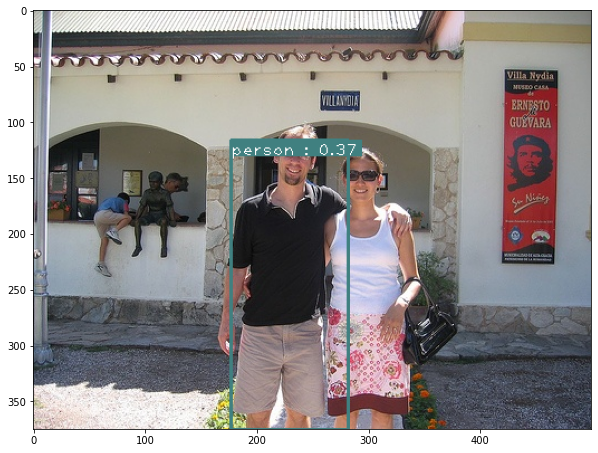

In [ ]:
visualize_image('000310.jpg')